## Metodología de resolución al problema del viajante de comercio
### Trabajo Práctico de Introducción a la Inteligencia Artificial curso 2021

#### Realizado por Axel Lucas Gómez Caamaño (gomezaxel.lucas@gmail.com)

##### Resumen— Se propone una metodología e implementación en Python para una solución al problema del viajante de comercio. El método fue propuesto por Claudio Verrastro, el cual se basa en reglas que acotan el problema de forma convergente garantizando una expansión polinómica cúbica y la existencia de uno o más lazos en perjuicio de la calidad del recorrido obtenido.



In [1]:
import matplotlib.pyplot as plt
import random
import pickle
import os
import json
import logging
from datetime import datetime, timedelta
from itertools import combinations, product

# Función encargada de leer un archivo de configuración del tipo:
# - TSPLIB: biblioteca TSPLIB 95 (http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/) 
# - TSP_IN: biblioteca provista por los docentes de la materia
#
def _leerArchConf(tipo, archivo):
    # Se imprime para agilizar el copiar y pegar luego de procesar un archivo
    print("#algoritmo('{}','{}')".format(tipo,archivo))
    arch = open(archivo)
    # Si el tipo de archivo es TSPLIB, procesar segun su respectivo formato (ver detalle en enlace a la biblioteca)
    if (tipo == "TSPLIB"):
        # Las primeras 3 lineas del archivo se obvian
        for a in range(3):
            arch.readline()
        
        # Mediante el manejo de excepciones, se lee la dimension del problema,
        # teniendo en cuenta que hay archivos que tienen (o no) un espacio entre la N
        # y los dos puntos (:) de la palabra DIMENSION
        try:
            cantCiu = int(arch.readline().split("DIMENSION: ")[1])
        except IndexError:
            cantCiu = int(arch.readline().split("DIMENSION : ")[1])
        
        # Las siguientes 2 lineas del archivo se obvian
        for a in range(2):
            arch.readline()

        # Se arman los vectores de ciudades en función a la lectura del archivo completo
        vec_ciudades = []
        vec_ciudades_map = []

        # Se lee la primer línea del archivo
        line = arch.readline()
        
        # Se arma una lista auxiliar (aux) que contendrá los elementos de dicha primer línea
        # tal que el carácter separador es el ' ' (espacio) si cumple que no sea '' (vacío)
        # ni un salto de línea ('\n')
        aux = [a for a in line.split(' ') if a != '' and a != '\n']
        
        # Se procesa cada línea del archivo tal que no sea igual al texto "EOF" seguido de
        # un salto de línea ('\n'), el cual refiere al final del archivo
        while (line != 'EOF\n'):
            # Mediante el manejo de excepciones, se intenta interpretar a cada elemento, palabra
            # o número, como entero (int) y se lo agrega a la lista vec_ciudades.
            # En caso de una excepción, es decir, no poder interpretarlo como entero, se lo 
            # interpreta como un número con decimal (float) y se lo agrega a la lista vec_ciudades
            try:
                vec_ciudades.append([int(a) for a in aux])
            except:
                vec_ciudades.append([float(a) for a in aux])
            
            # Se lee la siguiente línea. Arch no solo sirve para leer la siguiente línea sino que,
            # al leerla, se pisa con el puntero a la siguiente línea.
            # Es por ello que la reejecución del mismo comando fuerza la lectura por línea a línea
            line = arch.readline()

            # Se arma una lista auxiliar (aux) que contendrá los elementos de dicha primer línea
            # tal que el carácter separador es el ' ' (espacio) si cumple que no sea '' (vacío)
            # ni un salto de línea ('\n')
            aux = [a for a in line.split(' ') if a != '' and a != '\n']
            # en este caso, la lista aux se pisa con el nuevo valor actual perdiendo así el valor
            # que tenía en la primer ejecución del comando que se da antes del while

        # Se arman las tuplas de ciudades de forma tal que para las coordenadas x1 (número) e y1 (número) de la ciudad 1
        # su tupla correspondiente será (1, [x1, y1])
        # de misma forma, para la ciudad 2 con coordenadas x2 e y2
        # su tupla correspondiente será (2, [x2, y2])
        # Entonces, se arma una función map que devolverá dichas tuplas en el orden mencionado
        vec_ciudades_map.append(map(lambda e: (e[0], e[1:]), vec_ciudades))

        # Se arma la lista de las tuplas de ciudades.
        # Partiendo del ejemplo anterior, la salida será: [(1, [x1, y1]),(2, [x2, y2]), ...]
        vec_ciudades_list = [list(a) for a in vec_ciudades_map][0]

        # Se procederá a formar el vector de los costos entre ciudades siguiendo el formato de los archivos del tipo TSPLIB
        # Se declara e inicializa la variable que contendrá el vector de costos entre ciudades
        vec_costCiu = []

        # Se copia en un vector auxiliar la lista de costos entre ciudades
        # esto evita que se modifique dicha lista durante el armado del archivo
        aux = [a for a in vec_ciudades_list]

        # Siempre que la cantidad de elementos, es decir, tuplas de costos, sea mayor a 0: procesar
        while (len(aux) > 0):
            # Se quita a la primera tupla de costos (nro1, [x1, y1]) del vector auxiliar
            # La cual representa a la "ciudad actual"
            # La "ciudad actual" no es más que la primera ciudad que se toma por cada iteración
            # En la primera iteración, dicha ciudad será la primera
            # En la segunda iteración, dicha ciudad será la segunda
            # y así ...
            ciudad_actual = aux.pop(0)
            
            # Se itera sobre las tuplas de costos restantes (las que no son la ciudad actual)
            # Se le asigna a la variable b cada una de dichas tuplas de costos para ser procesada
            # Por medio de la aplicación de Pitágoras (x^2+y^2)=h^2 se calculará el costo
            # entre la ciudad actual y la ciudad en b
            for b in aux:
                # (x^2+y^2)=h^2
                # siendo:
                #   - 'x' la coordenada x de la ciudad actual
                #   - 'y' la coordenada x de la ciudad en la variable b
                #   - 'h' el costo en x a calcular
                costo_x = (ciudad_actual[1][0] - b[1][0])**2

                # (x^2+y^2)=h^2
                # siendo:
                #   - 'x' la coordenada y de la ciudad actual
                #   - 'y' la coordenada y de la ciudad en la variable b
                #   - 'h' el costo en y a calcular
                costo_y = (ciudad_actual[1][1] - b[1][1])**2

                # Se calcula el largo de la hipotenusa 'h' que es el costo de transitar
                # desde la ciudad actual a la ciudad en b
                costo = (costo_x+costo_y)**(1/2)

                # Se agrega dicho costo a la lista/vector de costos entre ciudades
                vec_costCiu.append(costo)

    # Si, por el contrario, el archivo es del tipo TSP_IN:
    # N;<CR>
    # C12;C13;….C1N;[<CR>]C23;C24;…C2N;[<CR>]……C(N-1)N;<CR>
    # EOF

    # siendo: 
    #   - N es el número entero de ciudades del problema
    #   - C12 es el costo (entero) de transitar desde la ciudad 1 a la ciudad 2
    #   - C23 es el costo (entero) de transitar desde la ciudad 1 a la ciudad 3
    #   - <CR> salto de línea para facilitar la lectura
    # 
    # Ej:
    # Para el archivo TSP_IN_01.txt el contenido es el siguiente:
    # 5;
    # 5;15;17;7;6;19;20;7;21;5;
    # Donde:
    #   - la primera línea "5;" indica que el problema tiene 5 ciudades o nodos.
    #   - el costo de transitar la ciudad 1 a la ciudad 2 es 5
    #   - el costo de transitar la ciudad 1 a la ciudad 3 es 15
    #   - el costo de transitar la ciudad 1 a la ciudad 4 es 17
    #   - el costo de transitar la ciudad 1 a la ciudad 5 es 7
    #   - el costo de transitar la ciudad 2 a la ciudad 3 es 6
    #   - el costo de transitar la ciudad 2 a la ciudad 4 es 19
    #   - el costo de transitar la ciudad 2 a la ciudad 5 es 20
    #   - el costo de transitar la ciudad 3 a la ciudad 4 es 7
    #   - el costo de transitar la ciudad 3 a la ciudad 5 es 21
    #   - el costo de transitar la ciudad 4 a la ciudad 5 es 5
    elif (tipo == "TSP_IN"):
        # Se lee la cantidad de ciudades del problema (N)
        cantCiu = int(arch.readline().split(';')[0])
        
        # Se asignan los costos entre ciudades en la lista de costos
        vec_costCiu = [int(a) for a in arch.readline().split(';') if a != '\n']
    else:
        return -1

    # Se cierra el archivo leído
    arch.close()

    # Se declara e inicializa el vector asociado con la matriz de costos entre ciudades, el cual contendrá
    # el vector [C12, C13, ..., C23, C24, ...] asociado a la matriz
    # Se realiza este vector como paso intermedio para finalmente armar la matriz
    # 
    # Dicha matriz contendrá la misma información que el vector de costos con la particularidad
    # que habrá datos redundantes.
    # Esto se utiliza para simplificar la obtención de costos entre cualquier par de ciudades
    # P ej: en un problema de 9 ciudades, si se quisiera conocer el costo de transitar desde
    # la ciudad 3 a la ciudad 8 tomando como base el vector [C12, C13, ..., C23, C24, ...] sería
    # muy complicado. Es por ello que se utiliza la matriz, para 5 ciudades será:
    # C11 C12 C13 C14 C15
    # C21 C22 C23 C24 C25
    # C31 C32 C33 C34 C35
    # C41 C42 C43 C44 C45
    # C51 C52 C53 C54 C55
    # Siendo:
    #   - Cxy el costo de transitar la ciudad x a la ciudad y
    #   - Cnn = 0
    vecmat_costCiu = []
    
    # Se copia en una lista auxiliar el vector de costos entre ciudades previamente calculado
    # esto evita que se modifique dicho vector durante el armado de la matriz
    vec_costCiu_aux = [a for a in vec_costCiu]

    # Para cada ciudad:
    for a in range(cantCiu):
        
        #TODO: optimizar -> c no se usa y se puede hacer mejor un append con ceros
        # Se inicializa en ceros el vector de costos de las ciudades que se utilizara
        # para llenar la matriz de costos
        for c in range(a+1):
            vecmat_costCiu.append(0)
        
        # Se llena el triangulo superior de la matriz
        for b in range(cantCiu-a-1):
            vecmat_costCiu.append(vec_costCiu_aux[0])
            vec_costCiu_aux = vec_costCiu_aux[1:]

    # Se traspone el triangulo superior (tratando a la matriz como vector) y se almacenan sus valores en el triángulo inferior
    # (del vector que representa a la matriz)
    for a in range(cantCiu):
        for b in range(cantCiu):
            if b < a:
                # Si la columna es menor a la fila, se copia el valor de su opuesto
                vecmat_costCiu[cantCiu*a+b] = vecmat_costCiu[cantCiu*b+a]

    # Se compone la matriz en su respectivo formato tomando como base el vector asociado
    mat_costCiu = []
    for a in range(cantCiu):
        mat_costCiu.append(vecmat_costCiu[:cantCiu])
        vecmat_costCiu = vecmat_costCiu[cantCiu:]

    # TODO: eliminar este objeto ya que no se utiliza a lo largo de todo el algoritmo.
    # Se compone el objeto (dict) para agilizar el calculo de costos (costo de N a M).
    obj_costCiu = dict()
    for a in range(1,cantCiu+1):
        indice_1 = "ciudad{}".format(a)
        obj_costCiu[indice_1] = dict()
        for b in range(1,cantCiu+1):
            if (a != b):
                indice_2 = "ciudad{}".format(b)
                obj_costCiu[indice_1][indice_2] = mat_costCiu[a-1][b-1]

    return cantCiu, vec_costCiu, mat_costCiu, obj_costCiu

#cantCiu, vec_costCiu, mat_costCiu, obj_costCiu = _leerArchConf('TSP_IN','TSP/AGD_TSP_IN_04.txt') #[3, 4, 1, 2, 3] con costo: 7
#cantCiu, vec_costCiu, mat_costCiu, obj_costCiu = _leerArchConf('TSP/AGD_TSP_IN_05.txt') #[5, 4, 1, 2, 3, 5] ó  [2, 4, 5, 1, 3, 2] ambos con costo: 10
#cantCiu, vec_costCiu, mat_costCiu, obj_costCiu = _leerArchConf('TSP/AGD_TSP_IN_06.txt') #[4, 5, 1, 6, 3, 2, 4] con costo: 11
#cantCiu, vec_costCiu, mat_costCiu, obj_costCiu = _leerArchConf('TSP/AGD_TSP_IN_07.txt') #[1, 3, 5, 7, 6, 4, 2, 1] con costo: 25
#cantCiu, vec_costCiu, mat_costCiu, obj_costCiu = _leerArchConf('TSP/AGD_TSP_IN_08.txt') #tiene un doble lazo...
#cantCiu, vec_costCiu, mat_costCiu, obj_costCiu = _leerArchConf('TSP_IN','TSP/AGD_TSP_IN_10.txt')
#print(mat_costCiu)

## Regla 1
> Se seleccionará, como caminos candidatos a formar el recorrido óptimo, a los "dos" de menor costo (de los N-1) que acceden a cada nodo.<br>
Se supone que seleccionando estos caminos se podrá entrar y salir de cada nodo por los accesos más cortos.<br>
De esta manera, se reduce a 2.N el número de caminos a considerar.<br>
De los 2.N caminos seleccionados, se eliminan aquellos que estan repetidos.<br>
Usando la propiedad Cij = Cji

In [2]:
# Se hallan los 2 menores costos de cada ciudad

# Se conforma la Lista CS de caminos seleccionados, la cual consiste
# en una matriz de 2 columnas por n filas:
#
#       [[origen1, destino1],
#       [origen1, destino2],
#  CS = [origen2, destino3],
#       [origen2, destino4],
#               ... ]
#
#
def regla1(cantCiu, mat_costCiu):
    # Se declaran e inicializan la variables que contendrán una lista temporal 'mat_regla1'
    # que podrá tener elementos [origen, destino] duplicados y la Lista CS resultado de
    # aplicar la Regla 1
    mat_regla1 = []
    mat_cs = []

    # Para cada ciudad:
    for y in range(cantCiu):
        
        # Se copia una sola fila de la matriz de costos entre ciudades en una variable 'fila'
        fila = mat_costCiu[y].copy()

        # Se elimina el primer costo de la fila
        fila.remove(0)

        # Se itera dos veces sobre cada fila para calcular los 2 menores costos de la misma:
        for a in range(2):
            # Se toma el minimo valor de la fila
            minvalor = min(fila)
            
            # Se toma el máximo valor de la fila
            maxvalor = max(fila)
            
            # Se toma el índice de los elementos de la fila correspondiente al menor valor
            minindice = fila.index(minvalor)

            # Se le asigna al elemento de menor valor el valor del máximo sumado 1
            # Esta asignación se realiza de forma auxiliar para evitar tomar, en la próxima
            # iteración, el mismo elemento
            fila[minindice]=maxvalor+1

            # Se recalcula el índice del elemento de menor valor en función a su ubicación en la fila
            # Para poder obtener con certeza el número de ciudad al que refiere dicho costo
            if (minindice >= y):
                minindice += 2
            else:
                minindice += 1

            # Se calcula cada elemento de la lista resultante por la Regla 1: [origen, destino]
            origen = y+1
            destino = minindice
            
            # Se ordena por numero de ciudad ascendente
            if (origen > destino):
                aux = origen
                origen = destino
                destino = aux
            
            # Si se esta depurando el codigo, se imprime cada elemento [origen, destino] junto con el
            # costo correspondiente
            if (depurando == True):
                print("C{}{}: {}".format(origen, destino, minvalor))
            
            # Se almacena el elemento [origen, destino] ordenado sin tener en cuenta si está duplicado
            mat_regla1.append([origen,destino])

            # Se calcula la matriz teniendo en cuenta no duplicar los elementos
            if ([origen, destino] not in mat_cs):
                mat_cs.append([origen,destino])
    
    # Se retorna la matriz resultante de aplicar la Regla 1
    return mat_cs

#mat_cs = regla1(cantCiu, mat_costCiu)
#print("mat_cs: {}".format(mat_cs))

Al procesar el archivo `AGD_TSP_06.txt`, el resultado de aplicar la Regla 1 es:<br>
`R1 = [[1, 3], [1, 5], [2, 4], [2, 3], [4, 5], [2, 5], [1, 6], [2, 6]]`

## Regla 2
> Computar EAi para todos los nodos<br>
> Para el cómputo del número de arcos (NAi) que concurren en un nodo, basta con contar las repeticiones de un mismo subíndice, en los costos de los caminos seleccionados por R1 (ya sea en la posición i como en la j).<br>

In [3]:
# Las dos funciones de esta sección se pueden utilizar para aplicar la Regla 2 así como
# a lo largo de todo el algoritmo
# Las funciones son para:
# - Calcular exceso de arcos en cada nodo: 'EAi'
# - Calcular exceso de caminos total: 'EC'

# Función auxiliar encargada de calcular el exceso de arcos de la cantidad de ciudades del
# problema (cantCiu) pasada como parámetro y la Lista CS 'mat_cs'
def calcularExcesoArcos(cantCiu, mat_cs):
    # Se declara e inicializa el vector en el cual se almacenarán los excesos de arcos de
    # un modo tal que:
    # [ EAi, EAj, EAk, EAl, … , EAn]      con N nodos/ciudades
    vec_excesoArcos = []

    # Para cada ciudad:
    for a in range(cantCiu):   
        
        # Se agrega el valor -2 como valor inicial para N cantidad de nodos/ciudades.
        # Cada elemento de la lista vec_excesoArcos funciona como un sumador de la cantidad
        # de veces que se repite cada nodo en la Lista CS.
        vec_excesoArcos.append(-2)

    # Para cada elemento de la Lista CS:
    for [origen,destino] in mat_cs:
        
        # Sumar 1 al elemento que representa el exceso de arcos del nodo origen
        vec_excesoArcos[origen-1] += 1

        # Sumar 1 al elemento que representa el exceso de arcos del nodo destino
        vec_excesoArcos[destino-1] += 1
    
    # Se devuelve la lista de Exceso de Arcos de cada nodo
    return vec_excesoArcos

# Función auxiliar encargada de calcular el excedente de caminos
def calcularEc(vec_excesoArcos):
    # Se declara e inicializa la variable 'ec' la cual, inicialmente consiste en un
    # sumador de exceso de arcos de todos los nodos 'EAi', que luego será reemplazado por
    # el valor de excesos de caminos totales 'EC'.
    ec = 0

    # Para cada elemento de exceso de arcos:
    for a in vec_excesoArcos:
        
        # Acumular exceso en 'ec'
        ec += a
    
    # Se realiza el cálculo de exceso de caminos EC
    ec = int(ec/2)

    # Se devuelve la cantidad total de exceso de caminos EC
    return ec

#vec_excesoArcos = calcularExcesoArcos(cantCiu, mat_cs)
#print("vec_excesoArcos: {}".format(vec_excesoArcos))

#ec = calcularEc(vec_excesoArcos)
#print("ec: {}".format(ec))


## Regla 3
> Ordenar de mayor a menor la lista Caminos Seleccionados (CS) por la Regla 1<br>
> Ordenar de menor a mayor los subíndices de los CS de forma que para todo Cij i<j

In [4]:
# Función encargada de ordenar los costos asociados a la Lista CS
# (de caminos seleccionados por Regla 1 y posterior aplicación de la Regla 2)
# La función se puede utilizar para aplicar la Regla 3

# La función de ordenamiento de costos asociados a la Lista CS recibe como parámetros:
# - matriz de costos de todas las ciudades del problema 'mat_costCiu'
# - Lista CS 'mat_cs'
# - variable auxiliar 'reverse' para ordenar de forma ascendente (True) o de forma descendente (False)
def ordenarCostosCS(mat_costCiu, mat_cs, reverse=True):

    # Se declara e inicializa el vector de costos a retornar por la función una vez que se ordenen
    vec_costos = []

    # Para cada elemento de la Lista CS [origen, destino]
    for [origen, destino] in mat_cs:

        # Se toma de la matriz el costo de transitar desde la ciudad origen hasta la ciudad destino
        vec_costos.append(mat_costCiu[origen-1][destino-1])

    # Se procede a ordenar la Lista CS 'mat_cs' de mayor a menor en función a los costos del vector
    # 'vec_costos' anteriormente poblado 
    vec_costos,mat_cs_ordenado = zip(*sorted(zip(vec_costos,mat_cs), reverse=reverse))
    # Explicación técnica de la línea:
        # zip genera un vector (lista) de tuplas con: [(Cij,[origen_i,destino_j]),(Ckl,[origen_k,destino_l]), (...)]
        # sorted(zip) ordena dicha lista en orden asc si reverse=True, en orden desc si reverse=False
        # zip(*) hace un unpack del primer zip, es decir, deshace el primer zip y desglosa la salida en tuplas.
    
    # A modo de ahorro de recursos se utiliza la misma variable 'vec_costos' para almacenar
    # los mismos costos desde 'vec_costos' pero de forma ordenada

    # Se arreglan las tuplas anteriores para que resulten en forma de vector/lista
    vec_costos,mat_cs_ordenado = list(vec_costos),list(mat_cs_ordenado)
    
    # Se devuelve tanto la lista asociada de costos 'vec_costos' como la Lista CS ordenada 'mat_cs_ordenado'
    return vec_costos, mat_cs_ordenado

#vec_costos,mat_cs = ordenarCostosCS(mat_costCiu, mat_cs, reverse=True)
#print("desp ordenarCostosCS: vec_costos: {}, mat_cs_ordenado:{}".format(vec_costos,mat_cs))

## Regla 4
> Explorar la lista CS de mayor a menor y remover los caminos Cij de las lista CS que cumplan con EAi>0 y EAj>0.<br>
> Actualizar EAi=EAi-1 y EAj=EAj-1, EC=EC-1 después de cada eliminación.<br>
> Si EC=0 Terminar (verificar la existencia de más de un lazo).<br>

In [5]:
# Se remueven los caminos Cij de la Lista CS que cumplan con exceso de arcos mayores a 0:
# EAi>0 y EAj>0 actualizando 'EAi', 'EAj' y exceso de caminos 'EC'

# Función encargada de remover caminos de la Lista CS tal y como se expone en la Regla 4
# La función recibe para parámetros:
# - EC exceso de caminos 'ec'
# - Exceso de arcos de cada nodo 'vec_excesoArcos'
# - Lista CS ordenada 'mat_cs_ordenado'
def removerCaminosCS(ec, vec_excesoArcos, mat_cs_ordenado):

    # Se copia la Lista CS ordenada para evitar modificar la Lista ordenada original
    mat_cs_removido = mat_cs_ordenado.copy()

    # Para cada elemento [origen, destino]
    for i,j in mat_cs_ordenado:

        # Si se está depurando el código, se imprimen, en cada iteración, las dos ciudades y el exceso de
        # arcos de cada nodo
        if (depurando == True):
            print("{} {}, vec_excesoArcos[i-1]: {}, vec_excesoArcos[j-1]: {}".format(i, j, vec_excesoArcos[i-1], vec_excesoArcos[j-1]))
        
        # Si EAi > 0 y EAj > 0, entonces:
        if (vec_excesoArcos[i-1] > 0 and vec_excesoArcos[j-1] > 0):
            
            # Si se está depurando el código, se imprimen, en cada iteración, las dos ciudades que cumplen
            # la condición EAi > 0 y EAj > 0 y el exceso de arcos de cada nodo.
            if (depurando == True):
                print("exceso > 0: {} {}, vec_excesoArcos[i-1]: {}, vec_excesoArcos[j-1]: {}".format(i, j, vec_excesoArcos[i-1], vec_excesoArcos[j-1]))
            
            # Se elimina el elemento [origen, destino] correspondiente
            mat_cs_removido.remove([i,j])

            # Se recalcula EAi, EAj y EC
            vec_excesoArcos[i-1] -= 1
            vec_excesoArcos[j-1] -= 1
            ec -= 1

    # Se retorna el exceso de caminos EC 'ec', el exceso de arcos EAi para cada nodo 'vec_excesoArcos'
    # y la Lista CS resultante 'mat_cs_removido'
    return ec, vec_excesoArcos, mat_cs_removido

# Una optimización posible en detrimento de la velocidad del algoritmo y analizando el costo 
# pero con ganancia en la calidad del resultado sería que:
# por cada par EAi>0 y EAj>0 se desglose una rama de posibilidades para que el resultado final
# no dependa del orden en el cual se va eliminando los caminos Cij sino que analice todas las
# opciones posibles.

# Función encargada de calcular el recorrido final el cual consiste en hallar los lazos del recorrido
# solución.
# La explicación completa del funcionamiento de la función se resume en el apartado "Regla 8" del informe
# asociado con el presente trabajo práctico: "Metodología de resolución al problema del viajante de comercio"

# La función toma como parámetros:
# - Cantidad de ciudades del problema 'cantCiu'
# - Lista CS ordenada 'mat_cs_ordenado'
# - Matriz de costos de todas las ciudades 'mat_costCiu'
# - Acumulador de costo con valor inicial 0 para ejecución de forma recursiva 'costo'
# - Lista de ciudades origen resultado de una ejecución anterior de la función 'origenes'
# - Lista de ciudades destino resultado de una ejecución anterior de la función 'destinos'
def calcularRecorridoFinal(cantCiu, mat_cs_ordenado, mat_costCiu, costo = 0, origenes = [], destinos = []):
    
    # Si se está depurando el código, se imprime la Lista CS ordenada tal y como la función recibe como parámetro
    if (depurando == True):
        print("calcRecFinal: mat_cs_ordenado: {}".format(mat_cs_ordenado))

    # Si los vectores origenes y destinos están vacíos, entonces:
    if (origenes == [] and destinos == []):
        
        # Para cada elemento [origen, destino] de la Lista CS ordenada
        for a in mat_cs_ordenado:

            # Agregar un elemento a la lista origenes y a la lista destinos
            origenes.append(a[0])
            destinos.append(a[1])

            # Acumular el costo total en función al costo de transitar desde la ciudad tomada como origen
            # hasta la ciudad tomada como destino
            costo += mat_costCiu[a[0]-1][a[1]-1]

    # Si se está depurando el código, se imprime el estado actual de los vectores origenes y destinos
    if (depurando == True):
        print("calcRecFinal: origenes: {}".format(origenes))
        print("calcRecFinal: destinos: {}".format(destinos))

    # Se declaran e inicializan las variables auxiliares correspondientes
    p = 0 # actúa como índice para ambos vectores: origenes y destinos
    dest = 0 # se utiliza para tomar un solo elemento de la lista destinos
    orig = 0 # se utiliza para tomar un solo elemento de la lista origenes
    recorrido_final = [] # lista a devolver finalmente con el recorrido resultado
    proximo = 0 # actúa como ciudad destino del camino actual y, a la vez, nodo origen del camino próximo
    
    # Para cada ciudad:
    for a in range(cantCiu):
        
        # Si la ciudad es la primera, entonces:
        if (a == 0):
            
            # Se les asignan valores a las variables
            orig = origenes[p] # se toma el elemento correspondiente al vector origenes
            dest = destinos[p] # se toma el elemento correspondiente al vector destinos
            recorrido_final.append(orig) # se agrega la ciudad origen
            recorrido_final.append(dest) # se agrega la ciudad destino correspondiente al origen agregado
            destinos.remove(dest) # se elimina la ciudad destino tomada del vector original
            origenes.remove(orig) # se elimina la ciudad origen tomada del vector original
            proximo = dest # se asigna la próxima ciudad destino como la ciudad destino actual

            # Si se está depurando el código, se imprimen los valores obtenidos hasta el momento de:
            # - Recorrido parcial
            # - Lista origenes
            # - Lista destinos
            if (depurando == True):
                print("calcRecFinal: recorrido_final: {}".format(recorrido_final))
                print("calcRecFinal: origenes: {}".format(origenes))
                print("calcRecFinal: destinos: {}".format(destinos))
        
        # Si la ciudad no es la primera tomada, entonces:
        else:
            try:
                try:
                    # Siempre y cuando la nueva ciudad destino exista dentro de la lista destinos
                    p = destinos.index(proximo) # se asigna el índice de la nueva ciudad destino 
                    orig = origenes[p] # se toma el elemento del vector origenes en función al índice obtenido
                    dest = destinos[p] # se toma el elemento del vector destinos en función al índice obtenido
                    destinos.pop(p) # se elimina el elemento anteriormente tomado
                    origenes.pop(p) # se elimina el elemento anteriormente tomado
                except ValueError:
                    # Siempre y cuando la nueva ciudad destino no exista dentro de la lista destinos
                    # Es decir, siempre y cuando la nueva ciudad destino exista dentro de la lista origenes
                    p = origenes.index(proximo) # se asigna el índice de la nueva ciudad destino  
                    dest = origenes[p] # se toma el elemento del vector origenes en función al índice obtenido
                    orig = destinos[p] # se toma el elemento del vector destinos en función al índice obtenido
                    destinos.pop(p) # se elimina el elemento anteriormente tomado
                    origenes.pop(p) # se elimina el elemento anteriormente tomado
                
                # Si la nueva ciudad destino (almacenada en 'proximo') no coincide con la ciudad origen actual
                if (proximo != orig):
                    proximo = orig # se asigna la ciudad origen actual como la nueva ciudad destino
                else:
                    proximo = dest # se asigna la ciudad destino actual como la nueva ciudad destino
                recorrido_final.append(proximo) # Se agrega la nueva ciudad destino al recorrido final
            except ValueError:

                # Si se llega hasta aquí es porque, posiblemente, se tenga mas de un lazo en la solución.
                # Cuando esto sucede, no hay forma que la nueva ciudad destino esté presente tanto en el
                # vector origenes como en el vector destinos, debido a que dicho lazo se cerró y habrá que
                # armar otros lazos para completar el recorrido solución.

                # Si, efectivamente, se completó un lazo, la primera ciudad 'recorrido_final[0]' será igual a la
                # última ciudad agregada al recorrido 'proximo' así como el largo de los vectores origenes y destinos
                # será mayor a 0, con lo cual, se estará frente a la presencia de más de un lazo, entonces:
                if (recorrido_final[0] == proximo and len(origenes) > 0 and len(destinos) > 0):
                    # Se tiene mas de un lazo

                    # Si se está depurando el código, imprimir que "Se tiene mas de un lazo"
                    if (depurando == True):
                        print("Se tiene mas de un lazo")

                    # En tal caso, se deberá formar un nuevo lazo llamando de forma recursiva a la función de cálculo
                    # del recorrido final pasando como parámetros el resto de caminos (origenes, destinos y costo).
                    
                    # TODO: A futuro se puede calcular las ciudades donde conviene más unir dichos lazos
                    
                    # Si se está depurando el código, se imprime el vector origenes y destinos
                    if (depurando == True):
                        print("calcRecFinal: origenes: {}".format(origenes))
                        print("calcRecFinal: destinos: {}".format(destinos))

                    # Se llama nuevamente a la función de cálculo del recorrido final pasando los parámetros:
                    # - Cantidad de ciudades del problema 'cantCiu' (mismo valor que en el primer llamado de la función)
                    # - Lista CS ordenada 'mat_cs_ordenado' (mismo valor que en el primer llamado de la función)
                    # - Matriz de costos de todas las ciudades 'mat_costCiu' (mismo valor que en el primer llamado de la función)
                    # - Acumulador de costo con valor inicial 0 para ejecución de forma recursiva 'costo' (varía entre llamado y llamado)
                    # - Lista de ciudades origen resultado de una ejecución anterior de la función 'origenes' (varía entre llamado y llamado)
                    # - Lista de ciudades destino resultado de una ejecución anterior de la función 'destinos' (varía entre llamado y llamado)
                    recorrido_parcial, costo = calcularRecorridoFinal(cantCiu, mat_cs_ordenado, mat_costCiu, costo, origenes, destinos)
                    
                    # Si se está depurando el código, se imprime el recorrido parcial actual con su costo acumulativo asociado
                    if (depurando == True):
                        print("Un recorrido parcial es: {} con costo parcial: {}".format(recorrido_parcial, costo))
                    
                    # Se agrega el recorrido parcial correspondiente al lazo encontrado al recorrido final (total
                    # de lazos encontrados)
                    recorrido_final.append(recorrido_parcial)

                    # Se devuelve el recorrido final con su costo asociado
                    return recorrido_final, costo

            # Si se está depurando el código, se imprime el recorrido final (total de lazos encontrados)
            # y las listas origenes y destinos
            if (depurando == True):
                print("calcRecFinal: recorrido_final: {}".format(recorrido_final))
                print("calcRecFinal: origenes: {}".format(origenes))
                print("calcRecFinal: destinos: {}".format(destinos))

    # Se retorna la totalidad de los lazos encontrados y su costo asociado
    return recorrido_final, costo


#ec, vec_excesoArcos, mat_cs = removerCaminosCS(ec, vec_excesoArcos, mat_cs)
#vec_costos,mat_cs = ordenarCostosCS(mat_costCiu, mat_cs, reverse=True)
#print("desp removerCaminosCS: vec_costos: {}, mat_cs_ordenado: {}, vec_excesoArcos: {}".format(vec_costos,mat_cs,vec_excesoArcos))

#if (ec == 0):
#    recorrido_final, costo = calcularRecorridoFinal(cantCiu, mat_cs, mat_costCiu)
#    print("Terminó, recorrido final es: {} con costo: {}".format(recorrido_final, costo))


In [6]:
# La función próxima a describir se explica detalladamente en el apartado "Regla 5" del informe
# asociado con el presente trabajo práctico: "Metodología de resolución al problema del viajante de comercio"
# 
# A modo conceptual, la función que calcula la Lista A como consecuencia de aplicar la Regla 5 se calcula
# de la siguiente forma:
'''
obtener los nodos tal que EAi > 1 y EAi > 0
Por cada nodo se evalua su exceso de arcos
	si es mayor a 1
		hallar caminos que pasen por el nodo i
		tomar dichos caminos de a pares, por cada par evaluar:
			puentes_elegidos = []
			si el puente resultante del par:
				1. existe en la lista CS => descartar
				2. es un puente ya tomado => descartar (esta opción puede nunca ser verdadera)
				3. es un camino Cii => descartar (esta opcion nunca sera verdadera)
			sino:
				hallar su ahorro tal que Aii = Cij + Cik - Cjk
				agregar dicho puente a la lista de puentes con ahorro calculado
	si es mayor a 0
		tomar otro nodo que tenga EAj > 0, en caso de encontrarlo:
			hallar caminos que pasen por el nodo i y el nodo j
			tomar dichos caminos de a pares, por cada par evaluar:
				puentes_elegidos = []
				si el puente resultante del par:
					1. existe en la lista CS => descartar
					2. es un puente ya tomado => descartar
					3. es un camino Cii => descartar
				sino:
					hallar su ahorro tal que Aii = Cij + Cik - Cjk
					agregar dicho puente a la lista de puentes con ahorro calculado (para no tener que
                    calcular el ahorro del mismo puente)
'''

# Función encargada de calcula la Lista A como consecuencia de aplicar la Regla 5
# La función recibe como parámetros:
# - Cantidad de ciudades del problema 'cantCiu'
# - Matriz de costos de todas las ciudades 'mat_costCiu'
# - Lista de Exceso de Arcos 'EAi' de cada nodo
# - Lista CS ordenada 'mat_cs_ordenado'
# La función devuelve la Lista A con el siguiente formato:
#                          [[ i, [k, l], i ],
# Ahorro Puentes (AP) =     [ m, [n, o], p ],
#                                ... ]
#
# Siendo:
# - [ i, [k, l], i ] es la representación del puente 'kl' que reemplaza a los pares 'ik' e 'il'
# - [ m, [n, o], p ] es la representación del puente 'no' que reemplaza a los pares 'mn' y 'op'
# Se opta por una nomenclatura para la Lista A del tipo "Ahorro Puentes" ó "AP" debido a que resulta
# necesario explicitar qué ciudades involucra cada puente.
# En el apartado "Regla 5" del informe del presente trabajo práctico: "Metodología de resolución al
# problema del viajante de comercio" se detalla exhaustivamente el por qué de dicha representación

# La función tambien devuelve el ahorro asociado con cada puente o, mejor dicho, ahorro puente, con
# el siguiente formato:
# Ahorro = [Aikli, Amnop, … ]
# 
# Siendo:
# - 'Aikli' el ahorro 'Akl' correspondiente al reemplazo de los pares 'ik' y 'li'
# - 'Amnop' el ahorro 'Ano' correspondiente a la sustitución de los pares 'mn' y 'op'

def calcularListaA(cantCiu, mat_costCiu, ec, vec_excesoArcos, mat_cs_ordenado):

    # Se declara e inicializan los vectores que contendrán:
    # - ahorros 'vec_a_ahorro' ó Ahorro
    # - puentes 'vec_a_puente' ó Ahorro Puentes
    vec_a_ahorro = []
    vec_a_puente = []

    # Si EC = 0, terminar
    if (ec == 0):
        # Se devuelve EC 'ec', la Lista de Ahorros 'vec_a_ahorro' asociada a la Lista de Ahorro
        # Puentes 'vec_a_puente' 
        return ec, vec_a_ahorro, vec_a_puente
    
    # Si EC es distinto a 0, entonces:
    else:

        # Conceptualmente, hay que armar una lista A con todos los Aii con EAi>1 y todos los Aij
        # con EAi>0 y EAj>0 que tengan un camino puente que NO pertenezca a CS y el puente no sea
        # un Camino Cii.

        # Si se está depurando el código, se imprime la Lista CS ordenada
        if (depurando == True):
            print("calc listaA: mat_cs_ordenado: {}".format(mat_cs_ordenado))
        
        # TODO: con el fin de evitar procesar por duplicado, se podría agregar un vector que acumule
        # los pares de ciudades que se tomaron con EAi > 0 y EAj > 0 para luego poner un filtro adicional
        # al 'if' que compruebe 'and [ij] not in mat_cs_ordenado and ji not in mat_cs_ordenado'

        # Para cada ciudad:
        for i in range(1,cantCiu+1):
            # Se denomina 'Aii' al ahorro asociado al reemplazo de un par de caminos que contienen a una
            # misma ciudad en cada uno de ellos

            # Para Aii con EAi > 1
            if (vec_excesoArcos[i-1] > 1):
                
                # Se deberán tomar los pares de caminos de CS tal que la ciudad 'a' figure en ambos caminos
                
                # Se copia la Lista CS ordenada en una variable auxiliar 'max_cs_aux'
                mat_cs_aux = mat_cs_ordenado.copy()

                # Se declara e inicializa una lista de ahorros temporal la cual será utilizada para armar la lista A
                mat_cs_ahorros = []
                
                # Se busca dentro de 'mat_cs_aux' todos los caminos que contengan a la ciudad 'a'
                
                # Para cada elemento de la variable auxiliar 'mat_cs_aux' que contiene Lista CS ordenada:
                for b in mat_cs_aux:

                    # Si la ciudad 'i' está presente en el camino 'b' como origen o destino, entonces
                    if (b[0] == i or b[1] == i):

                        # Se asigna 'b' a la variable 'cs_aux'
                        cs_aux = b

                        # Se agrega 'cs_aux' a la lista de ahorros temporal 'mat_cs_ahorros'
                        mat_cs_ahorros.append(cs_aux)
                
                # Si se está depurando el código, se imprime la lista de ahorros temporal
                if (depurando == True):
                    print("EAi > 1: mat_cs_ahorros: {}".format(mat_cs_ahorros))

                # Se arman todas las combinaciones posibles de la lista de ahorros temporal 'mat_cs_ahorros'
                # Las cuales consisten en tomar de a pares todos los elemenos de 'mat_cs_ahorros'
                tup_cs_ahorros_combinado = combinations(mat_cs_ahorros,2)
                mat_cs_ahorros_combinado = []
                for r in tup_cs_ahorros_combinado:
                    mat_cs_ahorros_combinado.append([r[0],r[1]])
                # Mediante estas combinaciones se arman los puentes próximos a evaluar. En los cuales se deberán
                # medir los respectivos ahorros, de dichos puentes, en comparación con los pares de caminos
                # que reemplazarían

                # En función al abanico de posibilidades se deberán filtrar aquellos que cumplan con la condición de:
                # - los puentes correspondientes a los pares de caminos seleccionados que no pertenezcan a CS
                # - los puentes ya tomados
                # - los puentes que sean un camino Cii
                
                # Si se está depurando el código, se imprime 
                if (depurando == True):
                    print("EAi > 1: mat_cs_ahorros_combinado: {}".format(mat_cs_ahorros_combinado))
                
                # Se declara e inicializa una variable 'vec_puente_aux' la cual se utilizará para armar los ahorro puentes
                # ya filtrados en base a la condición anteriormente mencionada
                vec_puente_aux = []
                comp_i = i # variable auxiliar que ayuda en el filtrado de puentes ya explicado
                comp_j = 0 # variable auxiliar que ayuda en el filtrado de puentes ya explicado

                # Para cada posibilidad/combinación de puentes ya calculados:
                for o in mat_cs_ahorros_combinado:
                    
                    # Se declara e inicializan las variables auxiliares 'o_k' y 'o_l' que solucionan un problema
                    # de optimización del Python en la implementación de la iteración aquí presente. Dichas variables
                    # mitigan un problema de ejecución en paralelo de las 4 validaciones posteriores
                    # Sin las variables, el código no funcionaría correctamente porque Python intenta ejecutar en
                    # paralelo las 4 validaciones ('if') y ello produce inconsistencias en el funcionamiento
                    o_k = -1
                    o_l = -1

                    # Se toma como puente [o_k, o_l] todo lo que no contenga a la ciudad 'i' ya que el puente
                    # deberá reemplazar un par de caminos que contengan a la ciudad 'i' y no sería esperable tener
                    # a la ciudad 'i' tanto en el par de caminos a reemplazar como en el puente que los reemplaza
                    if(o[0][0] == comp_i):
                        o_k = o[0][1]
                    if(o[0][1] == comp_i):
                        o_k = o[0][0]
                    if(o[1][0] == comp_i):
                        o_l = o[1][1]
                    if(o[1][1] == comp_i):
                        o_l = o[1][0]

                    # Si esto ocurre, se está frente al problema mencionado anteriormente
                    # En un funcionamiento consistente, esta condición nunca será verdadera
                    if (o_k == -1 or o_l == -1):
                        print("ERROR o:{}, o_k:{} o_l:{}".format(o, o_k, o_l))
                    
                    # Se declara e inicializa la variable auxiliar 'aux' Ahorro Puente
                    aux = [comp_i, [o_k, o_l], comp_j]

                    # Se valida que el puente no sea un puente que exista en la Lista CS ordenada
                    if (([aux[1][1],aux[1][0]] not in mat_cs_ordenado )
                    and ([aux[1][0],aux[1][1]] not in mat_cs_ordenado )
                    and (o_k != -1)
                    and (o_l != -1)): #TODO: ver si aparece x,y en vez de y,x lo toma o no..
                        
                        # En el caso que sea un ahorro puente deseado, se agrega a la lista de Ahorro Puentes válidos
                        vec_puente_aux.append(aux)

                        # Si se está depurando el código, se imprime la variable auxiliar del Ahorro Puente
                        # 'vec_puente_aux' y su Puente asociado 'aux'
                        if (depurando == True):
                            print("EAi > 1: vec_puente_aux: {}, vec_puente_aux.append({})".format(vec_puente_aux, aux))

                # Para cada elemento Ahorro Puente de la lista de Ahorro Puentes 'vec_puente_aux'
                # se calcula el ahorro de cada puente
                for e in vec_puente_aux:

                    # Se toma el costo asociado a cada par de caminos
                    costo_ij = mat_costCiu[e[0]-1][e[1][0]-1]
                    costo_ik = mat_costCiu[e[0]-1][e[1][1]-1]
                    
                    # Se toma el costo asociado al puente
                    costo_jk = mat_costCiu[e[1][0]-1][e[1][1]-1]
                    
                    # Se calcula el ahorro tal y como se explicita en la "Regla 5"
                    # Ahorro = Sumatoria del costo par de caminos - Costo Puente
                    ahorro_ii = costo_ij + costo_ik - costo_jk

                    # Se agrega dicho ahorro a la Lista de Ahorros
                    vec_a_ahorro.append(ahorro_ii)
                    # Se agrega el Puente Ahorro tomado inicialmente a la Lista de Ahorro Puentes final (Lista A)
                    vec_a_puente.append(e)
                
                # Si se está depurando el código, se imprime el estado actual de la Lista de Ahorros y de la Lista
                # de Ahorro Puentes
                if (depurando == True):
                    print("EAi > 1: vec_a_ahorro: {}".format(vec_a_ahorro))
                    print("EAi > 1: vec_a_puente: {}".format(vec_a_puente))
            
            # Para Aij con EAi>0 y EAj>0
            if (vec_excesoArcos[i-1] > 0 ):

                # Se declara e inicializa una variable auxiliar 'ciudades_aux' que comprenderá todas las
                # ciudades posibles menos la ciudad 'i'
                ciudades_aux = [r for r in range(1,cantCiu+1)]
                ciudades_aux.remove(i)

                # Para cada ciudad restante (sin incluir a la ciudad 'i')
                for j in ciudades_aux:

                    # Si se está depurando el código, se imprimen las ciudades 'i' y 'j'
                    if (depurando == True):
                        print("EAi>0 y EAj>0: i: {}, j: {}".format(i,j))
                    
                    # Si EAj > 0 y camino [i,j] o [j,i] no exista en la Lista CS ordenada
                    if (vec_excesoArcos[j-1] > 0
                        and [i,j] not in mat_cs_ordenado
                        and [j,i] not in mat_cs_ordenado):
                        
                        # Se hallan los caminos que pasen por el nodo i y el nodo j

                        # Se copia la Lista CS ordenada en la variable auxiliar 'mat_cs_aux'
                        mat_cs_aux = mat_cs_ordenado.copy()

                        # Se declaran e inicializan las Listas de ahorros temporal pertenecientes a las ciudades 'i' y 'j'
                        # Esto permite, a diferencia de las combinaciones posibles para 'Aii', encontrar el abanico de 
                        # posibilidades entre los puentes a utilizar de 'i' y de 'j'.
                        # Al realizar el producto entre ambas listas, se podrá obtener las combinaciones posibles.
                        mat_cs_ahorros_i = []
                        mat_cs_ahorros_j = []

                        # Para cada ciudad de la Lista CS ordenada (auxiliar)
                        for b in mat_cs_aux:

                            # Si la ciudad 'i' está presente en el camino 'b' como origen o destino, entonces
                            if (b[0] == i or b[1] == i):
                                
                                # Se asigna 'b' a la variable 'cs_aux'
                                cs_aux = b

                                # Se agrega 'cs_aux' a la lista de ahorros temporal 'mat_cs_ahorros_i'
                                mat_cs_ahorros_i.append(cs_aux)
                            
                            # Si la ciudad 'j' está presente en el camino 'b' como origen o destino, entonces
                            if (b[0] == j or b[1] == j):

                                # Se asigna 'b' a la variable 'cs_aux'
                                cs_aux = b

                                # Se agrega 'cs_aux' a la lista de ahorros temporal 'mat_cs_ahorros_j'
                                mat_cs_ahorros_j.append(cs_aux)

                        # Si se está depurando el código, se imprimen las listas de ahorros temporal correspondientes
                        # a las ciudades 'i' y 'j'
                        if (depurando == True):
                            print("EAi>0 y EAj>0: mat_cs_ahorros_i: {}, mat_cs_ahorros_j: {}".format(mat_cs_ahorros_i, mat_cs_ahorros_j))

                        # Se combinan todos los elementos tomados de a 1 por cada grupo: 'mat_cs_ahorros_i' y 'mat_cs_ahorros_j'
                        # Esto resulta en todas las combinaciones posibles entre ambas listas
                        tup_cs_ahorros_combinado = product(mat_cs_ahorros_i, mat_cs_ahorros_j)
                        
                        # Se declara e inicializa la variable que contendrá la lista de puentes a filtrar
                        mat_cs_ahorros_combinado = []
                        for r in tup_cs_ahorros_combinado:
                            mat_cs_ahorros_combinado.append([r[0],r[1]])
                
                        # Si se está depurando el código, se imprime el estado actual de la lista de puentes a filtrar
                        if (depurando == True):
                            print("EAi>0 y EAj>0: mat_cs_ahorro_aux: {}".format(mat_cs_ahorros_combinado))

                        # Se hallan los puentes correspondientes a los pares de caminos seleccionados que:
                        # - no pertenezcan a CS
                        # - no sea un puente ya tomado en la iteración
                        # - no sea un puente ya tomado dentro de todos los calculados
                        # - no sea un camino Cii

                        # Se declara e inicializa una variable 'vec_puente_aux' la cual se utilizará para armar los ahorro puentes
                        # ya filtrados en base a la condición anteriormente mencionada
                        vec_puente_aux = []
                        comp_i = i # variable auxiliar que ayuda en el filtrado de puentes ya explicado
                        comp_j = j # variable auxiliar que ayuda en el filtrado de puentes ya explicado

                        # Para cada posibilidad/combinación de puentes ya calculados:
                        for o in mat_cs_ahorros_combinado:
                            
                            # Se declara e inicializan las variables auxiliares 'o_k' y 'o_l' que solucionan un problema
                            # de optimización del Python en la implementación de la iteración aquí presente. Dichas variables
                            # mitigan un problema de ejecución en paralelo de las 4 validaciones posteriores
                            # Sin las variables, el código no funcionaría correctamente porque Python intenta ejecutar en
                            # paralelo las 4 validaciones ('if') y ello produce inconsistencias en el funcionamiento
                            o_k = -1
                            o_l = -1

                            # Se toma como puente [o_k, o_l] siempre y cuando 'o_k' contenga a la ciudad 'i' y 'o_l' contenga
                            # a la ciudad 'j' ya que el puente deberá reemplazar un par de caminos de ambas ciudades
                            if(o[0][0] == comp_i):
                                o_k = o[0][1]
                            if(o[0][1] == comp_i):
                                o_k = o[0][0]
                            if(o[1][0] == comp_j):
                                o_l = o[1][1]
                            if(o[1][1] == comp_j):
                                o_l = o[1][0]

                            # Si esto ocurre, se está frente al problema mencionado anteriormente
                            # En un funcionamiento consistente, esta condición nunca será verdadera
                            if (o_k == -1 or o_l == -1):
                                print("ERROR o:{}, o_k:{} o_l:{}".format(o, o_k, o_l))

                            # Se declara e inicializa la variable auxiliar 'aux' Ahorro Puente
                            aux = [comp_i, [o_k, o_l], comp_j]

                            # Se valida que:
                            # - el puente no sea un puente que exista en la Lista CS ordenada
                            # - el ahorro puente no se haya tomado en esta iteración
                            # - el ahorro puente no se haya tomado en alguna iteración anterior
                            # - el ahorro puente no contenga un puente con camino Cii
                            # - no haya habido un error de consistencia por el problema del paralelismo en la implementación
                            #   de Python anteriormente mencionada
                            if (( [aux[1][1],aux[1][0]] not in mat_cs_ordenado )
                            and ( [aux[1][0],aux[1][1]] not in mat_cs_ordenado )
                            and ( [comp_i,[aux[1][1],aux[1][0]],comp_j] not in vec_puente_aux )
                            and ( [comp_i,[aux[1][0],aux[1][1]],comp_j] not in vec_puente_aux )
                            and ( [comp_j,[aux[1][0],aux[1][1]],comp_i] not in vec_puente_aux )
                            and ( [comp_j,[aux[1][1],aux[1][0]],comp_i] not in vec_puente_aux )  
                            and ( [comp_i,[aux[1][1],aux[1][0]],comp_j] not in vec_a_puente )
                            and ( [comp_i,[aux[1][0],aux[1][1]],comp_j] not in vec_a_puente ) 
                            and ( [comp_j,[aux[1][0],aux[1][1]],comp_i] not in vec_a_puente )
                            and ( [comp_j,[aux[1][1],aux[1][0]],comp_i] not in vec_a_puente ) 
                            and ( aux[1][0] != aux[1][1])
                            and (o_k != -1)
                            and (o_l != -1)):

                                # En el caso que sea un ahorro puente deseado, se agrega a la lista de Ahorro Puentes válidos
                                vec_puente_aux.append(aux)

                                 # Si se está depurando el código, se imprime la variable auxiliar del Ahorro Puente
                                 # 'vec_puente_aux' y su Puente asociado 'aux'
                                if (depurando == True):
                                    print("EAi>0 y EAj>0: vec_puente_aux: {}, vec_puente_aux.append({})".format(vec_puente_aux, aux))

                        # Para cada elemento Ahorro Puente de la lista de Ahorro Puentes 'vec_puente_aux'
                        # se calcula el ahorro de cada puente
                        for e in vec_puente_aux:

                            # Se toma el costo asociado a cada par de caminos
                            costo_ik = mat_costCiu[e[0]-1][e[1][0]-1]
                            costo_jl = mat_costCiu[e[2]-1][e[1][1]-1]

                            # Se toma el costo asociado al puente
                            costo_kl = mat_costCiu[e[1][0]-1][e[1][1]-1]

                            # Se calcula el ahorro tal y como se explicita en la "Regla 5"
                            # Ahorro = Sumatoria del costo par de caminos - Costo Puente
                            ahorro_ij = costo_ik + costo_jl - costo_kl

                            # Se agrega dicho ahorro a la Lista de Ahorros
                            vec_a_ahorro.append(ahorro_ij)
                            # Se agrega el Puente Ahorro tomado inicialmente a la Lista de Ahorro Puentes final (Lista A)
                            vec_a_puente.append(e)

                        # Si se está depurando el código, se imprime el estado actual de la Lista de Ahorros y de la Lista
                        # de Ahorro Puentes
                        if (depurando == True):
                            print("EAi>0 y EAj>0: vec_a_ahorro: {}".format(vec_a_ahorro))
                            print("EAi>0 y EAj>0: vec_a_puente: {}".format(vec_a_puente))
        
        # Se procede a ordenar la lista A de mayor a menor en función a la Lista de Ahorros 'vec_a_ahorro' asociada con la 
        # Lista de Ahorro Puentes 'vec_a_puente'
        vec_a_ahorro,vec_a_puente = zip(*sorted(zip(vec_a_ahorro,vec_a_puente), reverse=True))
        vec_a_ahorro,vec_a_puente = list(vec_a_ahorro),list(vec_a_puente)
        
        # Se calcula el exceso de caminos EC 'ec' pasando como parámetro la lista de exceso de arcos actual
        ec = calcularEc(vec_excesoArcos)

    # Se devuelve el exceso de caminos EC 'ec', la Lista de Ahorros 'vec_a_ahorro' y su correspondiente Lista de Ahorro
    # Puentes 'vec_a_puente'
    return ec, vec_a_ahorro, vec_a_puente


# ====================== REGLA 5 y 6 ===========================
#ec, vec_a_ahorro, vec_a_puente = calcularListaA(cantCiu, mat_costCiu, ec, vec_excesoArcos, mat_cs)
#print("desp calcularListaA: ec: {}, vec_a_ahorro: {}, vec_a_puente{}".format(ec, vec_a_ahorro, vec_a_puente))


## Regla 5
> Si EC > 0
> Armar una lista A con todos los Aii con EAi>1 y todos los Aij con EAi>0 y EAj>0 que tengan un camino puente que NO pertenezca a CS y el puente no es un Camino Cii.

## Regla 6
> Ordenar de mayor a menor la lista A


## Regla 7
> Remover el primer elemento de la lista A el Aij mayor<br>
Aplicar el ahorro removiendo de la Lista CS los caminos Cik y Cjl y agregando el puente Ckl.<br>
Actualizar EAi= EAi -1 y EAj= EAj -1, EC=EC-1 después de cada eliminación.<br>
Si EC=0 Terminar (verificar la existencia de más de un lazo).<br>
Actualizar la Lista A con el agregado de los ahorros válidos Akx y Alx<br>

Aplicar recursivamente las Regla 6 y 7 hasta que EC=0<br>

In [7]:
def regla7(cantCiu, mat_costCiu, ec, vec_excesoArcos, mat_cs, vec_a_ahorro, vec_a_puente):
    while (ec > 0):
        # ====================== REGLA 7 ===========================
        # Remover el primer elemento de la lista A
        a_ahorro_aux = vec_a_ahorro.pop(0)
        a_puente_aux = vec_a_puente.pop(0) ## [i, [k,l], j]
        i = a_puente_aux[0]
        k = a_puente_aux[1][0]
        l = a_puente_aux[1][1]
        j = a_puente_aux[2]
        if (depurando == True):
            print("inic while: a_ahorro_aux: {}, a_puente_aux: {}".format(a_ahorro_aux,a_puente_aux))    

        mat_cs_aux = [a for a in mat_cs]
        if (depurando == True):
            print("inic while: mat_cs_aux: {}".format(mat_cs_aux))    

        # Aplicar el ahorro removiendo de la Lista CS los caminos Cik y Cjl y agregando el puente Ckl.
        if (j == 0):
            ## si se tiene un ahorro del tipo Aii (j = 0)
            # reemplazar ik e il por kl
            try:
                if (depurando == True):
                    print("Aii => j == 0: [i, [k, l], j]: [{}, [{}, {}], {}]".format(i, k, l, j))
                    print("antes de eliminar: mat_cs_aux: {}".format(mat_cs_aux))
                
                ai = []
                try:
                    mat_cs_aux.index([i,k])
                    ai = [i, k]
                except ValueError:
                    mat_cs_aux.index([k,i])
                    ai = [k, i]
                
                aj = []
                try:
                    mat_cs_aux.index([i,l])
                    aj = [i,l]
                except ValueError:
                    mat_cs_aux.index([l,i])
                    aj = [l,i]

                mat_cs_aux.remove(ai)
                mat_cs_aux.remove(aj)
                mat_cs_aux.append([k,l])
                if (depurando == True):
                    print("despues de eliminar mat_cs_aux: {}".format(mat_cs_aux))

                # Actualizar EAi= EAi -1 y EAj= EAj -1, EC=EC-1 después de cada eliminación.
                # EAi = EAi - 2
                vec_excesoArcos[i-1] -= 2
                ec -= 1
                if (depurando == True):
                    print("ec: {}, vec_excesoArcos: {}".format(ec, vec_excesoArcos))

            except ValueError:
                if (depurando == True):
                    print("Value Error")
        else:
            ## si se tiene un ahorro del tipo Aij
            # reemplazar ik y jl por kl
            try:
                if (depurando == True):
                    print("Aij => j != 0: [i, [k, l], j]: [{}, [{}, {}], {}]".format(i, k, l, j))
                    print("antes de eliminar: mat_cs_aux: {}".format(mat_cs_aux))
                
                ai = []
                try:
                    mat_cs_aux.index([i,k])
                    ai = [i, k]
                except ValueError:
                    mat_cs_aux.index([k,i])
                    ai = [k, i]
                
                aj = []
                try:
                    mat_cs_aux.index([j,l])
                    aj = [j,l]
                except ValueError:
                    mat_cs_aux.index([l,j])
                    aj = [l,j]

                mat_cs_aux.remove(ai)
                mat_cs_aux.remove(aj)
                mat_cs_aux.append([k,l])
                if (depurando == True):
                    print("despues de eliminar mat_cs_aux: {}".format(mat_cs_aux))
                
                # Actualizar EAi= EAi -1 y EAj= EAj -1, EC=EC-1 después de cada eliminación.
                # EAi = EAi - 1 y EAj = EAj - 1
                vec_excesoArcos[i-1] -= 1
                vec_excesoArcos[j-1] -= 1
                ec -= 1
                if (depurando == True):
                    print("ec: {}, vec_excesoArcos: {}".format(ec, vec_excesoArcos))

            except ValueError:
                if (depurando == True):
                    print("Value Error")

        if (depurando == True):
            print("mat_cs_aux: {}".format(mat_cs_aux))
        mat_cs = mat_cs_aux

        #Actualizar la Lista A con el agregado de los ahorros válidos Akx y Alx
            # a la lista de puentes hay que filtrar los caminos ya quitados
        # por simplicidad se vuelve a calcular lista A #TODO: ver como optimizar esto
        ec, vec_a_ahorro, vec_a_puente = calcularListaA(cantCiu, mat_costCiu, ec, vec_excesoArcos, mat_cs)
        if (depurando == True):
            print("desp calcularListaA: ec: {}, vec_excesoArcos: {}, vec_a_ahorro: {}, vec_a_puente{}".format(ec, vec_excesoArcos, vec_a_ahorro, vec_a_puente))
            print("EN EL WHILE")

    #Si EC=0 Terminar (verificar la existencia de más de un lazo).
    if (ec == 0):
        if (depurando == True):
            print("ec es 0")
        recorrido_final, costo = calcularRecorridoFinal(cantCiu, mat_cs, mat_costCiu)
        print("Terminó, recorrido final es: {} con costo: {}".format(recorrido_final, costo))
    return

#regla7(cantCiu, mat_costCiu, ec, vec_excesoArcos, mat_cs, vec_a_ahorro, vec_a_puente)

In [8]:
def algoritmo(tipo, archivo):
    antes = datetime.now().timestamp()
    cantCiu, vec_costCiu, mat_costCiu, obj_costCiu = _leerArchConf(tipo, archivo) #tiene un doble lazo...
    if (depurando == True):
        print("mat_costCiu: {}".format(mat_costCiu))

    mat_cs = regla1(cantCiu, mat_costCiu)
    if (depurando == True):
        print("mat_cs: {}".format(mat_cs))

    vec_excesoArcos = calcularExcesoArcos(cantCiu, mat_cs)
    if (depurando == True):
        print("vec_excesoArcos: {}".format(vec_excesoArcos))

    ec = calcularEc(vec_excesoArcos)
    if (depurando == True):
        print("ec: {}".format(ec))
    if (ec == 0):
        recorrido_final, costo = calcularRecorridoFinal(cantCiu, mat_cs, mat_costCiu)
        print("Terminó, recorrido final es: {} con costo: {}".format(recorrido_final, costo))
        print("{} s".format(datetime.now().timestamp() - antes))
    else:
        vec_costos,mat_cs = ordenarCostosCS(mat_costCiu, mat_cs, reverse=True)
        ec, vec_excesoArcos, mat_cs = removerCaminosCS(ec, vec_excesoArcos, mat_cs)
        vec_costos,mat_cs = ordenarCostosCS(mat_costCiu, mat_cs, reverse=True)
        if (depurando == True):
            print("desp removerCaminosCS: vec_costos: {}, mat_cs_ordenado: {}, vec_excesoArcos: {}".format(vec_costos,mat_cs,vec_excesoArcos))

        if (ec == 0):
            recorrido_final, costo = calcularRecorridoFinal(cantCiu, mat_cs, mat_costCiu)
            print("Terminó, recorrido final es: {} con costo: {}".format(recorrido_final, costo))
            print("{} s".format(datetime.now().timestamp() - antes))
        else:
            ec, vec_a_ahorro, vec_a_puente = calcularListaA(cantCiu, mat_costCiu, ec, vec_excesoArcos, mat_cs)
            if (ec == 0):
                recorrido_final, costo = calcularRecorridoFinal(cantCiu, mat_cs, mat_costCiu)
                print("Terminó, recorrido final es: {} con costo: {}".format(recorrido_final, costo))
                print("{} s".format(datetime.now().timestamp() - antes))
            else:
                if (depurando == True):
                    print("desp calcularListaA: ec: {}, vec_excesoArcos: {}, vec_a_ahorro: {}, vec_a_puente{}".format(ec, vec_excesoArcos, vec_a_ahorro, vec_a_puente))
                regla7(cantCiu, mat_costCiu, ec, vec_excesoArcos, mat_cs, vec_a_ahorro, vec_a_puente)
                print("{} s".format(datetime.now().timestamp() - antes))
    return



In [ ]:
""" 
Resolver el TSP_IN10.txt > 130min
    Capaz acá encuentre una falencia en la implementación (o el algoritmo)
    Si no encuentro el problema, hago los tests
        Podría hacer tests:
        1. ahorros sean todos negativos
        2. tomar varios estados previos y compararlos
        Hacer impresiones de listas parciales

Tomar una circunferencia, de radio grande, e inventar ciudades => para tener un resultado conocido
    Generar un programa para crear mas y mas ciudades => guardarlas en un archivo con el formato de TSP_IN
Graficar las ciudades
¿si va bien con X ciudades, voy a 48?

Noto que los resultados dan como se espera

Graficar la resolucion del algoritmo



Verificar redondeos en costos de ciudades de TSPLIB

 """


depurando = False

#algoritmo('TSP_IN','TSP/AGD_TSP_IN_04.txt')
    #Terminó, recorrido final es: [1, 2, 3, 4, 1] con costo: 7
    #0.00598597526550293 s
#algoritmo('TSP_IN','TSP/AGD_TSP_IN_05.txt')
    #Terminó, recorrido final es: [2, 5, 4, 1, 3, 2] con costo: 10
    #0.003988981246948242 s
#algoritmo('TSP_IN','TSP/AGD_TSP_IN_06.txt')
    #Terminó, recorrido final es: [4, 5, 1, 3, 6, 2, 4] con costo: 11
    #0.003988981246948242 s    
#algoritmo('TSP_IN','TSP/AGD_TSP_IN_07.txt')
    #Terminó, recorrido final es: [1, 3, 5, 7, 6, 4, 2, 1] con costo: 25
    #0.003988027572631836 s
#algoritmo('TSP_IN','TSP/AGD_TSP_IN_08.txt')
    #Terminó, recorrido final es: [3, 4, 6, 7, 8, 3, [2, 5, 1, 2]] con costo: 41
    #0.005021095275878906 s #
#algoritmo('TSP_IN','TSP/AGD_TSP_IN_09.txt')
    #Terminó, recorrido final es: [6, 7, 2, 5, 8, 4, 1, 3, 9, 6] con costo: 36
    #0.003986835479736328 s
#algoritmo('TSP_IN','TSP/AGD_TSP_IN_10.txt')
    #Terminó, recorrido final es: [6, 7, 2, 5, 8, 10, 4, 1, 3, 9, 6] con costo: 32
    #0.003989219665527344 s
#algoritmo('TSP_IN','TSP/AGD_TSP_IN_11.txt')
    #Terminó, recorrido final es: [1, 5, 2, 7, 6, 9, 3, 11, 10, 8, 4, 1] con costo: 34
    #0.003957986831665039 s
#algoritmo('TSP_IN','TSP/TSP_IN_01.txt')
    #Terminó, recorrido final es: [1, 2, 3, 4, 5, 1] con costo: 30
    #0.005018949508666992 s
#algoritmo('TSP_IN','TSP/TSP_IN_02.txt')
    #Terminó, recorrido final es: [1, 3, 2, 4, 5, 6, 7, 1] con costo: 35
    #0.0029850006103515625 s
#algoritmo('TSP_IN','TSP/TSP_IN_03.txt')
    #Terminó, recorrido final es: [1, 5, 4, 3, 6, 2, 1] con costo: 31
    #0.003988027572631836 s
#algoritmo('TSP_IN','TSP/TSP_IN_04.txt')
    #Terminó, recorrido final es: [2, 4, 6, 5, 1, 3, 2] con costo: 30
    #0.002992868423461914 s
#algoritmo('TSP_IN','TSP/TSP_IN_05.txt')
    #Terminó, recorrido final es: [4, 12, 9, 1, 10, 11, 5, 3, 8, 7, 2, 6, 4] con costo: 83
    #0.004976987838745117 s
#algoritmo('TSP_IN','TSP/TSP_IN_06.txt')
    #Terminó, recorrido final es: [1, 7, 2, 8, 3, 9, 1, [4, 5, 6, 4]] con costo: 70
    #0.004004001617431641 s
#algoritmo('TSP_IN','TSP/TSP_IN_07.txt')
    #Terminó, recorrido final es: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1] con costo: 10
    #0.002995014190673828 s
#algoritmo('TSP_IN','TSP/TSP_IN_08.txt')
    #Terminó, recorrido final es: [4, 8, 6, 4, [1, 3, 10, 2, 1, [9, 7, 5, 9]]] con costo: 143
    #0.004954099655151367 s
#algoritmo('TSP_IN','TSP/TSP_IN_09.txt')
    #Terminó, recorrido final es: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1] con costo: 10
    #0.004022836685180664 s
#algoritmo('TSP_IN','TSP/TSP_IN_10.txt')
    #Terminó, recorrido final es: [7, 9, 10, 8, 6, 4, 2, 1, 3, 5, 7] con costo: 17
    #0.002989053726196289 s
#algoritmo('TSP_IN','TSP/TSP_IN_11.txt')
    #Terminó, recorrido final es: [1, 2, 4, 6, 8, 10, 12, 14, 15, 3, 5, 7, 9, 11, 13, 1] con costo: 15
    #0.0030019283294677734 s
#algoritmo('TSP_IN','TSP/TSP_IN_12.txt')
    #Terminó, recorrido final es: [1, 5, 10, 15, 2, 6, 11, 3, 7, 12, 4, 8, 13, 9, 14, 1] con costo: 15
    #0.003988027572631836 s


#algoritmo('TSPLIB','ALL_tsp/euc2d/a280.tsp')
    #Terminó, recorrido final es: [1, 2, 280, 1, [193, 197, 194, 195, 196, 201, 198, 199, 145, 144, 200, 202, 203, 204, 205, 206, 207, 208, 209, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 138, 137, 267, 268, 136, 135, 269, 270, 134, 133, 132, 19, 18, 17, 16, 271, 272, 273, 274, 275, 276, 277, 4, 5, 6, 7, 9, 8, 10, 11, 12, 15, 13, 14, 24, 23, 25, 22, 26, 27, 28, 29, 32, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 60, 61, 118, 62, 63, 64, 66, 65, 85, 86, 116, 115, 117, 114, 113, 87, 84, 71, 72, 73, 74, 76, 75, 77, 78, 79, 80, 81, 82, 83, 88, 112, 111, 110, 108, 109, 89, 90, 91, 92, 93, 98, 99, 100, 101, 169, 168, 167, 166, 165, 164, 163, 162, 161, 175, 160, 159, 158, 157, 119, 120, 121, 122, 123, 124, 125, 30, 126, 127, 128, 129, 154, 155, 153, 156, 152, 151, 177, 176, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, [150, 178, 149, 150, [222, 223, 224, 225, 226, 227, 228, 229, 230, 251, 250, 249, 248, 247, 244, 245, 240, 239, 246, 231, 238, 237, 232, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, [107, 174, 173, 106, 107, [69, 70, 67, 68, 69, [3, 279, 278, 3, [241, 243, 242, 241, [235, 236, 233, 234, 235, [170, 172, 171, 170, [146, 147, 142, 143, 146, [141, 148, 139, 140, 141, [130, 131, 20, 21, 130, [104, 105, 102, 103, 104, [96, 97, 94, 95, 96, [58, 59, 44, 57, 58, [55, 56, 45, 46, 55, [53, 54, 47, 48, 53, [51, 52, 49, 50, 51]]]]]]]]]]]]]]]]]]] con costo: 2646.450459284287
    #2.85219407081604 s

#algoritmo('TSPLIB','ALL_tsp/euc2d/berlin52.tsp')
    #Terminó, recorrido final es: [33, 51, 11, 12, 28, 10, 9, 8, 41, 19, 45, 32, 39, 36, 35, 34, 44, 46, 48, 24, 5, 15, 43, 33, [14, 52, 13, 14, [27, 47, 26, 27, [17, 21, 31, 18, 3, 17, [16, 29, 50, 16, [20, 30, 23, 20, [6, 25, 4, 6, [2, 42, 7, 2, [22, 49, 1, 22, [37, 38, 40, 37]]]]]]]]]] con costo: 8242.752285837654
    #0.010049819946289062 s

#algoritmo('TSPLIB','ALL_tsp/euc2d/bier127.tsp')
    #Terminó, recorrido final es: [98, 123, 97, 98, [107, 127, 93, 95, 40, 43, 34, 42, 39, 38, 26, 27, 31, 80, 79, 77, 18, 74, 73, 67, 8, 72, 19, 22, 21, 17, 20, 108, 6, 15, 4, 23, 24, 9, 11, 3, 10, 120, 7, 1, 16, 2, 51, 57, 54, 121, 56, 5, 52, 124, 55, 66, 113, 65, 47, 49, 53, 48, 118, 46, 94, 112, 111, 107, [83, 101, 102, 83, [63, 82, 126, 81, 84, 117, 78, 76, 75, 69, 70, 71, 68, 88, 87, 86, 85, 110, 109, 96, 119, 63, [92, 104, 125, 89, 99, 92, [64, 100, 58, 64, [59, 60, 116, 90, 91, 61, 62, 59, [44, 103, 45, 44, [25, 29, 32, 28, 122, 33, 25, [50, 115, 13, 50, [30, 41, 14, 12, 30, [35, 37, 36, 35, [106, 114, 105, 106]]]]]]]]]]]]] con costo: 123997.30960880217
    #0.597553014755249 s

#algoritmo('TSPLIB','ALL_tsp/euc2d/ch130.tsp')
    #Terminó, recorrido final es: [10, 102, 6, 55, 122, 23, 47, 40, 44, 42, 51, 60, 120, 53, 14, 10, [59, 78, 121, 126, 33, 21, 18, 8, 108, 114, 3, 83, 30, 59, [28, 62, 115, 28, [26, 124, 129, 61, 109, 76, 11, 5, 45, 16, 128, 1, 41, 39, 71, 130, 50, 2, 54, 35, 4, 106, 58, 49, 72, 91, 99, 73, 92, 38, 79, 95, 116, 24, 15, 29, 103, 77, 94, 89, 110, 98, 25, 48, 68, 63, 70, 7, 97, 26, [66, 125, 90, 85, 66, [56, 82, 57, 9, 65, 56, [105, 117, 112, 105, [69, 86, 88, 64, 69, [36, 119, 84, 32, 113, 36, [43, 107, 127, 104, 43, [22, 93, 37, 22, [19, 100, 27, 19, [12, 81, 87, 12, [101, 111, 123, 101, [52, 74, 75, 52, [31, 34, 17, 31, [13, 96, 67, 13, [20, 118, 80, 46, 20]]]]]]]]]]]]]]]]]] con costo: 5890.842298296626
    #0.4125251770019531 s

#algoritmo('TSPLIB','ALL_tsp/euc2d/ch150.tsp')
    #Terminó, recorrido final es: [60, 140, 117, 57, 39, 41, 101, 116, 12, 24, 118, 53, 40, 139, 120, 47, 42, 37, 2, 19, 99, 114, 102, 70, 108, 135, 86, 29, 81, 110, 25, 20, 51, 109, 43, 67, 32, 38, 23, 131, 105, 111, 16, 133, 77, 122, 14, 80, 78, 15, 59, 79, 121, 88, 94, 10, 113, 3, 62, 149, 125, 22, 4, 104, 150, 21, 115, 44, 71, 45, 128, 68, 119, 91, 106, 13, 74, 123, 31, 27, 129, 144, 127, 69, 36, 61, 11, 148, 130, 17, 66, 60, [132, 137, 50, 85, 142, 18, 75, 26, 146, 56, 83, 141, 58, 55, 65, 132, [97, 143, 100, 5, 107, 95, 82, 103, 98, 34, 1, 87, 76, 73, 48, 63, 30, 84, 7, 8, 89, 96, 35, 93, 124, 97, [64, 136, 112, 64, [90, 92, 54, 134, 138, 46, 90, [33, 52, 126, 33, [49, 145, 147, 72, 49, [6, 28, 9, 6]]]]]]]] con costo: 6925.082792941052
    #0.6600968837738037 s

#algoritmo('TSPLIB', 'ALL_tsp/euc2d/d1291.tsp') #
#algoritmo('TSPLIB', 'ALL_tsp/euc2d/d15112.tsp') #
#algoritmo('TSPLIB', 'ALL_tsp/euc2d/d1655.tsp') #
#algoritmo('TSPLIB', 'ALL_tsp/euc2d/d18512.tsp') #

#algoritmo('TSPLIB','ALL_tsp/euc2d/d198.tsp')
    #Terminó, recorrido final es: [1, 3, 4, 5, 6, 7, 2, 1, [108, 168, 167, 108, [14, 17, 16, 15, 14, [137, 172, 171, 128, 170, 127, 129, 130, 131, 132, 134, 138, 139, 123, 118, 119, 120, 109, 110, 111, 107, 106, 112, 113, 114, 105, 104, 103, 102, 101, 93, 94, 95, 96, 90, 89, 97, 98, 88, 83, 74, 66, 82, 75, 62, 53, 46, 52, 65, 81, 76, 77, 64, 78, 163, 151, 150, 145, 144, 137, [20, 21, 24, 25, 26, 27, 34, 33, 30, 29, 28, 22, 23, 18, 19, 20, [164, 166, 165, 164, [40, 41, 43, 42, 57, 58, 69, 71, 40, [181, 182, 183, 177, 181, [124, 169, 126, 125, 124, [197, 198, 195, 196, 197, [192, 193, 186, 187, 192, [190, 191, 188, 189, 190, [174, 175, 176, 173, 174, [157, 159, 158, 157, [8, 10, 9, 8, [48, 63, 49, 48, [35, 39, 47, 51, 50, 35, [178, 194, 179, 185, 184, 180, 178, [153, 160, 161, 162, 152, 149, 146, 143, 141, 140, 142, 147, 148, 153, [154, 156, 155, 154, [121, 122, 115, 116, 117, 121, [85, 100, 86, 85, [84, 99, 87, 84, [45, 61, 54, 45, [37, 38, 31, 32, 36, 37, [11, 13, 12, 11, [133, 136, 135, 133, [44, 56, 59, 60, 55, 44, [91, 92, 79, 80, 91, [72, 73, 70, 67, 68, 72]]]]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 13010.961305511759
    #1.0052721500396729 s

#algoritmo('TSPLIB', 'ALL_tsp/euc2d/d2103.tsp') #
#algoritmo('TSPLIB','ALL_tsp/euc2d/d493.tsp')
    #Terminó, recorrido final es: [1, 3, 2, 1, [8, 12, 11, 10, 9, 7, 8, [21, 190, 201, 176, 174, 180, 194, 186, 189, 179, 185, 198, 197, 218, 223, 231, 241, 267, 271, 273, 278, 299, 304, 318, 330, 343, 357, 368, 381, 396, 400, 412, 413, 414, 415, 416, 417, 418, 419, 420, 410, 388, 376, 363, 351, 336, 324, 311, 300, 287, 286, 285, 284, 283, 282, 281, 280, 279, 289, 306, 321, 333, 346, 360, 374, 383, 393, 378, 365, 353, 338, 327, 314, 309, 290, 291, 292, 36, 35, 34, 33, 32, 30, 31, 29, 28, 27, 25, 429, 457, 462, 464, 466, 465, 463, 461, 458, 443, 431, 432, 425, 424, 409, 389, 377, 364, 358, 349, 350, 337, 323, 310, 317, 325, 341, 352, 371, 370, 369, 334, 342, 345, 326, 297, 276, 272, 236, 230, 215, 222, 209, 216, 210, 225, 235, 224, 21, [484, 493, 492, 491, 362, 335, 372, 348, 373, 361, 347, 332, 320, 316, 307, 288, 302, 315, 328, 339, 354, 366, 379, 394, 384, 401, 421, 426, 430, 489, 486, 456, 442, 455, 454, 453, 441, 440, 439, 438, 437, 436, 435, 434, 446, 447, 448, 449, 450, 483, 451, 452, 471, 472, 473, 481, 480, 478, 477, 474, 475, 476, 479, 482, 484, [109, 118, 111, 104, 103, 109, [178, 183, 196, 177, 165, 158, 157, 151, 143, 124, 141, 153, 164, 168, 187, 191, 192, 188, 195, 193, 199, 205, 200, 204, 226, 214, 178, [48, 52, 49, 50, 44, 43, 46, 47, 45, 42, 41, 51, 48, [54, 65, 99, 106, 107, 117, 119, 113, 112, 108, 105, 100, 95, 102, 110, 114, 115, 120, 123, 127, 131, 133, 134, 130, 138, 140, 142, 144, 135, 137, 136, 146, 156, 160, 159, 154, 152, 145, 170, 163, 161, 155, 149, 139, 128, 116, 87, 86, 64, 85, 84, 83, 82, 20, 18, 19, 17, 16, 15, 14, 13, 53, 57, 56, 55, 54, [467, 468, 469, 470, 467, [92, 94, 91, 93, 92, [4, 6, 5, 4, [37, 40, 39, 38, 37, [240, 255, 268, 298, 305, 277, 240, [22, 24, 23, 22, [184, 202, 203, 207, 220, 221, 219, 213, 217, 212, 184, [66, 69, 70, 68, 67, 66, [89, 90, 88, 89, [58, 60, 59, 58, [266, 301, 269, 266, [75, 77, 96, 79, 76, 75, [147, 150, 148, 147, [26, 399, 392, 385, 422, 423, 26, [125, 132, 129, 125, [121, 122, 126, 121, [232, 252, 237, 232, [71, 73, 74, 72, 71, [228, 234, 229, 228, [355, 356, 340, 344, 331, 319, 303, 308, 296, 295, 312, 294, 293, 313, 322, 329, 359, 375, 386, 408, 407, 406, 405, 404, 403, 402, 387, 380, 367, 355, [162, 166, 167, 162, [169, 182, 172, 169, [61, 63, 62, 61, [206, 211, 208, 206, [97, 101, 98, 97, [382, 398, 391, 382, [395, 427, 490, 428, 395, [78, 81, 80, 78, [239, 253, 265, 254, 239, [227, 238, 233, 227, [444, 460, 459, 445, 433, 444, [397, 411, 390, 397, [485, 488, 487, 485, [171, 175, 181, 173, 171, [270, 274, 275, 270, [242, 256, 243, 242, [251, 264, 263, 262, 261, 260, 259, 258, 257, 244, 245, 246, 247, 248, 249, 250, 251]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 35929.579818520266
    #156.2220630645752 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/d657.tsp')
    #Terminó, recorrido final es: [1, 3, 2, 1, [615, 624, 622, 615, [5, 9, 11, 4, 5, [580, 657, 576, 580, [620, 626, 625, 428, 427, 409, 623, 621, 619, 618, 617, 616, 614, 609, 606, 607, 611, 608, 338, 357, 332, 356, 361, 355, 337, 344, 331, 320, 302, 296, 303, 297, 298, 307, 593, 280, 258, 247, 230, 581, 214, 213, 217, 223, 246, 266, 282, 279, 286, 283, 268, 257, 245, 212, 234, 250, 206, 204, 190, 183, 160, 511, 512, 568, 571, 567, 558, 556, 555, 559, 554, 549, 548, 545, 546, 547, 553, 629, 562, 563, 565, 652, 651, 650, 648, 649, 653, 654, 628, 655, 656, 627, 573, 574, 575, 579, 583, 582, 587, 590, 599, 601, 602, 596, 597, 592, 598, 595, 603, 612, 613, 620, [205, 216, 209, 215, 208, 220, 228, 253, 269, 271, 277, 301, 328, 312, 305, 306, 313, 319, 334, 358, 352, 359, 374, 379, 397, 386, 396, 403, 407, 414, 426, 420, 425, 411, 513, 514, 517, 518, 519, 516, 515, 485, 490, 493, 496, 500, 503, 505, 127, 508, 137, 134, 509, 510, 529, 560, 557, 552, 551, 550, 544, 543, 542, 541, 540, 539, 538, 537, 535, 536, 533, 532, 530, 524, 534, 531, 525, 523, 526, 527, 528, 522, 521, 520, 475, 476, 474, 457, 458, 460, 456, 461, 462, 466, 468, 471, 52, 63, 57, 68, 77, 83, 97, 111, 124, 135, 147, 152, 168, 154, 144, 123, 107, 113, 122, 106, 105, 91, 71, 59, 47, 43, 39, 44, 48, 62, 67, 23, 30, 28, 31, 27, 26, 24, 441, 442, 444, 447, 448, 446, 445, 20, 19, 14, 18, 17, 21, 29, 16, 15, 22, 25, 13, 12, 10, 8, 34, 33, 36, 37, 40, 42, 46, 45, 50, 55, 51, 41, 53, 49, 56, 60, 70, 58, 66, 73, 86, 104, 120, 114, 121, 140, 149, 162, 171, 172, 170, 158, 166, 188, 182, 181, 187, 192, 196, 198, 199, 200, 207, 210, 218, 219, 235, 241, 265, 264, 272, 262, 254, 240, 221, 231, 239, 263, 290, 291, 299, 308, 318, 323, 336, 342, 348, 346, 362, 373, 392, 399, 401, 390, 405, 416, 422, 440, 423, 398, 389, 371, 365, 350, 349, 343, 322, 309, 310, 326, 295, 293, 288, 276, 255, 249, 237, 226, 205, [232, 270, 238, 211, 236, 232, [153, 176, 146, 145, 128, 125, 506, 507, 126, 136, 153, [436, 437, 431, 436, [378, 388, 370, 351, 366, 387, 378, [132, 142, 118, 139, 132, [391, 400, 372, 391, [419, 429, 376, 381, 384, 382, 394, 419, [6, 79, 7, 6, [201, 203, 202, 201, [594, 600, 591, 594, [644, 646, 647, 645, 644, [186, 197, 191, 164, 157, 165, 163, 143, 138, 131, 130, 129, 117, 102, 80, 94, 98, 92, 99, 116, 133, 141, 156, 169, 173, 179, 186, [631, 632, 633, 630, 631, [161, 194, 175, 161, [393, 412, 418, 430, 435, 434, 413, 408, 404, 395, 385, 380, 377, 375, 369, 367, 340, 329, 314, 315, 316, 317, 330, 333, 339, 345, 354, 363, 368, 383, 393, [569, 572, 570, 569, [438, 439, 417, 410, 421, 438, [577, 585, 584, 578, 577, [432, 433, 424, 432, [256, 285, 260, 256, [335, 347, 341, 324, 325, 335, [472, 473, 483, 484, 472, [311, 327, 321, 311, [72, 76, 82, 81, 72, [222, 242, 233, 222, [177, 189, 193, 177, [586, 588, 589, 586, [443, 463, 464, 467, 469, 465, 459, 454, 451, 449, 450, 443, [273, 292, 278, 273, [224, 244, 229, 224, [641, 643, 642, 641, [32, 35, 470, 38, 32, [477, 480, 479, 478, 477, [96, 110, 109, 89, 88, 96, [64, 74, 69, 64, [267, 281, 274, 259, 267, [148, 150, 155, 148, [248, 261, 252, 248, [103, 115, 119, 103, [402, 415, 406, 402, [289, 300, 304, 294, 289, [492, 498, 495, 492, [561, 566, 564, 561, [489, 494, 499, 497, 491, 487, 486, 481, 482, 488, 489, [151, 167, 159, 151, [87, 100, 93, 87, [353, 364, 360, 353, [54, 65, 61, 54, [184, 195, 174, 184, [84, 95, 90, 84, [227, 243, 251, 225, 227, [604, 610, 605, 604, [634, 636, 635, 634, [453, 455, 452, 453, [501, 504, 502, 501, [275, 287, 284, 275, [101, 112, 108, 101, [637, 639, 640, 638, 637, [75, 85, 78, 75, [178, 180, 185, 178]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 50530.357548504195
    #1803.0885891914368 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/dsj1000.tsp')
    #Terminó, recorrido final es: [22, 473, 554, 537, 189, 13, 873, 761, 7, 267, 39, 278, 928, 975, 837, 456, 437, 525, 274, 752, 611, 203, 485, 14, 168, 856, 231, 283, 663, 451, 802, 113, 69, 295, 490, 216, 872, 429, 129, 354, 10, 160, 833, 639, 849, 17, 399, 308, 733, 530, 778, 496, 412, 926, 369, 622, 867, 63, 869, 753, 457, 590, 700, 198, 785, 313, 298, 22, [233, 808, 941, 735, 187, 754, 782, 805, 315, 88, 705, 303, 261, 89, 464, 502, 20, 375, 584, 674, 897, 124, 107, 293, 263, 307, 41, 116, 839, 227, 309, 660, 162, 955, 84, 109, 50, 415, 529, 901, 367, 954, 73, 558, 6, 851, 135, 772, 444, 993, 272, 845, 816, 522, 358, 827, 875, 36, 653, 181, 716, 968, 643, 813, 133, 176, 924, 92, 599, 167, 815, 799, 425, 613, 380, 374, 985, 710, 469, 669, 628, 709, 402, 691, 956, 934, 947, 912, 888, 929, 920, 61, 999, 19, 251, 966, 751, 419, 617, 758, 288, 701, 54, 159, 244, 736, 850, 880, 388, 119, 793, 838, 254, 252, 517, 297, 519, 442, 405, 174, 163, 179, 938, 480, 462, 919, 725, 503, 841, 549, 362, 684, 286, 102, 581, 948, 118, 414, 183, 79, 577, 184, 678, 421, 661, 247, 142, 828, 770, 699, 395, 513, 991, 291, 120, 760, 987, 325, 744, 397, 811, 992, 539, 800, 777, 557, 763, 71, 652, 996, 45, 621, 865, 237, 594, 748, 199, 575, 31, 600, 511, 806, 636, 18, 364, 642, 499, 122, 76, 690, 64, 666, 373, 997, 896, 662, 829, 180, 830, 538, 892, 825, 259, 555, 32, 798, 857, 494, 687, 656, 213, 83, 743, 612, 904, 940, 257, 269, 51, 472, 788, 592, 885, 47, 756, 720, 170, 680, 935, 226, 149, 855, 391, 821, 974, 819, 796, 711, 428, 155, 641, 681, 651, 152, 260, 601, 884, 248, 422, 659, 871, 728, 817, 1, 914, 324, 300, 77, 971, 757, 385, 524, 534, 136, 85, 615, 967, 372, 387, 964, 182, 842, 409, 320, 679, 882, 266, 741, 386, 562, 256, 655, 544, 514, 610, 561, 952, 797, 620, 292, 858, 521, 348, 633, 196, 608, 624, 250, 21, 631, 2, 569, 903, 4, 730, 676, 683, 344, 809, 559, 715, 9, 724, 234, 185, 78, 68, 606, 572, 258, 922, 46, 330, 463, 476, 370, 574, 804, 516, 233, [542, 773, 443, 542, [48, 407, 157, 492, 536, 565, 335, 898, 446, 48, [552, 765, 913, 918, 363, 564, 56, 93, 465, 246, 128, 675, 105, 647, 580, 866, 586, 795, 223, 432, 430, 215, 276, 450, 507, 895, 961, 706, 132, 147, 739, 812, 191, 861, 353, 352, 95, 891, 946, 742, 552, [238, 767, 154, 238, [423, 792, 712, 945, 194, 768, 264, 161, 301, 477, 75, 685, 583, 523, 232, 638, 38, 667, 794, 707, 853, 214, 783, 779, 597, 306, 518, 342, 235, 949, 188, 424, 766, 423, [349, 404, 595, 158, 925, 204, 427, 72, 989, 23, 646, 982, 62, 337, 566, 840, 619, 556, 579, 376, 336, 531, 390, 540, 582, 527, 111, 605, 478, 587, 943, 87, 134, 28, 921, 281, 349, [101, 607, 543, 960, 627, 277, 108, 81, 319, 834, 8, 27, 284, 501, 206, 771, 515, 224, 598, 645, 346, 393, 764, 713, 177, 37, 548, 26, 784, 957, 673, 546, 973, 222, 972, 963, 265, 91, 454, 578, 101, [568, 909, 860, 568, [433, 455, 603, 245, 781, 907, 125, 290, 738, 547, 243, 703, 623, 378, 787, 629, 205, 541, 649, 219, 384, 435, 392, 708, 459, 488, 571, 749, 780, 916, 550, 417, 74, 774, 253, 169, 852, 467, 495, 959, 366, 759, 332, 988, 448, 433, [668, 820, 843, 668, [240, 441, 193, 249, 331, 329, 449, 172, 980, 439, 96, 208, 786, 560, 694, 210, 66, 671, 368, 431, 310, 240, [394, 823, 910, 440, 814, 717, 357, 173, 453, 506, 239, 491, 731, 470, 723, 877, 394, [874, 986, 228, 874, [148, 338, 746, 148, [29, 835, 551, 25, 29, [270, 509, 602, 847, 270, [35, 475, 377, 791, 318, 950, 156, 35, [106, 508, 347, 106, [3, 818, 328, 3, [202, 255, 864, 614, 57, 202, [484, 644, 729, 484, [171, 468, 403, 846, 171, [138, 411, 350, 138, [401, 445, 863, 471, 166, 401, [535, 844, 593, 493, 486, 535, [280, 688, 141, 280, [333, 889, 887, 333, [99, 965, 740, 99, [976, 998, 504, 976, [702, 942, 262, 702, [137, 726, 923, 978, 137, [389, 902, 24, 389, [212, 927, 911, 881, 790, 212, [164, 528, 917, 164, [302, 789, 563, 302, [323, 343, 474, 323, [418, 732, 195, 418, [42, 970, 714, 42, [533, 776, 296, 268, 104, 30, 420, 585, 533, [294, 831, 689, 294, [650, 931, 305, 977, 650, [126, 962, 654, 341, 67, 526, 242, 553, 70, 126, [236, 604, 314, 398, 826, 657, 117, 576, 287, 886, 236, [686, 832, 452, 686, [677, 944, 995, 677, [289, 487, 316, 334, 289, [146, 304, 82, 146, [648, 862, 339, 648, [40, 207, 769, 893, 634, 876, 279, 900, 192, 229, 632, 40, [299, 953, 438, 406, 747, 145, 532, 43, 930, 299, [447, 704, 567, 854, 994, 49, 200, 510, 466, 312, 285, 505, 321, 635, 447, [44, 360, 340, 44, [460, 483, 211, 460, [630, 801, 201, 361, 721, 413, 932, 630, [616, 670, 218, 616, [625, 640, 718, 625, [59, 859, 379, 59, [695, 868, 114, 695, [327, 588, 197, 327, [275, 591, 80, 52, 937, 275, [426, 807, 15, 426, [365, 489, 722, 365, [737, 939, 984, 737, [165, 458, 692, 351, 165, [178, 755, 822, 178, [345, 658, 734, 94, 479, 345, [12, 883, 803, 12, [482, 573, 410, 589, 482, [848, 870, 103, 969, 848, [317, 745, 97, 317, [110, 271, 55, 221, 110, [498, 899, 282, 498, [381, 382, 981, 381, [115, 400, 908, 115, [672, 836, 750, 672, [130, 894, 951, 130, [58, 626, 693, 58, [311, 596, 230, 311, [461, 933, 90, 775, 322, 273, 461, [520, 698, 697, 810, 123, 520, [190, 727, 512, 150, 190, [16, 140, 682, 356, 16, [905, 906, 217, 905, [5, 11, 545, 497, 5, [220, 500, 609, 53, 220, [98, 153, 824, 98, [139, 664, 979, 139, [143, 416, 355, 143, [127, 241, 879, 127, [225, 719, 481, 408, 225, [144, 151, 121, 326, 915, 144, [34, 696, 762, 34, [209, 434, 958, 209, [186, 570, 990, 186, [65, 86, 890, 65, [60, 131, 436, 60, [396, 878, 112, 396, [371, 383, 100, 371, [33, 175, 359, 33, [665, 1000, 936, 665, [618, 983, 637, 618]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 19216145.359294616
    #16043.685471773148 s

#algoritmo('TSPLIB','ALL_tsp/euc2d/eil101.tsp')
    #Terminó, recorrido final es: [11, 64, 49, 36, 47, 46, 8, 45, 17, 84, 5, 60, 83, 18, 52, 89, 6, 94, 13, 95, 97, 92, 59, 96, 99, 93, 98, 37, 100, 91, 85, 61, 16, 86, 44, 38, 14, 12, 26, 40, 58, 53, 101, 28, 27, 69, 1, 50, 76, 77, 3, 79, 78, 34, 35, 65, 71, 66, 20, 30, 70, 31, 10, 62, 88, 7, 82, 48, 19, 11, [23, 67, 39, 25, 55, 4, 56, 23, [42, 43, 15, 57, 2, 87, 42, [29, 68, 80, 54, 24, 29, [32, 63, 90, 32, [41, 74, 75, 22, 41, [33, 51, 9, 81, 33, [21, 72, 73, 21]]]]]]]] con costo: 670.6292128368806
    #0.21651697158813477 s

#algoritmo('TSPLIB','ALL_tsp/euc2d/eil51.tsp')
    #Terminó, recorrido final es: [13, 25, 14, 6, 48, 27, 51, 46, 12, 47, 18, 4, 17, 37, 8, 26, 31, 28, 22, 1, 32, 11, 38, 5, 49, 9, 50, 16, 2, 29, 21, 34, 30, 39, 10, 33, 45, 15, 44, 42, 19, 40, 41, 13, [24, 43, 7, 23, 24, [3, 36, 35, 20, 3]]] con costo: 450.4967101635774
    #0.025964021682739258 s

#algoritmo('TSPLIB','ALL_tsp/euc2d/eil76.tsp')
    #Terminó, recorrido final es: [11, 59, 14, 53, 35, 19, 54, 13, 57, 15, 5, 37, 20, 70, 60, 71, 69, 36, 47, 21, 61, 28, 22, 62, 73, 1, 43, 42, 64, 41, 56, 23, 63, 33, 7, 8, 46, 34, 52, 27, 45, 29, 48, 4, 67, 26, 76, 75, 68, 6, 51, 17, 40, 12, 58, 72, 39, 9, 32, 44, 3, 16, 49, 24, 18, 50, 25, 55, 31, 10, 38, 65, 66, 11, [2, 74, 30, 2]] con costo: 581.5731751311897
    #0.18040895462036133 s

#algoritmo('TSPLIB', 'ALL_tsp/euc2d/fl1400.tsp') #
#algoritmo('TSPLIB', 'ALL_tsp/euc2d/fl1577.tsp') #
#algoritmo('TSPLIB', 'ALL_tsp/euc2d/fl3795.tsp') #
#algoritmo('TSPLIB','ALL_tsp/euc2d/fl417.tsp')
    #Terminó, recorrido final es: [60, 62, 65, 69, 89, 93, 90, 94, 87, 73, 77, 82, 92, 71, 61, 75, 80, 86, 79, 85, 74, 64, 67, 70, 97, 96, 66, 63, 59, 58, 56, 53, 42, 39, 349, 309, 310, 324, 334, 350, 351, 335, 311, 312, 336, 313, 352, 353, 354, 325, 314, 326, 355, 356, 357, 337, 327, 315, 338, 316, 317, 339, 318, 319, 154, 178, 156, 180, 158, 182, 160, 184, 162, 186, 164, 188, 166, 190, 168, 192, 170, 194, 172, 196, 174, 198, 176, 200, 201, 177, 199, 175, 197, 173, 195, 171, 193, 169, 191, 167, 189, 165, 187, 163, 185, 161, 183, 159, 181, 157, 179, 155, 380, 359, 358, 400, 388, 401, 402, 389, 360, 361, 390, 362, 403, 404, 405, 381, 363, 382, 406, 407, 408, 391, 383, 364, 392, 365, 366, 393, 367, 368, 202, 226, 203, 227, 205, 229, 207, 231, 209, 233, 211, 235, 213, 237, 215, 239, 217, 241, 219, 243, 221, 245, 223, 247, 225, 249, 248, 224, 246, 222, 244, 220, 242, 218, 240, 216, 238, 214, 236, 212, 234, 210, 232, 208, 230, 206, 228, 204, 103, 72, 60, [35, 40, 37, 33, 35, [34, 38, 36, 34, [49, 51, 46, 49, [41, 48, 50, 43, 41, [52, 57, 55, 54, 52, [44, 45, 47, 44, [102, 105, 104, 102, [12, 27, 17, 12, [23, 30, 29, 23, [76, 81, 68, 76, [21, 31, 26, 24, 32, 25, 22, 8, 1, 10, 19, 18, 16, 7, 5, 6, 13, 20, 28, 21, [100, 101, 99, 98, 100, [11, 14, 15, 9, 11, [2, 3, 4, 2, [307, 333, 306, 305, 332, 304, 323, 331, 348, 347, 346, 322, 303, 321, 345, 344, 343, 302, 330, 301, 300, 329, 342, 341, 328, 340, 298, 299, 320, 107, 131, 109, 133, 111, 135, 113, 137, 115, 139, 117, 141, 119, 143, 121, 145, 123, 147, 125, 149, 127, 151, 129, 153, 152, 128, 150, 126, 148, 124, 146, 122, 144, 120, 142, 118, 140, 116, 138, 114, 136, 112, 134, 110, 132, 108, 130, 106, 308, 307, [378, 399, 377, 376, 398, 375, 387, 397, 417, 416, 415, 386, 374, 385, 414, 413, 412, 373, 396, 372, 371, 395, 411, 410, 394, 409, 369, 370, 384, 251, 275, 253, 277, 255, 279, 257, 281, 259, 283, 261, 285, 263, 287, 265, 289, 267, 291, 269, 293, 271, 295, 273, 297, 296, 272, 294, 270, 292, 268, 290, 266, 288, 264, 286, 262, 284, 260, 282, 258, 280, 256, 278, 254, 276, 252, 274, 250, 379, 378, [88, 95, 91, 83, 78, 84, 88]]]]]]]]]]]]]]]]]] con costo: 12554.14791402604
    #79.84906506538391 s

#algoritmo('TSPLIB', 'ALL_tsp/euc2d/fnl4461.tsp') #
#algoritmo('TSPLIB','ALL_tsp/euc2d/gil262.tsp')
    #Terminó, recorrido final es: [147, 159, 134, 158, 60, 110, 41, 210, 178, 92, 255, 252, 111, 236, 23, 120, 22, 44, 199, 251, 208, 246, 25, 141, 104, 74, 172, 140, 164, 7, 160, 258, 188, 87, 34, 95, 182, 28, 156, 144, 192, 184, 218, 119, 88, 50, 91, 77, 212, 45, 187, 93, 161, 179, 46, 216, 63, 152, 180, 200, 128, 48, 196, 174, 143, 14, 107, 98, 240, 117, 109, 20, 227, 29, 97, 132, 105, 85, 222, 165, 37, 6, 243, 16, 3, 118, 123, 190, 8, 213, 112, 96, 166, 207, 198, 73, 204, 54, 18, 30, 137, 257, 124, 53, 228, 65, 206, 83, 217, 195, 2, 170, 148, 114, 253, 101, 193, 125, 64, 163, 224, 250, 69, 177, 237, 62, 249, 157, 82, 235, 241, 11, 225, 256, 56, 242, 38, 39, 102, 233, 176, 136, 226, 17, 55, 47, 175, 259, 78, 32, 67, 51, 201, 245, 147, [1, 139, 202, 231, 79, 262, 191, 5, 133, 12, 49, 130, 129, 221, 205, 31, 71, 229, 1, [24, 127, 40, 24, [13, 89, 167, 13, [106, 189, 248, 121, 106, [151, 247, 86, 149, 94, 151, [154, 244, 108, 99, 70, 155, 76, 154, [33, 234, 254, 33, [4, 115, 145, 209, 100, 138, 21, 186, 81, 4, [10, 131, 238, 10, [116, 215, 126, 116, [68, 232, 142, 68, [27, 173, 261, 27, [35, 260, 239, 35, [15, 52, 219, 15, [26, 153, 9, 230, 26, [150, 220, 36, 183, 58, 150, [42, 194, 80, 197, 42, [66, 113, 103, 168, 66, [203, 214, 57, 203, [169, 171, 181, 169, [84, 146, 135, 84, [43, 122, 223, 43, [19, 72, 185, 19, [59, 75, 162, 59, [61, 211, 90, 61]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 2426.4829001952403
    #21.406660079956055 s

#algoritmo('TSPLIB','ALL_tsp/euc2d/kroA100.tsp')
    #Terminó, recorrido final es: [39, 85, 68, 73, 50, 44, 2, 54, 40, 64, 69, 81, 25, 61, 51, 87, 95, 82, 37, 5, 78, 52, 96, 30, 39, [47, 91, 23, 98, 45, 32, 47, [58, 67, 28, 93, 58, [26, 66, 4, 65, 26, [72, 84, 10, 72, [38, 99, 36, 90, 49, 6, 63, 1, 92, 8, 42, 89, 31, 80, 56, 97, 75, 19, 53, 79, 18, 24, 38, [14, 48, 100, 41, 71, 14, [62, 77, 60, 62, [16, 70, 22, 94, 88, 16, [3, 29, 46, 43, 3, [27, 35, 86, 20, 12, 27, [34, 55, 83, 34, [21, 59, 74, 21, [11, 17, 15, 11, [13, 76, 33, 13, [9, 57, 7, 9]]]]]]]]]]]]]]]] con costo: 21281.54026040202
    #0.20765399932861328 s

#algoritmo('TSPLIB','ALL_tsp/euc2d/kroA150.tsp')
    #Terminó, recorrido final es: [85, 135, 140, 117, 7, 9, 57, 20, 12, 27, 35, 86, 150, 62, 60, 77, 110, 23, 98, 91, 45, 32, 109, 47, 131, 93, 28, 58, 108, 67, 103, 146, 33, 76, 13, 95, 126, 82, 116, 50, 44, 114, 144, 2, 54, 40, 64, 69, 73, 68, 85, [89, 138, 133, 89, [72, 84, 10, 113, 72, [5, 147, 37, 5, [1, 63, 6, 49, 90, 106, 21, 74, 141, 59, 127, 36, 38, 24, 18, 137, 79, 134, 53, 19, 75, 97, 143, 119, 56, 139, 80, 31, 122, 42, 8, 92, 130, 1, [14, 48, 100, 71, 41, 43, 128, 136, 3, 46, 29, 112, 132, 14, [120, 123, 115, 120, [4, 66, 65, 4, [16, 70, 22, 94, 88, 16, [61, 81, 25, 61, [124, 129, 26, 118, 124, [105, 148, 142, 105, [99, 104, 111, 102, 99, [34, 55, 149, 83, 34, [125, 145, 87, 51, 125, [39, 101, 121, 30, 107, 39, [11, 17, 15, 11, [52, 96, 78, 52]]]]]]]]]]]]]]]]]] con costo: 28253.46390770202
    #1.9633500576019287 s

#algoritmo('TSPLIB','ALL_tsp/euc2d/kroA200.tsp')
    #Terminó, recorrido final es: [7, 82, 78, 9, 138, 124, 118, 16, 179, 63, 51, 194, 122, 116, 188, 44, 153, 66, 119, 19, 99, 114, 98, 88, 148, 28, 39, 38, 71, 130, 72, 83, 62, 54, 6, 187, 151, 161, 125, 181, 2, 35, 169, 68, 30, 89, 41, 167, 128, 193, 60, 101, 4, 163, 93, 106, 149, 190, 49, 18, 110, 172, 46, 121, 174, 159, 24, 32, 136, 61, 26, 199, 7, [94, 182, 195, 113, 176, 133, 137, 43, 105, 5, 86, 139, 50, 185, 168, 173, 23, 144, 150, 91, 95, 94, [87, 96, 126, 87, [80, 158, 77, 80, [65, 177, 13, 79, 160, 162, 64, 20, 55, 42, 135, 186, 127, 112, 120, 47, 31, 67, 65, [11, 48, 170, 84, 52, 11, [142, 180, 131, 189, 69, 142, [12, 40, 147, 12, [14, 108, 192, 14, [104, 166, 165, 104, [29, 37, 184, 29, [103, 129, 146, 103, [1, 132, 85, 145, 191, 27, 111, 115, 117, 53, 1, [45, 97, 81, 197, 45, [70, 102, 76, 70, [58, 200, 171, 141, 58, [75, 155, 183, 75, [15, 198, 123, 15, [17, 143, 90, 34, 25, 17, [8, 134, 22, 8, [59, 73, 3, 59, [21, 164, 140, 154, 21, [152, 196, 178, 56, 152, [36, 74, 57, 36, [109, 157, 107, 109, [92, 175, 10, 92, [33, 156, 100, 33]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 30883.887533736925
    #2.1073951721191406 s

#algoritmo('TSPLIB','ALL_tsp/euc2d/kroB100.tsp')
    #Terminó, recorrido final es: [31, 51, 48, 63, 31, [65, 72, 37, 65, [50, 55, 54, 52, 58, 84, 7, 34, 57, 94, 61, 35, 27, 71, 12, 98, 95, 1, 90, 21, 10, 68, 86, 49, 30, 75, 69, 100, 56, 26, 62, 5, 67, 40, 39, 70, 53, 73, 85, 93, 11, 3, 66, 74, 60, 87, 89, 43, 50, [19, 44, 92, 96, 19, [47, 81, 79, 47, [28, 97, 91, 28, [42, 82, 64, 14, 42, [6, 15, 33, 83, 4, 6, [18, 77, 24, 18, [2, 16, 78, 13, 2, [36, 41, 17, 45, 36, [29, 32, 59, 76, 99, 8, 29, [23, 88, 22, 23, [38, 80, 20, 38, [9, 46, 25, 9]]]]]]]]]]]]]]] con costo: 22143.016048283815
    #0.11447596549987793 s

#algoritmo('TSPLIB','ALL_tsp/euc2d/kroB150.tsp')
    #Terminó, recorrido final es: [69, 140, 60, 116, 4, 143, 93, 49, 18, 29, 37, 120, 16, 135, 146, 127, 51, 63, 44, 66, 14, 36, 57, 74, 69, [7, 78, 9, 82, 7, [76, 129, 131, 139, 70, 111, 121, 76, [24, 137, 125, 46, 12, 40, 27, 15, 13, 79, 110, 20, 64, 55, 42, 134, 75, 22, 112, 8, 106, 17, 26, 61, 142, 132, 32, 117, 24, [21, 102, 23, 35, 2, 68, 30, 59, 41, 89, 122, 21, [87, 96, 150, 87, [43, 119, 56, 101, 38, 71, 124, 72, 50, 133, 86, 5, 43, [80, 115, 77, 80, [53, 85, 1, 53, [113, 126, 39, 28, 88, 148, 98, 58, 109, 145, 114, 108, 113, [6, 104, 149, 54, 6, [65, 130, 107, 147, 65, [100, 136, 144, 97, 81, 45, 33, 100, [83, 138, 62, 83, [25, 34, 90, 25, [47, 67, 31, 47, [99, 105, 19, 92, 10, 141, 99, [95, 123, 91, 94, 95, [52, 84, 11, 52, [48, 103, 128, 48, [3, 118, 73, 3]]]]]]]]]]]]]]]]]]]]] con costo: 28690.517375655236
    #2.6930270195007324 s

#algoritmo('TSPLIB','ALL_tsp/euc2d/kroB200.tsp')
    #Terminó, recorrido final es: [115, 173, 139, 191, 154, 54, 163, 116, 52, 169, 34, 57, 94, 180, 176, 27, 61, 35, 172, 157, 107, 71, 161, 12, 174, 98, 95, 1, 90, 21, 123, 142, 10, 68, 111, 189, 190, 40, 117, 194, 132, 127, 124, 65, 141, 184, 72, 37, 115, [47, 188, 79, 113, 81, 179, 47, [16, 103, 77, 105, 18, 24, 153, 160, 144, 193, 104, 55, 143, 177, 164, 50, 159, 185, 118, 106, 140, 183, 78, 155, 13, 187, 126, 63, 31, 48, 195, 156, 51, 128, 112, 15, 33, 147, 121, 82, 64, 14, 125, 120, 42, 110, 109, 2, 16, [135, 151, 19, 135, [5, 67, 197, 5, [4, 6, 182, 83, 4, [43, 196, 186, 89, 43, [44, 130, 200, 92, 119, 36, 45, 17, 192, 41, 148, 102, 44, [53, 149, 198, 70, 39, 170, 53, [93, 158, 3, 11, 93, [26, 62, 69, 150, 101, 100, 56, 26, [137, 162, 96, 137, [25, 146, 46, 9, 25, [87, 168, 114, 87, [133, 145, 66, 133, [8, 97, 99, 76, 59, 136, 29, 8, [75, 181, 134, 30, 75, [152, 166, 108, 152, [73, 122, 85, 73, [23, 88, 171, 22, 23, [38, 80, 20, 38, [178, 199, 131, 178, [32, 175, 167, 32, [60, 74, 165, 60, [7, 58, 84, 7, [28, 91, 129, 28, [49, 138, 86, 49]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 29523.28503372793
    #4.1770758628845215 s

#algoritmo('TSPLIB','ALL_tsp/euc2d/lin105.tsp')
    #Terminó, recorrido final es: [9, 17, 18, 16, 25, 26, 37, 36, 104, 40, 45, 49, 48, 50, 55, 56, 59, 105, 62, 63, 70, 74, 69, 75, 81, 89, 90, 99, 98, 93, 92, 91, 96, 33, 28, 23, 20, 12, 103, 15, 11, 10, 7, 6, 1, 2, 3, 8, 9, [87, 94, 100, 95, 88, 87, [61, 66, 65, 60, 61, [35, 39, 38, 34, 35, [5, 14, 13, 4, 5, [64, 72, 77, 79, 86, 84, 85, 83, 82, 78, 71, 68, 67, 64, [97, 102, 101, 97, [41, 42, 43, 46, 52, 53, 58, 57, 54, 51, 47, 44, 41, [30, 32, 31, 30, [19, 27, 24, 19, [73, 80, 76, 73, [21, 29, 22, 21]]]]]]]]]]]] con costo: 15422.353198108485
    #0.17769598960876465 s

#algoritmo('TSPLIB','ALL_tsp/euc2d/lin318.tsp')
    #Terminó, recorrido final es: [219, 227, 228, 226, 235, 236, 246, 247, 252, 251, 253, 256, 262, 263, 268, 264, 267, 315, 272, 273, 280, 284, 279, 285, 291, 299, 300, 309, 308, 303, 302, 301, 193, 192, 295, 294, 296, 289, 287, 282, 274, 277, 278, 281, 171, 170, 166, 165, 269, 266, 265, 260, 258, 259, 255, 314, 250, 143, 144, 140, 139, 242, 241, 240, 243, 238, 233, 230, 222, 313, 225, 119, 118, 221, 220, 217, 216, 110, 109, 211, 212, 213, 218, 219, [114, 122, 123, 121, 130, 131, 141, 142, 147, 146, 148, 151, 157, 158, 163, 159, 162, 210, 167, 168, 175, 179, 174, 180, 186, 194, 195, 204, 203, 198, 197, 196, 88, 87, 190, 189, 191, 184, 182, 177, 169, 172, 173, 176, 66, 65, 61, 60, 164, 161, 160, 155, 153, 154, 150, 209, 145, 38, 39, 35, 34, 137, 136, 135, 138, 133, 128, 125, 117, 208, 120, 14, 13, 116, 115, 112, 111, 5, 4, 106, 107, 108, 113, 114, [9, 17, 18, 16, 25, 26, 37, 36, 104, 40, 45, 48, 50, 55, 56, 59, 105, 62, 63, 70, 74, 69, 75, 81, 89, 90, 99, 98, 93, 92, 91, 96, 33, 28, 23, 20, 12, 103, 15, 11, 10, 7, 6, 1, 2, 3, 8, 9, [245, 249, 248, 244, 245, [215, 224, 223, 214, 215, [49, 317, 316, 49, [271, 318, 270, 271, [64, 72, 77, 79, 86, 84, 85, 83, 82, 78, 71, 68, 67, 64, [304, 310, 305, 304, [200, 205, 312, 311, 307, 306, 199, 200, [95, 100, 207, 206, 202, 201, 94, 95, [97, 102, 101, 97, [254, 261, 257, 254, [149, 156, 152, 149, [41, 42, 43, 46, 52, 53, 58, 57, 54, 51, 47, 44, 41, [30, 32, 31, 30, [288, 293, 292, 288, [183, 188, 187, 183, [229, 237, 234, 229, [124, 132, 129, 124, [19, 27, 24, 19, [275, 276, 297, 298, 275, [283, 290, 286, 283, [178, 185, 181, 178, [73, 80, 76, 73, [231, 239, 232, 231, [126, 134, 127, 126, [21, 29, 22, 21]]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 42609.8799276262
    #28.535112142562866 s


#algoritmo('TSPLIB', 'ALL_tsp/euc2d/nrw1379.tsp') #
#algoritmo('TSPLIB','ALL_tsp/euc2d/p654.tsp')
    #Terminó, recorrido final es: [17, 58, 59, 60, 61, 15, 17, [3, 5, 4, 2, 3, [1, 491, 492, 493, 521, 494, 495, 535, 551, 550, 534, 533, 549, 1, [106, 297, 293, 289, 285, 281, 277, 273, 269, 265, 261, 257, 253, 249, 245, 241, 237, 233, 229, 225, 221, 217, 213, 209, 205, 206, 210, 214, 218, 222, 226, 230, 234, 238, 242, 246, 250, 254, 258, 262, 266, 270, 274, 278, 282, 286, 290, 294, 298, 106, [16, 631, 615, 616, 632, 633, 617, 577, 576, 603, 575, 574, 573, 16, [103, 105, 104, 103, [18, 50, 19, 18, [13, 14, 62, 12, 11, 13, [64, 72, 73, 71, 70, 68, 69, 67, 66, 65, 63, 64, [9, 10, 6, 7, 8, 9, [81, 82, 86, 90, 93, 95, 92, 94, 91, 89, 88, 87, 81, [74, 76, 77, 74, [75, 79, 78, 75, [52, 57, 55, 56, 54, 53, 34, 33, 32, 31, 28, 27, 25, 26, 24, 21, 20, 23, 22, 29, 30, 35, 36, 37, 40, 41, 43, 47, 45, 44, 46, 48, 49, 51, 52, [97, 98, 99, 96, 97, [38, 42, 39, 38, [101, 102, 100, 101, [630, 654, 602, 601, 630, [622, 642, 587, 586, 622, [588, 643, 623, 624, 644, 645, 625, 592, 591, 609, 590, 589, 588, [548, 572, 520, 519, 548, [540, 560, 505, 504, 540, [506, 561, 541, 542, 562, 563, 543, 510, 509, 527, 508, 507, 506, [596, 597, 613, 598, 627, 652, 651, 650, 649, 612, 596, [581, 582, 607, 583, 619, 640, 639, 638, 637, 606, 581, [514, 515, 531, 516, 545, 570, 569, 568, 567, 530, 514, [499, 500, 525, 501, 537, 558, 557, 556, 555, 524, 499, [83, 85, 84, 80, 83, [595, 626, 646, 647, 648, 611, 595, [580, 618, 634, 635, 636, 605, 580, [513, 544, 564, 565, 566, 529, 513, [498, 536, 552, 553, 554, 523, 498, [629, 653, 628, 599, 600, 614, 629, [621, 641, 620, 584, 585, 608, 621, [547, 571, 546, 517, 518, 532, 547, [539, 559, 538, 502, 503, 526, 539, [593, 594, 610, 593, [578, 579, 604, 578, [511, 512, 528, 511, [496, 497, 522, 496, [489, 490, 486, 482, 478, 474, 470, 466, 462, 458, 454, 450, 446, 442, 438, 434, 430, 426, 422, 418, 414, 410, 406, 402, 398, 397, 401, 405, 409, 413, 417, 421, 425, 429, 433, 437, 441, 445, 449, 453, 457, 461, 465, 469, 473, 477, 481, 485, 489, [487, 488, 484, 480, 476, 472, 468, 464, 460, 456, 452, 448, 444, 440, 436, 432, 428, 424, 420, 416, 412, 408, 404, 400, 396, 395, 399, 403, 407, 411, 415, 419, 423, 427, 431, 435, 439, 443, 447, 451, 455, 459, 463, 467, 471, 475, 479, 483, 487, [393, 394, 390, 386, 382, 378, 374, 370, 366, 362, 358, 354, 350, 346, 342, 338, 334, 330, 326, 322, 318, 314, 310, 306, 302, 301, 305, 309, 313, 317, 321, 325, 329, 333, 337, 341, 345, 349, 353, 357, 361, 365, 369, 373, 377, 381, 385, 389, 393, [391, 392, 388, 384, 380, 376, 372, 368, 364, 360, 356, 352, 348, 344, 340, 336, 332, 328, 324, 320, 316, 312, 308, 304, 300, 299, 303, 307, 311, 315, 319, 323, 327, 331, 335, 339, 343, 347, 351, 355, 359, 363, 367, 371, 375, 379, 383, 387, 391, [295, 296, 292, 288, 284, 280, 276, 272, 268, 264, 260, 256, 252, 248, 244, 240, 236, 232, 228, 224, 220, 216, 212, 208, 204, 203, 207, 211, 215, 219, 223, 227, 231, 235, 239, 243, 247, 251, 255, 259, 263, 267, 271, 275, 279, 283, 287, 291, 295, [201, 202, 198, 194, 190, 186, 182, 178, 174, 170, 166, 162, 158, 154, 150, 146, 142, 138, 134, 130, 126, 122, 118, 114, 110, 109, 113, 117, 121, 125, 129, 133, 137, 141, 145, 149, 153, 157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197, 201, [199, 200, 196, 192, 188, 184, 180, 176, 172, 168, 164, 160, 156, 152, 148, 144, 140, 136, 132, 128, 124, 120, 116, 112, 108, 107, 111, 115, 119, 123, 127, 131, 135, 139, 143, 147, 151, 155, 159, 163, 167, 171, 175, 179, 183, 187, 191, 195, 199]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 29606.28108551874
    #169.1040289402008 s

#algoritmo('TSPLIB','ALL_tsp/euc2d/pcb1173.tsp')
    #Terminó, recorrido final es: [147, 407, 406, 405, 404, 354, 355, 353, 352, 351, 341, 342, 339, 343, 344, 360, 356, 357, 358, 359, 361, 362, 363, 366, 367, 368, 369, 563, 564, 565, 566, 567, 572, 569, 570, 571, 562, 560, 557, 556, 555, 554, 553, 561, 552, 551, 549, 548, 538, 539, 540, 537, 541, 542, 547, 543, 544, 545, 550, 559, 558, 546, 868, 869, 867, 870, 871, 872, 879, 880, 881, 882, 996, 1023, 997, 1024, 1025, 1026, 1027, 1032, 1028, 1029, 1030, 1031, 1033, 1042, 1041, 1045, 1048, 1057, 1056, 1055, 1047, 1044, 1040, 1039, 1038, 1037, 1036, 1035, 1034, 1049, 1050, 1061, 1062, 1063, 1064, 1065, 1058, 1059, 1067, 1068, 1066, 1069, 1070, 1071, 1060, 1072, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1095, 1158, 1153, 1145, 1151, 1150, 1144, 1140, 1139, 1143, 1149, 1152, 1148, 1123, 1147, 1124, 1125, 1129, 1128, 1130, 1131, 1112, 1132, 1133, 1134, 1141, 1135, 1136, 1137, 1116, 1115, 1114, 1108, 1109, 1110, 1103, 1117, 1111, 1118, 1099, 1100, 1098, 1097, 990, 989, 988, 985, 984, 983, 982, 981, 966, 956, 957, 958, 959, 960, 927, 926, 925, 924, 923, 922, 921, 920, 919, 801, 802, 800, 803, 804, 805, 806, 807, 808, 809, 810, 811, 759, 749, 758, 757, 756, 755, 747, 762, 767, 766, 761, 760, 765, 748, 687, 686, 685, 684, 683, 682, 681, 678, 676, 675, 674, 673, 672, 662, 671, 677, 670, 669, 668, 665, 667, 666, 128, 119, 127, 118, 126, 125, 124, 123, 122, 121, 120, 117, 116, 115, 131, 629, 628, 114, 113, 112, 111, 105, 110, 109, 108, 107, 106, 95, 94, 67, 93, 92, 91, 90, 89, 88, 87, 86, 85, 57, 68, 410, 66, 65, 409, 64, 408, 63, 62, 61, 60, 59, 58, 39, 40, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 605, 601, 606, 607, 602, 603, 608, 609, 610, 611, 604, 612, 613, 614, 615, 632, 633, 646, 634, 631, 635, 636, 637, 638, 639, 645, 644, 640, 630, 104, 103, 102, 101, 100, 97, 99, 98, 96, 79, 80, 78, 77, 76, 75, 83, 84, 73, 74, 72, 82, 81, 71, 70, 69, 55, 51, 50, 56, 49, 54, 48, 47, 46, 53, 45, 52, 44, 43, 42, 41, 38, 27, 26, 25, 24, 23, 22, 21, 28, 29, 33, 34, 35, 36, 37, 239, 238, 237, 236, 235, 234, 233, 232, 228, 227, 226, 225, 258, 257, 224, 223, 222, 221, 219, 218, 217, 216, 242, 240, 241, 423, 424, 425, 426, 438, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 616, 617, 618, 619, 620, 621, 622, 627, 623, 624, 625, 626, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 680, 679, 750, 751, 731, 730, 729, 732, 728, 727, 733, 726, 725, 724, 723, 722, 721, 705, 704, 703, 702, 701, 700, 699, 698, 706, 697, 696, 695, 450, 449, 448, 447, 451, 446, 445, 444, 443, 442, 441, 440, 439, 437, 452, 455, 456, 457, 470, 458, 459, 460, 461, 462, 469, 466, 467, 483, 482, 481, 480, 479, 484, 478, 477, 476, 475, 474, 473, 472, 471, 269, 454, 453, 268, 267, 270, 272, 273, 274, 275, 276, 277, 271, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 487, 485, 489, 490, 486, 488, 491, 499, 492, 493, 494, 495, 496, 497, 498, 500, 501, 511, 512, 835, 836, 840, 837, 838, 839, 328, 525, 524, 523, 522, 521, 514, 513, 520, 519, 518, 517, 516, 515, 319, 526, 325, 331, 332, 530, 531, 334, 536, 335, 326, 534, 336, 858, 535, 529, 859, 860, 861, 533, 862, 532, 863, 845, 844, 843, 842, 841, 829, 828, 819, 820, 821, 822, 818, 823, 824, 825, 826, 834, 833, 851, 846, 847, 848, 853, 852, 972, 971, 970, 962, 969, 968, 967, 857, 856, 961, 943, 944, 945, 931, 930, 929, 791, 790, 908, 909, 910, 911, 912, 913, 914, 928, 915, 916, 917, 918, 938, 951, 937, 936, 935, 939, 934, 933, 932, 946, 947, 948, 949, 950, 964, 975, 986, 994, 1073, 1074, 1075, 1101, 1127, 1126, 4, 5, 6, 10, 11, 12, 20, 19, 18, 17, 16, 15, 14, 13, 141, 142, 220, 148, 149, 150, 178, 177, 176, 204, 205, 206, 207, 208, 179, 151, 152, 180, 181, 153, 154, 182, 183, 155, 156, 184, 185, 157, 158, 186, 187, 159, 160, 188, 189, 161, 162, 190, 191, 163, 168, 164, 165, 169, 193, 192, 144, 143, 145, 146, 147, [381, 384, 383, 381, [815, 817, 816, 815, [171, 173, 212, 200, 175, 174, 199, 198, 197, 172, 171, [692, 693, 691, 694, 692, [1138, 1157, 1156, 1155, 1154, 1146, 1142, 1138, [688, 689, 690, 688, [995, 999, 998, 995, [776, 792, 793, 794, 795, 787, 796, 797, 798, 799, 788, 789, 746, 745, 744, 743, 742, 741, 740, 786, 739, 734, 735, 738, 737, 736, 720, 719, 718, 717, 709, 708, 707, 715, 716, 777, 772, 771, 714, 713, 710, 712, 711, 770, 778, 779, 780, 785, 781, 782, 783, 784, 775, 773, 774, 776, [1090, 1096, 1091, 1090, [894, 896, 895, 894, [599, 600, 901, 902, 903, 904, 897, 898, 899, 900, 893, 891, 890, 889, 884, 888, 892, 887, 883, 886, 885, 591, 590, 592, 593, 594, 595, 596, 581, 580, 579, 573, 578, 577, 576, 575, 574, 380, 379, 382, 389, 397, 398, 399, 390, 582, 583, 584, 585, 586, 587, 588, 589, 597, 598, 599, [371, 568, 374, 375, 376, 396, 400, 395, 401, 394, 393, 392, 402, 403, 391, 386, 385, 387, 388, 372, 373, 371, [201, 203, 202, 201, [308, 310, 320, 311, 312, 313, 314, 309, 315, 316, 321, 317, 318, 322, 327, 323, 324, 337, 528, 329, 527, 330, 510, 509, 508, 507, 506, 505, 504, 503, 502, 305, 303, 304, 295, 294, 302, 306, 301, 307, 300, 299, 293, 298, 297, 292, 296, 308, [1, 3, 2, 1, [976, 991, 1076, 1077, 993, 992, 980, 965, 979, 978, 977, 987, 976, [213, 215, 214, 213, [30, 32, 31, 30, [812, 814, 813, 812, [254, 259, 260, 261, 262, 263, 264, 266, 265, 246, 247, 248, 249, 250, 251, 252, 253, 256, 255, 254, [1119, 1122, 1121, 1120, 1119, [752, 754, 753, 752, [905, 907, 906, 905, [1080, 1082, 1078, 1079, 1080, [876, 878, 877, 876, [7, 9, 8, 7, [1003, 1009, 1010, 1011, 1016, 1019, 1008, 1007, 1006, 1005, 1004, 1003, [338, 340, 345, 346, 347, 348, 349, 350, 364, 365, 196, 338, [140, 664, 663, 138, 139, 140, [129, 132, 133, 129, [1083, 1092, 1093, 1104, 1105, 1106, 1113, 1107, 1102, 1089, 1088, 1087, 1086, 1094, 1085, 1084, 1083, [370, 378, 377, 370, [1171, 1173, 1172, 1171, [210, 211, 209, 210, [827, 832, 831, 830, 827, [940, 952, 953, 954, 955, 942, 941, 940, [1020, 1022, 1021, 1020, [963, 973, 974, 963, [134, 661, 135, 134, [230, 231, 229, 230, [243, 245, 244, 243, [1015, 1081, 1014, 1015, [464, 465, 468, 463, 464, [130, 137, 136, 130, [864, 866, 865, 864, [641, 642, 643, 641, [850, 855, 854, 849, 850, [763, 764, 769, 768, 763, [873, 874, 875, 873, [1167, 1168, 1169, 1170, 1166, 1167, [1051, 1052, 1053, 1054, 1043, 1046, 1051, [1001, 1002, 1000, 1001, [1012, 1013, 1018, 1017, 1012, [170, 194, 166, 170, [167, 195, 333, 167]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 61440.962534862905
    #20067.92387318611 s
#algoritmo('TSPLIB', 'ALL_tsp/euc2d/pcb3038.tsp') #
#algoritmo('TSPLIB','ALL_tsp/euc2d/pcb442.tsp')
    #Terminó, recorrido final es: [34, 442, 1, 2, 35, 67, 66, 34, [116, 392, 138, 116, [278, 295, 321, 322, 296, 297, 323, 430, 360, 361, 359, 435, 358, 357, 356, 434, 355, 354, 353, 343, 352, 351, 350, 349, 433, 339, 310, 311, 285, 284, 278, [175, 187, 399, 396, 174, 173, 186, 401, 406, 228, 235, 407, 403, 211, 212, 221, 229, 230, 222, 213, 200, 188, 176, 163, 393, 153, 139, 140, 128, 117, 105, 106, 107, 118, 129, 141, 3, 36, 68, 69, 37, 4, 5, 38, 70, 71, 39, 6, 7, 40, 72, 73, 41, 8, 9, 42, 74, 75, 43, 10, 11, 44, 76, 99, 77, 45, 12, 13, 46, 78, 79, 47, 14, 15, 16, 17, 49, 48, 80, 100, 81, 82, 50, 51, 18, 19, 20, 53, 52, 84, 83, 439, 108, 119, 130, 142, 155, 166, 178, 398, 179, 395, 394, 390, 388, 120, 131, 143, 156, 167, 180, 193, 192, 204, 216, 225, 233, 408, 412, 413, 409, 404, 217, 205, 194, 181, 168, 157, 145, 144, 391, 132, 122, 110, 121, 385, 109, 382, 381, 85, 86, 54, 21, 22, 55, 87, 378, 88, 56, 23, 24, 57, 89, 90, 58, 25, 26, 59, 91, 92, 60, 27, 28, 61, 93, 101, 436, 94, 62, 29, 30, 31, 64, 63, 95, 379, 96, 380, 97, 98, 65, 384, 383, 113, 125, 135, 148, 160, 171, 184, 199, 210, 220, 226, 411, 410, 414, 237, 265, 437, 275, 423, 438, 272, 420, 268, 416, 264, 263, 236, 262, 261, 422, 419, 260, 259, 258, 257, 256, 255, 254, 253, 418, 417, 252, 251, 250, 415, 249, 248, 247, 246, 245, 244, 243, 242, 241, 240, 267, 270, 271, 274, 277, 426, 440, 280, 283, 309, 308, 282, 281, 279, 276, 273, 269, 266, 238, 239, 234, 227, 405, 400, 185, 172, 161, 149, 136, 126, 114, 103, 102, 441, 104, 115, 386, 127, 137, 389, 387, 162, 150, 151, 152, 175, [424, 425, 421, 424, [346, 348, 347, 346, [215, 232, 224, 215, [214, 231, 223, 214, [341, 428, 342, 341, [207, 218, 208, 219, 209, 198, 183, 170, 159, 147, 134, 124, 112, 111, 123, 133, 146, 158, 169, 182, 197, 196, 195, 206, 207, [334, 432, 333, 332, 331, 306, 305, 330, 329, 304, 303, 302, 301, 326, 325, 300, 299, 298, 324, 429, 344, 362, 363, 364, 365, 366, 345, 367, 368, 369, 370, 371, 372, 373, 374, 375, 338, 337, 427, 336, 335, 307, 334, [327, 431, 328, 327, [154, 164, 165, 154, [313, 340, 312, 286, 287, 288, 314, 313, [189, 397, 177, 189, [319, 320, 294, 293, 319, [317, 318, 292, 291, 317, [315, 316, 290, 289, 315, [201, 202, 402, 201, [191, 203, 190, 191, [32, 33, 377, 376, 32]]]]]]]]]]]]]]]]]]]]] con costo: 53467.77554883626
    #64.30009698867798 s

######algoritmo('TSPLIB', 'ALL_tsp/euc2d/pr1002.tsp') # SE QUEDA SIN MEMORIA 10GB a los 10 minutos de ejecución
#algoritmo('TSPLIB','ALL_tsp/euc2d/pr107.tsp')
    #Terminó, recorrido final es: [104, 105, 107, 106, 55, 104, [100, 102, 103, 100, [95, 97, 98, 95, [90, 92, 93, 90, [85, 87, 88, 85, [80, 82, 83, 80, [75, 77, 78, 75, [69, 71, 72, 69, [65, 67, 68, 65, [63, 64, 66, 63, [62, 70, 73, 62, [61, 74, 76, 61, [60, 79, 81, 60, [59, 84, 86, 59, [58, 89, 91, 58, [57, 94, 96, 57, [56, 99, 101, 56, [50, 54, 53, 50, [49, 52, 51, 49, [44, 48, 47, 44, [43, 46, 45, 43, [38, 42, 41, 38, [37, 40, 39, 37, [32, 36, 35, 32, [31, 34, 33, 31, [26, 30, 29, 26, [25, 28, 27, 25, [20, 24, 23, 20, [19, 22, 21, 19, [14, 18, 17, 14, [13, 16, 15, 13, [8, 12, 11, 8, [7, 10, 9, 7, [2, 6, 5, 2, [1, 4, 3, 1]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 24582.337649086294
    #0.08197903633117676 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/pr124.tsp')
    #Terminó, recorrido final es: [101, 102, 103, 89, 88, 87, 85, 86, 90, 91, 101, [46, 53, 52, 46, [62, 66, 65, 64, 63, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 92, 93, 94, 95, 96, 97, 98, 99, 100, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 8, 1, 2, 3, 4, 5, 6, 32, 31, 30, 34, 33, 59, 61, 60, 62, [67, 81, 84, 82, 83, 67, [56, 58, 57, 55, 56, [104, 108, 109, 110, 111, 104, [44, 54, 45, 44, [19, 21, 20, 18, 19, [10, 11, 12, 13, 14, 15, 51, 50, 49, 48, 47, 17, 16, 9, 10, [7, 28, 27, 7, [29, 36, 35, 29, [23, 40, 39, 22, 23, [26, 37, 38, 24, 25, 26, [41, 43, 42, 41, [112, 114, 113, 112, [105, 107, 106, 105]]]]]]]]]]]]]]]] con costo: 60205.452956780464
    #0.5817489624023438 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/pr136.tsp')
    #Terminó, recorrido final es: [122, 128, 127, 134, 123, 116, 104, 112, 111, 122, [119, 132, 131, 136, 120, 118, 106, 108, 107, 119, [88, 94, 93, 101, 89, 82, 70, 78, 77, 88, [85, 98, 97, 99, 86, 84, 72, 74, 73, 85, [52, 64, 63, 65, 53, 51, 38, 40, 39, 52, [49, 60, 59, 67, 55, 48, 36, 44, 43, 49, [18, 30, 29, 31, 19, 17, 1, 6, 5, 18, [15, 26, 25, 33, 21, 14, 3, 10, 9, 15, [129, 135, 121, 117, 105, 110, 109, 130, 129, [125, 133, 124, 115, 103, 114, 113, 126, 125, [95, 100, 87, 83, 71, 76, 75, 96, 95, [91, 102, 90, 81, 69, 80, 79, 92, 91, [61, 66, 54, 50, 37, 42, 41, 62, 61, [57, 68, 56, 47, 35, 46, 45, 58, 57, [27, 32, 20, 16, 2, 8, 7, 28, 27, [23, 34, 22, 13, 4, 12, 11, 24, 23]]]]]]]]]]]]]]]] con costo: 89288.50656859964
    #0.8852269649505615 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/pr144.tsp')
    #Terminó, recorrido final es: [92, 93, 94, 95, 96, 97, 98, 99, 90, 89, 78, 77, 76, 75, 74, 73, 91, 92, [14, 15, 16, 42, 41, 17, 18, 21, 20, 19, 8, 7, 9, 10, 11, 12, 13, 14, [87, 103, 88, 87, [22, 37, 23, 22, [84, 85, 86, 110, 109, 108, 107, 106, 105, 104, 79, 80, 81, 82, 83, 84, [2, 28, 29, 30, 27, 26, 35, 36, 25, 24, 6, 5, 4, 3, 1, 2, [112, 114, 113, 111, 112, [100, 102, 101, 100, [38, 40, 39, 38, [32, 34, 33, 31, 32, [142, 144, 143, 142, [135, 137, 136, 135, [128, 130, 129, 128, [121, 123, 122, 121, [116, 118, 119, 120, 117, 116, [115, 132, 133, 134, 131, 115, [68, 70, 69, 68, [61, 63, 62, 61, [56, 58, 57, 56, [49, 51, 50, 49, [46, 48, 59, 60, 47, 46, [43, 45, 71, 72, 44, 43, [140, 141, 138, 139, 140, [126, 127, 124, 125, 126, [66, 67, 64, 65, 66, [54, 55, 52, 53, 54]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 34816.5375864752
    #3.009063959121704 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/pr152.tsp')
    #Terminó, recorrido final es: [84, 86, 107, 106, 105, 83, 64, 63, 62, 61, 60, 41, 110, 109, 108, 85, 84, [82, 88, 103, 102, 101, 81, 68, 67, 66, 65, 57, 43, 112, 111, 104, 87, 82, [80, 90, 99, 98, 97, 79, 72, 71, 70, 69, 54, 45, 114, 113, 100, 89, 80, [78, 92, 95, 94, 93, 77, 76, 74, 75, 73, 51, 47, 116, 115, 96, 91, 78, [8, 9, 17, 18, 40, 8, [6, 11, 22, 23, 39, 6, [4, 13, 27, 28, 38, 4, [2, 15, 32, 33, 37, 2, [7, 10, 19, 21, 20, 7, [5, 12, 24, 25, 26, 5, [3, 14, 29, 30, 31, 3, [1, 16, 34, 36, 35, 1, [123, 127, 128, 123, [121, 131, 132, 121, [119, 135, 136, 119, [117, 139, 140, 117, [124, 126, 125, 124, [122, 130, 129, 122, [120, 134, 133, 120, [118, 138, 137, 118, [48, 50, 49, 48, [46, 53, 52, 46, [44, 56, 55, 44, [42, 59, 58, 42, [150, 151, 152, 150, [147, 148, 149, 147, [144, 145, 146, 144, [141, 142, 143, 141]]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 49504.965965528885
    #14.697499990463257 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/pr226.tsp')
    #Terminó, recorrido final es: [41, 43, 47, 46, 45, 44, 37, 38, 39, 40, 42, 41, [20, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 21, 50, 51, 20, [65, 66, 70, 69, 68, 67, 17, 18, 19, 65, [1, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 1, [33, 49, 48, 33, [13, 72, 71, 13, [31, 36, 32, 31, [11, 16, 12, 11, [27, 28, 26, 25, 27, [7, 8, 6, 5, 7, [224, 226, 225, 224, [194, 196, 195, 194, [191, 193, 192, 191, [188, 190, 189, 188, [158, 160, 159, 158, [155, 157, 156, 155, [152, 154, 153, 151, 152, [134, 136, 135, 133, 134, [84, 86, 85, 84, [22, 24, 23, 22, [2, 4, 3, 2, [34, 35, 29, 30, 34, [14, 15, 9, 10, 14, [222, 223, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, [186, 187, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, [148, 150, 143, 142, 148, [147, 149, 141, 140, 147, [145, 146, 144, 137, 138, 139, 145, [130, 132, 125, 124, 130, [129, 131, 123, 122, 129, [127, 128, 126, 119, 120, 121, 127, [117, 118, 110, 109, 117, [115, 116, 108, 107, 115, [113, 114, 106, 104, 113, [111, 112, 105, 103, 111, [101, 102, 94, 93, 101, [99, 100, 92, 91, 99, [97, 98, 90, 88, 97, [95, 96, 89, 87, 95]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 66019.06382922077
    #3.601710081100464 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/pr264.tsp')
    #Terminó, recorrido final es: [240, 264, 237, 238, 224, 225, 163, 221, 169, 170, 171, 143, 144, 166, 167, 168, 222, 223, 239, 240, [118, 129, 119, 120, 121, 60, 61, 64, 65, 31, 32, 33, 34, 35, 36, 62, 63, 116, 117, 118, [162, 226, 160, 161, 162, [42, 59, 43, 42, [261, 263, 262, 261, [130, 132, 131, 130, [232, 234, 229, 230, 231, 151, 152, 153, 154, 150, 159, 158, 155, 149, 156, 157, 227, 228, 235, 236, 233, 232, [126, 128, 125, 124, 123, 122, 58, 57, 49, 47, 48, 46, 45, 44, 52, 51, 50, 56, 53, 54, 55, 127, 126, [146, 148, 147, 146, [1, 41, 40, 1, [220, 241, 242, 220, [203, 260, 259, 200, 203, [145, 164, 165, 145, [141, 142, 172, 173, 174, 218, 219, 243, 244, 246, 245, 217, 216, 177, 176, 175, 141, [139, 140, 180, 179, 178, 215, 214, 248, 247, 250, 249, 213, 212, 183, 182, 181, 139, [137, 138, 186, 185, 184, 211, 210, 252, 251, 254, 253, 209, 208, 189, 188, 187, 137, [135, 136, 192, 191, 190, 207, 206, 256, 255, 257, 258, 204, 205, 193, 194, 195, 135, [113, 115, 114, 113, [107, 112, 111, 110, 67, 66, 30, 29, 28, 27, 26, 25, 69, 68, 109, 108, 107, [101, 106, 105, 104, 71, 70, 24, 23, 22, 21, 20, 19, 73, 72, 103, 102, 101, [95, 100, 99, 98, 75, 74, 18, 17, 16, 15, 14, 13, 77, 76, 97, 96, 95, [89, 94, 93, 92, 79, 78, 12, 11, 10, 9, 8, 7, 81, 80, 91, 90, 89, [86, 88, 87, 85, 86, [37, 39, 38, 37, [201, 202, 198, 201, [83, 84, 82, 83, [133, 134, 196, 197, 199, 133, [3, 4, 5, 6, 2, 3]]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 38987.40889219009
    #4.973675966262817 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/pr299.tsp')
    #Terminó, recorrido final es: [156, 157, 158, 159, 160, 211, 210, 209, 222, 221, 220, 208, 207, 224, 223, 219, 286, 285, 284, 280, 283, 282, 281, 278, 279, 276, 275, 277, 232, 233, 230, 231, 229, 203, 228, 202, 200, 199, 201, 166, 165, 131, 130, 104, 129, 132, 133, 103, 78, 76, 80, 75, 77, 72, 73, 74, 71, 29, 28, 27, 26, 25, 24, 23, 22, 79, 82, 81, 102, 101, 100, 99, 84, 83, 98, 95, 87, 85, 86, 94, 96, 97, 139, 140, 161, 141, 142, 143, 144, 93, 92, 7, 8, 9, 10, 11, 12, 13, 14, 88, 90, 91, 89, 213, 212, 218, 216, 217, 287, 288, 289, 291, 290, 292, 293, 295, 294, 215, 214, 156, [54, 55, 56, 54, [66, 68, 33, 34, 30, 31, 32, 35, 36, 38, 37, 42, 40, 43, 41, 45, 46, 44, 47, 48, 49, 50, 51, 52, 53, 116, 114, 115, 117, 119, 120, 118, 122, 121, 125, 124, 126, 127, 123, 113, 111, 112, 58, 57, 39, 60, 59, 61, 110, 109, 108, 106, 107, 62, 65, 105, 64, 63, 66, [146, 155, 154, 153, 152, 151, 150, 149, 147, 148, 145, 146, [234, 235, 274, 273, 272, 238, 236, 237, 241, 240, 239, 243, 242, 196, 193, 247, 246, 245, 244, 198, 234, [226, 299, 227, 225, 226, [67, 70, 69, 67, [2, 5, 6, 2, [297, 298, 296, 297, [257, 259, 258, 257, [180, 182, 181, 180, [173, 190, 192, 191, 194, 195, 170, 169, 174, 128, 172, 171, 173, [134, 164, 163, 162, 137, 138, 136, 135, 134, [1, 3, 4, 1, [204, 206, 205, 204, [188, 250, 251, 249, 248, 268, 267, 265, 266, 263, 261, 264, 262, 260, 254, 255, 252, 253, 188, [168, 197, 167, 168, [270, 271, 269, 270, [184, 185, 256, 186, 183, 184, [18, 21, 20, 19, 18, [178, 187, 189, 179, 178, [176, 177, 175, 176, [16, 17, 15, 16]]]]]]]]]]]]]]]]]]]]]]] con costo: 48542.14917361306
    #44.67593598365784 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/pr439.tsp')
    #Terminó, recorrido final es: [434, 437, 438, 434, [400, 415, 416, 400, [399, 406, 407, 396, 397, 398, 393, 395, 394, 384, 383, 382, 391, 392, 399, [149, 226, 227, 186, 149, [436, 439, 435, 436, [430, 432, 433, 430, [229, 282, 281, 230, 187, 188, 189, 225, 231, 232, 280, 285, 286, 287, 340, 288, 289, 290, 291, 292, 293, 359, 358, 356, 357, 355, 341, 342, 343, 344, 284, 283, 228, 229, [402, 405, 404, 402, [403, 409, 408, 403, [18, 20, 19, 18, [31, 32, 62, 75, 76, 61, 60, 59, 58, 57, 79, 80, 81, 82, 56, 55, 54, 53, 48, 50, 51, 52, 2, 3, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 33, 34, 71, 72, 88, 89, 90, 91, 70, 69, 68, 67, 66, 65, 24, 22, 21, 23, 25, 64, 26, 27, 28, 29, 30, 31, [377, 379, 389, 390, 380, 376, 377, [63, 74, 73, 63, [83, 85, 84, 83, [148, 185, 145, 147, 148, [419, 421, 414, 420, 419, [190, 224, 223, 233, 222, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 252, 253, 209, 251, 250, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 205, 206, 207, 208, 171, 172, 174, 173, 166, 167, 165, 164, 163, 162, 161, 160, 159, 177, 178, 179, 180, 181, 182, 183, 192, 184, 191, 190, [428, 429, 431, 417, 418, 428, [109, 146, 144, 108, 109, [424, 427, 411, 410, 425, 426, 424, [374, 381, 375, 374, [113, 116, 118, 119, 121, 122, 120, 117, 115, 103, 114, 113, [361, 370, 360, 361, [367, 378, 385, 386, 387, 388, 401, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 331, 330, 332, 362, 363, 369, 368, 367, [413, 423, 422, 412, 413, [317, 319, 318, 317, [254, 316, 315, 314, 313, 312, 311, 310, 309, 308, 307, 264, 263, 262, 261, 260, 259, 258, 257, 256, 255, 254, [96, 97, 98, 96, [131, 133, 132, 131, [35, 37, 36, 35, [38, 40, 41, 43, 45, 46, 49, 47, 44, 42, 39, 38, [267, 306, 305, 268, 269, 265, 266, 267, [143, 150, 151, 153, 154, 155, 156, 157, 158, 138, 139, 140, 141, 142, 152, 143, [301, 303, 304, 302, 301, [95, 100, 101, 95, [364, 366, 365, 364, [300, 333, 334, 335, 336, 337, 338, 339, 294, 295, 296, 297, 298, 299, 300, [273, 275, 274, 273, [270, 272, 271, 270, [135, 137, 136, 134, 135, [110, 112, 111, 110, [105, 107, 106, 104, 105, [86, 87, 77, 78, 86, [175, 204, 176, 175, [99, 125, 123, 124, 126, 127, 129, 130, 128, 99, [350, 352, 354, 353, 351, 350, [345, 347, 349, 348, 346, 345, [371, 373, 372, 371, [92, 102, 94, 93, 92, [168, 169, 170, 168, [278, 279, 276, 277, 278]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 104494.79820611444
    #144.52165699005127 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/pr76.tsp')
    #Terminó, recorrido final es: [68, 70, 67, 68, [1, 76, 75, 1, [13, 74, 14, 13, [2, 23, 22, 21, 25, 24, 46, 45, 44, 48, 47, 69, 2, [71, 73, 72, 71, [57, 64, 63, 62, 61, 59, 60, 41, 40, 39, 38, 36, 37, 18, 17, 16, 15, 12, 11, 10, 9, 8, 7, 6, 3, 4, 5, 20, 19, 31, 30, 29, 26, 27, 28, 43, 42, 54, 53, 52, 49, 50, 51, 66, 65, 56, 55, 58, 57, [34, 35, 32, 33, 34]]]]]]] con costo: 110088.60817173366
    #0.19625306129455566 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/rat195.tsp')
    #Terminó, recorrido final es: [1, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 93, 92, 105, 106, 107, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, [132, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 166, 165, 164, 163, 162, 161, 160, 159, 158, 157, 170, 171, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 182, 181, 180, 167, 168, 169, 156, 155, 154, 141, 140, 139, 138, 137, 136, 135, 134, 133, 120, 119, 118, 131, 132, [127, 128, 129, 142, 143, 130, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 121, 122, 123, 124, 125, 126, 127, [177, 178, 179, 172, 173, 174, 175, 176, 177]]]] con costo: 2457.9676993312173
    #0.6812038421630859 s

#algoritmo('TSPLIB','ALL_tsp/euc2d/rat575.tsp')
    #Terminó, recorrido final es: [47, 48, 49, 72, 73, 74, 51, 50, 28, 29, 52, 53, 31, 32, 33, 35, 34, 11, 10, 9, 8, 30, 7, 6, 4, 3, 2, 1, 25, 24, 188, 187, 186, 209, 208, 185, 162, 163, 164, 165, 166, 167, 145, 168, 169, 170, 171, 172, 173, 150, 127, 149, 148, 147, 146, 122, 124, 80, 79, 81, 104, 106, 105, 129, 107, 108, 131, 132, 133, 155, 178, 156, 157, 180, 179, 203, 202, 201, 177, 176, 175, 174, 196, 197, 221, 198, 199, 222, 223, 200, 224, 225, 226, 227, 249, 248, 247, 246, 269, 268, 267, 245, 244, 243, 220, 219, 218, 241, 240, 239, 238, 237, 236, 213, 214, 215, 216, 217, 195, 194, 193, 192, 191, 190, 189, 212, 211, 210, 233, 232, 231, 254, 277, 255, 256, 234, 235, 258, 259, 260, 261, 283, 306, 284, 285, 307, 330, 308, 331, 332, 309, 310, 311, 287, 288, 289, 290, 291, 314, 315, 316, 317, 318, 296, 295, 294, 293, 292, 270, 271, 272, 250, 251, 274, 273, 297, 298, 299, 276, 275, 252, 253, 230, 228, 229, 205, 204, 181, 182, 183, 160, 161, 137, 136, 159, 158, 135, 109, 110, 87, 88, 89, 90, 113, 91, 92, 69, 68, 67, 66, 65, 64, 62, 63, 86, 85, 84, 83, 82, 60, 61, 38, 37, 36, 59, 58, 57, 56, 55, 54, 78, 77, 76, 75, 98, 97, 96, 119, 120, 121, 144, 143, 142, 140, 139, 141, 118, 95, 117, 116, 94, 93, 71, 70, 47, [565, 566, 567, 545, 568, 546, 574, 573, 572, 571, 570, 569, 547, 548, 525, 526, 504, 503, 502, 501, 524, 523, 522, 521, 520, 519, 496, 495, 518, 541, 517, 540, 563, 564, 565, [345, 368, 367, 390, 391, 413, 389, 412, 411, 388, 430, 431, 432, 433, 434, 435, 436, 414, 437, 460, 459, 458, 482, 483, 505, 481, 480, 479, 457, 456, 455, 454, 477, 478, 500, 499, 498, 497, 474, 475, 476, 453, 452, 451, 450, 473, 472, 471, 448, 447, 424, 423, 446, 468, 445, 444, 443, 467, 466, 490, 491, 469, 470, 494, 493, 516, 492, 514, 515, 538, 537, 513, 536, 560, 559, 558, 556, 533, 532, 531, 530, 507, 508, 509, 510, 511, 487, 486, 462, 438, 439, 440, 463, 464, 465, 442, 441, 420, 421, 422, 399, 398, 397, 375, 376, 377, 400, 401, 402, 425, 426, 449, 427, 428, 429, 406, 407, 408, 384, 382, 405, 404, 403, 381, 380, 379, 378, 354, 355, 333, 356, 357, 358, 335, 334, 312, 313, 336, 337, 338, 339, 340, 362, 361, 385, 363, 386, 364, 341, 365, 366, 342, 343, 319, 320, 321, 322, 344, 345, [300, 324, 325, 301, 300, [112, 134, 111, 112, [506, 528, 529, 506, [184, 206, 207, 184, [327, 328, 305, 329, 353, 352, 351, 374, 373, 372, 395, 394, 393, 392, 369, 370, 371, 348, 349, 350, 326, 327, [262, 264, 263, 286, 262, [17, 18, 19, 42, 41, 40, 16, 39, 15, 17, [281, 304, 303, 302, 278, 279, 280, 257, 282, 281, [114, 138, 115, 114, [5, 26, 27, 5, [553, 555, 554, 553, [415, 417, 416, 415, [13, 14, 12, 13, [130, 154, 153, 152, 151, 128, 130, [242, 266, 265, 242, [21, 22, 23, 46, 45, 44, 43, 20, 21, [543, 544, 542, 543, [99, 100, 101, 123, 99, [539, 561, 562, 539, [396, 418, 419, 396, [484, 485, 461, 484, [359, 360, 383, 359, [551, 552, 575, 551, [323, 346, 347, 323, [534, 535, 557, 534, [102, 126, 125, 103, 102, [488, 489, 512, 488, [409, 410, 387, 409, [527, 550, 549, 527]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 7026.987513729629
    #1111.5309011936188 s

#algoritmo('TSPLIB','ALL_tsp/euc2d/rat783.tsp')
    #Terminó, recorrido final es: [6, 40, 38, 43, 4, 11, 13, 6, [761, 778, 769, 747, 734, 738, 725, 704, 697, 683, 672, 665, 659, 652, 648, 645, 655, 660, 675, 680, 690, 706, 685, 679, 671, 678, 688, 709, 705, 718, 735, 736, 745, 760, 765, 772, 761, [764, 781, 780, 770, 763, 750, 749, 762, 766, 774, 773, 777, 779, 768, 95, 98, 76, 63, 39, 48, 64, 71, 85, 99, 118, 138, 126, 121, 124, 150, 144, 159, 167, 154, 129, 130, 141, 132, 131, 119, 113, 104, 91, 96, 73, 66, 75, 87, 84, 79, 101, 106, 109, 114, 122, 142, 148, 145, 166, 158, 178, 192, 174, 168, 170, 181, 177, 171, 193, 199, 194, 272, 271, 263, 260, 283, 282, 287, 301, 312, 295, 311, 318, 326, 336, 330, 322, 321, 333, 345, 347, 350, 332, 325, 323, 339, 346, 353, 365, 371, 366, 358, 344, 328, 343, 356, 359, 352, 363, 384, 395, 423, 429, 436, 445, 452, 453, 458, 466, 485, 484, 482, 472, 499, 511, 506, 517, 512, 508, 492, 486, 463, 455, 460, 473, 495, 519, 518, 513, 515, 529, 552, 557, 547, 540, 531, 539, 597, 598, 590, 599, 588, 578, 566, 563, 564, 572, 553, 559, 573, 581, 604, 593, 606, 616, 637, 647, 670, 676, 674, 668, 667, 664, 673, 662, 654, 653, 646, 651, 666, 669, 684, 661, 649, 657, 681, 691, 698, 692, 713, 707, 719, 733, 737, 754, 755, 748, 740, 726, 721, 720, 699, 695, 686, 710, 700, 701, 693, 689, 631, 639, 650, 642, 618, 610, 589, 571, 575, 558, 542, 541, 556, 536, 535, 521, 505, 507, 501, 500, 491, 477, 483, 467, 457, 456, 449, 376, 393, 377, 370, 372, 391, 411, 418, 417, 419, 431, 439, 435, 441, 448, 437, 434, 386, 381, 380, 375, 360, 354, 351, 348, 340, 338, 337, 349, 361, 362, 342, 331, 334, 320, 324, 309, 298, 284, 279, 261, 247, 238, 218, 234, 254, 265, 264, 280, 285, 315, 314, 329, 341, 355, 357, 367, 394, 399, 396, 374, 369, 379, 378, 398, 412, 403, 415, 414, 432, 446, 459, 474, 480, 489, 493, 488, 475, 465, 450, 440, 427, 447, 451, 454, 468, 478, 471, 481, 479, 490, 504, 516, 523, 503, 510, 498, 502, 509, 525, 528, 537, 544, 532, 545, 549, 546, 538, 550, 555, 574, 567, 582, 592, 595, 608, 635, 643, 663, 656, 658, 677, 682, 687, 711, 712, 729, 714, 717, 715, 724, 742, 752, 756, 764, [185, 186, 180, 172, 185, [242, 266, 270, 289, 305, 313, 302, 294, 278, 273, 274, 249, 248, 227, 222, 231, 230, 246, 239, 236, 216, 215, 235, 242, [758, 776, 759, 757, 758, [143, 161, 152, 143, [420, 430, 424, 420, [728, 744, 753, 767, 771, 775, 783, 782, 751, 728, [421, 442, 428, 421, [400, 416, 402, 400, [601, 605, 614, 633, 630, 636, 622, 609, 603, 587, 591, 584, 600, 601, [88, 97, 110, 115, 123, 117, 125, 146, 139, 147, 155, 160, 175, 184, 196, 195, 205, 232, 240, 259, 258, 268, 256, 267, 286, 299, 291, 306, 316, 307, 293, 290, 300, 303, 292, 281, 269, 250, 233, 225, 217, 206, 190, 200, 198, 179, 176, 163, 169, 157, 140, 128, 112, 116, 133, 137, 120, 111, 107, 94, 83, 65, 53, 58, 47, 46, 41, 23, 17, 37, 45, 57, 52, 49, 56, 88, [405, 426, 433, 422, 438, 443, 425, 407, 397, 389, 392, 405, [580, 596, 624, 640, 638, 626, 611, 594, 586, 580, [164, 182, 173, 165, 164, [288, 310, 308, 288, [127, 136, 151, 162, 156, 153, 127, [12, 33, 29, 5, 3, 10, 9, 12, [476, 494, 496, 497, 487, 476, [522, 543, 527, 522, [224, 243, 208, 224, [2, 18, 7, 2, [444, 462, 461, 444, [520, 524, 514, 520, [255, 277, 276, 255, [207, 214, 223, 207, [14, 35, 22, 14, [364, 383, 373, 364, [62, 82, 86, 68, 61, 59, 50, 62, [203, 220, 228, 229, 244, 226, 221, 213, 210, 201, 183, 188, 197, 191, 189, 203, [51, 54, 42, 51, [368, 388, 385, 368, [237, 257, 275, 262, 253, 251, 237, [722, 732, 743, 739, 722, [569, 579, 562, 554, 561, 569, [702, 716, 708, 702, [607, 621, 628, 617, 607, [187, 204, 202, 187, [727, 731, 746, 741, 723, 730, 727, [1, 25, 15, 1, [24, 34, 28, 24, [382, 390, 401, 387, 382, [619, 641, 644, 634, 627, 612, 613, 619, [69, 93, 90, 78, 69, [8, 30, 19, 8, [80, 100, 81, 67, 70, 80, [26, 32, 16, 21, 27, 26, [526, 548, 533, 526, [44, 60, 55, 44, [31, 36, 20, 31, [615, 632, 629, 615, [530, 551, 534, 530, [135, 149, 134, 135, [317, 319, 327, 335, 317, [241, 245, 252, 241, [77, 89, 74, 77, [464, 469, 470, 464, [620, 625, 623, 620, [583, 602, 585, 583, [72, 92, 103, 72, [565, 577, 570, 565, [694, 696, 703, 694, [560, 568, 576, 560, [404, 413, 406, 404, [211, 219, 212, 209, 211, [296, 304, 297, 296, [102, 108, 105, 102, [408, 410, 409, 408]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 9540.633409770311
    #4504.635225772858 s

#algoritmo('TSPLIB','ALL_tsp/euc2d/rat99.tsp')
    #Terminó, recorrido final es: [9, 18, 17, 16, 15, 23, 24, 25, 26, 27, 35, 36, 44, 45, 54, 53, 52, 51, 50, 49, 41, 42, 43, 34, 33, 32, 31, 30, 29, 37, 28, 19, 20, 21, 22, 13, 12, 11, 3, 4, 14, 5, 6, 7, 8, 9, [56, 64, 65, 66, 67, 68, 77, 78, 69, 70, 71, 80, 81, 72, 63, 62, 61, 60, 59, 58, 57, 56, [73, 82, 83, 84, 85, 76, 75, 74, 73, [47, 55, 46, 47, [1, 10, 2, 1, [95, 96, 97, 98, 99, 90, 89, 79, 88, 87, 86, 95, [91, 93, 94, 92, 91, [38, 48, 40, 39, 38]]]]]]]] con costo: 1224.6234811638442
    #0.09250712394714355 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/rd100.tsp')
    #Terminó, recorrido final es: [23, 89, 2, 23, [52, 100, 42, 40, 7, 34, 41, 22, 30, 48, 80, 81, 65, 91, 64, 36, 57, 47, 99, 69, 8, 71, 60, 1, 18, 62, 87, 15, 63, 86, 97, 67, 13, 49, 21, 75, 82, 4, 32, 78, 20, 74, 26, 9, 17, 72, 70, 38, 54, 73, 50, 92, 27, 56, 46, 19, 37, 28, 77, 93, 59, 95, 58, 76, 66, 98, 94, 16, 45, 52, [3, 10, 33, 3, [5, 11, 61, 5, [55, 96, 39, 55, [51, 68, 83, 90, 51, [35, 44, 29, 35, [24, 25, 43, 24, [53, 79, 6, 53, [31, 88, 84, 31, [12, 14, 85, 12]]]]]]]]]]] con costo: 8406.034177488767
    #0.23297691345214844 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/rd400.tsp')
    #Terminó, recorrido final es: [221, 262, 388, 223, 250, 269, 28, 378, 176, 221, [156, 192, 204, 210, 319, 180, 296, 152, 50, 83, 394, 365, 18, 305, 233, 182, 217, 333, 235, 61, 94, 241, 81, 70, 364, 134, 267, 172, 188, 140, 74, 219, 97, 399, 338, 193, 149, 91, 335, 8, 128, 44, 38, 239, 55, 168, 380, 264, 112, 4, 169, 45, 256, 161, 34, 286, 237, 258, 347, 178, 309, 263, 236, 155, 211, 284, 77, 199, 395, 234, 357, 205, 67, 282, 117, 336, 216, 295, 39, 304, 222, 115, 137, 56, 273, 275, 203, 358, 92, 157, 339, 300, 307, 158, 130, 311, 251, 276, 397, 76, 69, 316, 341, 7, 64, 160, 107, 196, 118, 391, 42, 298, 384, 19, 13, 173, 164, 186, 17, 317, 268, 89, 306, 24, 240, 98, 288, 151, 6, 323, 154, 72, 279, 119, 36, 184, 271, 35, 206, 123, 47, 185, 127, 153, 340, 243, 187, 356, 389, 331, 200, 174, 381, 84, 65, 366, 359, 156, [249, 352, 133, 249, [48, 191, 124, 23, 142, 113, 350, 101, 396, 320, 68, 253, 48, [16, 393, 373, 16, [277, 351, 374, 292, 322, 277, [116, 314, 390, 116, [49, 136, 58, 49, [132, 272, 332, 132, [150, 294, 171, 105, 194, 33, 324, 150, [259, 313, 162, 225, 261, 102, 383, 232, 90, 121, 375, 79, 349, 181, 145, 175, 229, 259, [57, 96, 108, 354, 360, 299, 385, 139, 2, 122, 209, 265, 103, 179, 57, [166, 371, 147, 290, 66, 215, 227, 20, 274, 368, 166, [80, 337, 377, 280, 260, 141, 195, 387, 330, 93, 135, 266, 255, 5, 281, 226, 228, 80, [213, 379, 346, 230, 342, 213, [218, 297, 63, 321, 27, 126, 131, 376, 43, 12, 170, 218, [60, 329, 62, 254, 362, 32, 59, 224, 245, 363, 11, 100, 345, 60, [29, 163, 25, 29, [287, 392, 114, 315, 287, [3, 361, 207, 3, [46, 325, 302, 144, 177, 138, 46, [37, 326, 106, 82, 270, 386, 111, 104, 99, 143, 370, 291, 231, 220, 75, 37, [10, 146, 189, 10, [21, 30, 15, 301, 21, [110, 148, 293, 327, 344, 110, [303, 310, 334, 303, [31, 125, 242, 31, [202, 214, 285, 202, [257, 367, 22, 257, [54, 289, 400, 54, [14, 353, 52, 14, [1, 9, 201, 1, [165, 238, 51, 165, [129, 247, 120, 129, [183, 283, 372, 86, 183, [159, 190, 308, 85, 159, [78, 208, 198, 78, [318, 355, 248, 318, [244, 252, 88, 244, [109, 246, 40, 109, [212, 382, 73, 212, [95, 369, 197, 398, 53, 95, [71, 343, 41, 71, [278, 348, 312, 87, 278, [26, 167, 328, 26]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 15984.98796455279
    #128.95236802101135 s
#algoritmo('TSPLIB', 'ALL_tsp/euc2d/rl11849.tsp') #
#algoritmo('TSPLIB', 'ALL_tsp/euc2d/rl1304.tsp') #
#algoritmo('TSPLIB', 'ALL_tsp/euc2d/rl1323.tsp') #
#algoritmo('TSPLIB', 'ALL_tsp/euc2d/rl1889.tsp') #
#algoritmo('TSPLIB', 'ALL_tsp/euc2d/rl5915.tsp') #
#algoritmo('TSPLIB', 'ALL_tsp/euc2d/rl5934.tsp') #
#algoritmo('TSPLIB','ALL_tsp/euc2d/st70.tsp')
    #Terminó, recorrido final es: [11, 64, 65, 51, 56, 67, 48, 11, [33, 62, 54, 33, [26, 55, 49, 26, [30, 44, 68, 43, 17, 41, 6, 42, 18, 4, 2, 19, 7, 32, 3, 8, 28, 14, 20, 30, [40, 46, 27, 9, 61, 40, [31, 35, 69, 31, [25, 39, 45, 25, [23, 36, 1, 16, 47, 23, [37, 50, 58, 37, [52, 60, 53, 5, 10, 52, [12, 34, 21, 12, [22, 38, 59, 63, 66, 22, [24, 57, 15, 24, [13, 70, 29, 13]]]]]]]]]]]]]] con costo: 636.4129385710171
    #0.027920007705688477 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/ts225.tsp')
    #Terminó, recorrido final es: [224, 225, 125, 124, 123, 122, 121, 120, 119, 220, 219, 218, 217, 216, 95, 96, 97, 98, 99, 100, 221, 222, 223, 224, [214, 215, 113, 112, 111, 110, 109, 108, 171, 172, 173, 174, 175, 75, 74, 73, 72, 71, 70, 191, 192, 193, 194, 195, 94, 93, 92, 91, 90, 89, 211, 212, 213, 214, [209, 210, 107, 106, 105, 104, 103, 102, 101, 205, 204, 203, 202, 201, 76, 77, 78, 79, 80, 81, 82, 185, 184, 183, 182, 181, 58, 59, 60, 61, 62, 63, 165, 164, 163, 162, 161, 39, 40, 41, 42, 43, 44, 145, 144, 143, 142, 141, 19, 20, 21, 22, 23, 24, 25, 146, 147, 148, 149, 150, 50, 49, 48, 47, 46, 45, 166, 167, 168, 169, 170, 69, 68, 67, 66, 65, 64, 186, 187, 188, 189, 190, 88, 87, 86, 85, 84, 83, 206, 207, 208, 209, [199, 200, 196, 197, 198, 199, [179, 180, 176, 177, 178, 179, [159, 160, 57, 56, 55, 54, 53, 52, 51, 155, 154, 153, 152, 151, 26, 130, 129, 128, 127, 126, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 136, 137, 138, 139, 140, 38, 37, 36, 35, 34, 33, 156, 157, 158, 159, [134, 135, 32, 31, 30, 29, 28, 27, 131, 132, 133, 134, [117, 118, 114, 115, 116, 117, [17, 18, 14, 15, 16, 17]]]]]]]]] con costo: 134920.310216783
    #4.395190000534058 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/tsp225.tsp')
    #Terminó, recorrido final es: [3, 200, 1, 3, [124, 125, 126, 127, 128, 129, 132, 222, 130, 211, 131, 86, 85, 82, 83, 84, 210, 87, 88, 89, 106, 105, 220, 104, 103, 102, 101, 100, 99, 98, 97, 96, 73, 72, 71, 70, 69, 68, 67, 66, 65, 110, 111, 112, 64, 63, 62, 60, 61, 58, 59, 2, 47, 225, 190, 133, 199, 224, 192, 191, 205, 189, 27, 188, 187, 117, 116, 223, 115, 114, 113, 175, 121, 122, 123, 124, [41, 42, 43, 44, 46, 194, 195, 198, 197, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 23, 24, 208, 25, 26, 204, 28, 29, 30, 202, 206, 31, 32, 36, 37, 38, 39, 40, 41, [21, 22, 15, 14, 16, 17, 18, 19, 203, 20, 21, [176, 178, 177, 165, 166, 167, 214, 151, 150, 212, 168, 169, 170, 171, 172, 173, 182, 181, 174, 180, 179, 176, [209, 221, 94, 93, 209, [184, 185, 120, 184, [164, 213, 158, 163, 162, 161, 160, 159, 157, 156, 155, 154, 153, 152, 149, 148, 147, 146, 145, 144, 143, 201, 142, 141, 140, 139, 138, 137, 136, 183, 135, 134, 215, 164, [54, 55, 56, 57, 51, 207, 49, 50, 52, 53, 54, [81, 95, 80, 81, [77, 79, 78, 77, [74, 76, 75, 74, [118, 186, 119, 118, [90, 92, 91, 90, [45, 218, 193, 196, 48, 45, [216, 217, 219, 216, [34, 35, 33, 34, [107, 109, 108, 107]]]]]]]]]]]]]]]]]] con costo: 4038.967692807789
    #6.424547910690308 s
#######algoritmo('TSPLIB', 'ALL_tsp/euc2d/u1060.tsp')
#algoritmo('TSPLIB', 'ALL_tsp/euc2d/u1432.tsp') #
#algoritmo('TSPLIB','ALL_tsp/euc2d/u159.tsp')
    #Terminó, recorrido final es: [125, 127, 126, 125, [28, 29, 30, 31, 32, 33, 34, 35, 37, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 63, 62, 61, 60, 59, 58, 57, 56, 55, 64, 65, 66, 67, 68, 69, 70, 72, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, [1, 3, 2, 4, 5, 153, 6, 152, 7, 8, 9, 10, 12, 11, 13, 14, 142, 141, 139, 140, 138, 137, 136, 135, 134, 133, 132, 131, 128, 159, 1, [93, 94, 89, 90, 91, 92, 93, [108, 110, 109, 108, [111, 113, 112, 111, [124, 130, 129, 124, [88, 95, 96, 87, 88, [156, 158, 157, 156, [151, 155, 154, 151, [149, 150, 148, 147, 146, 149, [16, 17, 15, 16, [122, 123, 114, 115, 116, 117, 118, 119, 120, 121, 122, [143, 145, 144, 143]]]]]]]]]]]]]] con costo: 47613.47761622162
    #2.1926140785217285 s
#algoritmo('TSPLIB', 'ALL_tsp/euc2d/u1817.tsp') #
#algoritmo('TSPLIB', 'ALL_tsp/euc2d/u2152.tsp') #
#algoritmo('TSPLIB', 'ALL_tsp/euc2d/u2319.tsp') #
#algoritmo('TSPLIB','ALL_tsp/euc2d/u574.tsp')
    #Terminó, recorrido final es: [341, 343, 344, 371, 370, 345, 346, 347, 348, 349, 351, 350, 367, 368, 369, 317, 316, 315, 314, 313, 309, 312, 310, 311, 300, 301, 302, 304, 303, 299, 298, 297, 295, 296, 305, 306, 307, 308, 282, 283, 284, 188, 187, 186, 208, 209, 185, 184, 183, 182, 181, 285, 180, 179, 178, 210, 211, 166, 167, 213, 214, 212, 215, 216, 217, 218, 219, 22, 21, 19, 20, 18, 17, 15, 16, 222, 221, 220, 223, 224, 225, 227, 226, 241, 242, 243, 244, 245, 246, 247, 202, 203, 204, 205, 206, 207, 238, 239, 240, 237, 236, 235, 172, 171, 170, 169, 168, 153, 156, 154, 155, 164, 163, 162, 161, 160, 145, 146, 144, 143, 142, 141, 140, 137, 138, 139, 96, 100, 101, 99, 97, 98, 123, 124, 125, 126, 70, 69, 67, 68, 71, 72, 74, 73, 75, 76, 77, 78, 60, 59, 58, 57, 55, 54, 53, 52, 51, 47, 470, 474, 476, 475, 466, 465, 464, 463, 460, 462, 461, 396, 397, 395, 256, 255, 257, 258, 259, 260, 261, 391, 392, 393, 394, 405, 410, 411, 359, 360, 361, 362, 363, 352, 364, 365, 366, 376, 377, 378, 375, 374, 373, 372, 339, 338, 340, 342, 341, [435, 440, 436, 435, [429, 430, 432, 431, 434, 433, 446, 445, 441, 444, 447, 443, 442, 453, 452, 454, 455, 451, 456, 450, 448, 449, 401, 400, 399, 398, 402, 403, 404, 416, 415, 414, 413, 412, 424, 423, 422, 421, 420, 419, 418, 417, 425, 426, 427, 428, 429, [11, 12, 13, 546, 550, 551, 552, 554, 553, 11, [279, 281, 280, 279, [128, 130, 129, 128, [66, 127, 65, 66, [327, 328, 329, 330, 327, [262, 278, 277, 263, 262, [14, 529, 530, 532, 531, 527, 526, 528, 525, 524, 523, 522, 520, 521, 519, 518, 517, 516, 515, 477, 513, 514, 478, 479, 480, 481, 507, 506, 508, 509, 510, 512, 511, 536, 537, 538, 539, 540, 541, 543, 542, 544, 545, 14, [497, 499, 498, 497, [26, 165, 25, 24, 23, 27, 26, [61, 63, 64, 62, 61, [111, 121, 122, 120, 119, 118, 114, 113, 112, 111, [48, 50, 49, 48, [56, 80, 81, 79, 56, [94, 95, 106, 105, 107, 108, 109, 110, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, [189, 194, 190, 189, [269, 270, 271, 272, 273, 264, 265, 389, 390, 388, 387, 386, 384, 383, 385, 382, 381, 380, 379, 334, 333, 269, [36, 38, 37, 36, [331, 332, 337, 336, 335, 331, [134, 136, 135, 134, [291, 292, 289, 290, 291, [356, 357, 358, 356, [148, 151, 152, 150, 149, 147, 148, [29, 30, 28, 29, [44, 46, 45, 44, [533, 534, 535, 533, [233, 234, 232, 233, [5, 7, 6, 5, [555, 558, 556, 557, 560, 559, 555, [266, 268, 267, 266, [472, 473, 471, 472, [230, 231, 229, 228, 230, [82, 84, 83, 82, [483, 485, 484, 482, 483, [174, 177, 175, 176, 173, 174, [437, 439, 438, 437, [571, 573, 572, 571, [503, 504, 505, 503, [565, 567, 566, 564, 565, [487, 489, 488, 486, 487, [319, 320, 318, 319, [568, 570, 574, 1, 569, 568, [457, 458, 459, 457, [494, 496, 495, 493, 494, [32, 33, 35, 34, 31, 32, [253, 254, 252, 251, 253, [249, 250, 198, 199, 200, 201, 248, 249, [196, 197, 195, 196, [406, 407, 408, 409, 406, [286, 294, 293, 288, 287, 286, [467, 468, 469, 467, [561, 563, 562, 561, [192, 193, 191, 192, [102, 104, 103, 102, [547, 549, 548, 547, [324, 326, 325, 324, [322, 323, 321, 322, [274, 276, 275, 274, [353, 355, 354, 353, [131, 132, 133, 131, [500, 502, 501, 500, [157, 159, 158, 157, [2, 4, 3, 2, [41, 42, 43, 39, 40, 41, [115, 117, 116, 115, [8, 10, 9, 8, [490, 491, 492, 490]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 38628.793251461684
    #444.0492260456085 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/u724.tsp')
    #Terminó, recorrido final es: [1, 12, 13, 1, [3, 713, 712, 4, 3, [119, 651, 653, 648, 647, 652, 645, 643, 640, 639, 641, 120, 121, 151, 150, 136, 147, 602, 604, 584, 580, 579, 578, 585, 577, 567, 568, 576, 572, 581, 589, 586, 587, 569, 571, 573, 566, 574, 550, 188, 545, 190, 257, 196, 199, 236, 201, 207, 254, 513, 220, 228, 331, 322, 332, 329, 333, 359, 483, 358, 316, 362, 475, 403, 474, 472, 471, 473, 405, 406, 399, 407, 400, 394, 393, 392, 390, 391, 386, 389, 387, 388, 382, 381, 380, 379, 378, 377, 376, 375, 366, 374, 367, 373, 368, 372, 309, 402, 315, 310, 398, 312, 313, 311, 357, 304, 356, 355, 326, 231, 230, 229, 215, 218, 217, 227, 241, 243, 204, 202, 203, 534, 530, 565, 560, 182, 181, 183, 180, 179, 177, 145, 184, 175, 173, 144, 142, 166, 605, 165, 154, 161, 610, 620, 632, 156, 163, 143, 164, 155, 631, 611, 613, 655, 674, 683, 673, 675, 600, 591, 598, 593, 596, 562, 563, 552, 561, 549, 546, 547, 564, 554, 187, 551, 186, 553, 185, 575, 559, 592, 594, 588, 570, 582, 583, 607, 138, 137, 141, 152, 153, 608, 606, 590, 599, 601, 139, 140, 162, 157, 636, 633, 616, 615, 618, 622, 623, 617, 630, 614, 612, 628, 656, 659, 662, 654, 665, 661, 657, 658, 627, 625, 624, 660, 663, 664, 679, 666, 677, 669, 681, 79, 672, 45, 686, 33, 36, 35, 34, 31, 82, 65, 67, 66, 50, 108, 51, 59, 109, 68, 69, 112, 52, 60, 105, 62, 61, 58, 56, 57, 74, 111, 115, 64, 83, 85, 86, 84, 63, 70, 104, 118, 649, 119, [699, 711, 702, 9, 10, 710, 7, 717, 90, 101, 100, 17, 15, 6, 720, 700, 709, 8, 701, 16, 19, 20, 98, 87, 102, 88, 89, 103, 97, 695, 699, [14, 99, 18, 14, [134, 135, 148, 134, [365, 410, 415, 414, 462, 461, 413, 458, 412, 411, 453, 451, 452, 450, 449, 448, 447, 446, 445, 444, 443, 442, 441, 440, 439, 438, 437, 436, 434, 435, 433, 432, 431, 430, 429, 428, 349, 341, 342, 495, 490, 486, 487, 296, 417, 416, 457, 420, 459, 460, 463, 464, 465, 466, 419, 418, 467, 455, 456, 454, 470, 469, 468, 476, 477, 297, 488, 480, 491, 492, 497, 347, 352, 514, 221, 208, 519, 226, 224, 225, 223, 216, 346, 350, 351, 340, 499, 496, 493, 494, 500, 501, 504, 353, 508, 509, 213, 253, 250, 512, 248, 251, 211, 522, 210, 252, 249, 511, 212, 506, 505, 288, 289, 302, 301, 300, 485, 484, 286, 291, 292, 294, 404, 365, [708, 718, 707, 719, 708, [293, 408, 409, 293, [670, 684, 32, 46, 43, 690, 23, 28, 95, 26, 27, 91, 92, 40, 48, 81, 685, 42, 49, 41, 80, 671, 682, 678, 668, 680, 670, [2, 724, 715, 2, [128, 131, 279, 282, 277, 273, 275, 271, 268, 267, 193, 194, 195, 197, 198, 527, 259, 272, 274, 278, 283, 284, 129, 130, 603, 127, 132, 133, 128, [693, 703, 698, 693, [307, 318, 319, 307, [171, 650, 122, 171, [5, 714, 706, 716, 705, 5, [691, 696, 692, 22, 691, [37, 39, 29, 44, 37, [30, 38, 47, 30, [395, 401, 397, 396, 395, [694, 723, 722, 694, [222, 515, 526, 521, 209, 222, [205, 246, 245, 255, 244, 219, 205, [191, 538, 270, 191, [258, 544, 189, 258, [384, 385, 383, 384, [335, 339, 338, 348, 324, 325, 323, 337, 336, 335, [626, 676, 667, 626, [265, 523, 266, 269, 524, 265, [556, 557, 555, 556, [78, 117, 107, 78, [320, 321, 232, 320, [234, 330, 233, 234, [327, 328, 334, 327, [542, 548, 543, 542, [174, 178, 176, 174, [106, 116, 71, 106, [360, 364, 489, 360, [200, 206, 242, 235, 240, 239, 238, 237, 200, [644, 646, 642, 644, [344, 345, 498, 507, 510, 214, 343, 344, [306, 317, 303, 305, 308, 306, [159, 638, 621, 637, 619, 159, [94, 687, 96, 94, [11, 704, 721, 697, 11, [93, 689, 688, 93, [629, 634, 635, 629, [314, 363, 361, 314, [149, 168, 123, 124, 169, 170, 125, 126, 167, 172, 146, 149, [479, 482, 481, 478, 479, [558, 595, 597, 558, [529, 541, 540, 529, [298, 299, 295, 298, [21, 24, 25, 21, [158, 609, 160, 158, [285, 290, 287, 285, [516, 518, 520, 517, 516, [528, 531, 537, 528, [276, 281, 280, 276, [369, 371, 370, 369, [75, 110, 114, 113, 76, 77, 75, [502, 503, 354, 502, [192, 247, 256, 192, [422, 424, 423, 421, 422, [425, 427, 426, 425, [53, 55, 54, 72, 73, 53, [260, 264, 261, 260, [533, 539, 532, 536, 535, 533, [262, 263, 525, 262]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 44234.21409200516
    #1909.046460866928 s

#algoritmo('TSPLIB', 'ALL_tsp/euc2d/usa13509.tsp') #
#######algoritmo('TSPLIB', 'ALL_tsp/euc2d/vm1084.tsp')
#algoritmo('TSPLIB', 'ALL_tsp/euc2d/vm1748.tsp') #






#algoritmo('TSPLIB','ALL_tsp/euc2d/iia5.tsp')
    #Terminó, recorrido final es: [3, 4, 2, 5, 1, 3] con costo: 5318.742722343164
    #0.0009989738464355469 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia10.tsp')
    #Terminó, recorrido final es: [3, 5, 2, 10, 3, [6, 9, 7, 6, [1, 4, 8, 1]]] con costo: 6200.556820315051
    #0.0009958744049072266 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia15.tsp')
    #Terminó, recorrido final es: [6, 13, 15, 1, 14, 11, 10, 12, 5, 8, 7, 4, 6, [2, 3, 9, 2]] con costo: 7336.594876049398
    #0.0009980201721191406 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia20.tsp')
    #Terminó, recorrido final es: [7, 11, 20, 19, 10, 2, 3, 14, 4, 13, 15, 18, 12, 6, 9, 1, 8, 7, [5, 17, 16, 5]] con costo: 6979.828292815276
    #0.0030159950256347656 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia30.tsp')
    #Terminó, recorrido final es: [14, 23, 22, 14, [5, 25, 15, 5, [16, 24, 29, 18, 7, 26, 20, 19, 8, 17, 4, 11, 16, [2, 6, 28, 10, 2, [3, 21, 1, 3, [9, 27, 12, 13, 30, 9]]]]]] con costo: 7497.727113544149
    #0.0019941329956054688 s 
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia50.tsp')
    #Terminó, recorrido final es: [6, 28, 26, 6, [29, 48, 13, 29, [16, 39, 24, 16, [14, 31, 35, 23, 30, 45, 49, 14, [3, 40, 2, 3, [15, 42, 18, 15, [34, 44, 7, 36, 4, 20, 50, 5, 12, 11, 34, [1, 22, 21, 1, [8, 43, 46, 9, 8, [32, 33, 47, 32, [25, 38, 37, 41, 19, 25, [10, 27, 17, 10]]]]]]]]]]]] con costo: 6561.1688250861325
    #0.014961004257202148 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia80.tsp')
    #Terminó, recorrido final es: [36, 77, 31, 52, 24, 74, 18, 23, 8, 22, 13, 3, 9, 60, 50, 65, 66, 53, 5, 76, 78, 51, 32, 80, 15, 61, 44, 17, 19, 55, 27, 71, 49, 46, 2, 73, 56, 6, 4, 21, 63, 58, 33, 47, 68, 75, 29, 64, 79, 14, 38, 34, 1, 30, 25, 36, [48, 72, 40, 48, [37, 70, 16, 7, 37, [10, 39, 45, 10, [12, 35, 43, 12, [54, 69, 20, 67, 11, 54, [26, 57, 41, 26, [28, 59, 62, 42, 28]]]]]]]] con costo: 7808.901931555823
    #0.16559195518493652 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia100.tsp')
    #Terminó, recorrido final es: [21, 80, 95, 21, [3, 85, 68, 3, [29, 47, 87, 29, [8, 50, 4, 8, [35, 38, 59, 35, [77, 88, 41, 77, [60, 83, 81, 60, [6, 64, 9, 6, [89, 92, 94, 89, [27, 44, 30, 27, [7, 100, 96, 7, [33, 79, 82, 93, 14, 33, [5, 84, 37, 16, 51, 74, 75, 5, [65, 66, 22, 65, [42, 98, 90, 63, 42, [15, 45, 12, 70, 99, 13, 57, 72, 58, 15, [49, 71, 20, 2, 49, [26, 34, 61, 26, [55, 69, 53, 55, [10, 43, 40, 10, [31, 62, 76, 31, [17, 23, 19, 17, [39, 52, 36, 11, 39, [32, 54, 67, 32, [56, 86, 24, 78, 56, [46, 91, 1, 46, [48, 97, 28, 48, [18, 25, 73, 18]]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 6319.260472120617
    #0.1426079273223877 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia150.tsp')
    #Terminó, recorrido final es: [22, 39, 6, 77, 37, 32, 28, 110, 21, 146, 107, 124, 91, 23, 40, 148, 135, 34, 140, 48, 150, 100, 18, 129, 15, 137, 93, 49, 109, 85, 69, 119, 31, 92, 128, 114, 101, 2, 123, 108, 121, 66, 16, 14, 58, 45, 62, 76, 29, 82, 122, 142, 12, 139, 54, 84, 102, 30, 125, 116, 147, 87, 24, 94, 22, [73, 136, 36, 73, [38, 133, 71, 78, 145, 103, 26, 3, 43, 80, 134, 38, [60, 117, 7, 60, [51, 52, 99, 51, [67, 115, 47, 67, [56, 96, 27, 56, [9, 141, 13, 9, [64, 118, 17, 64, [33, 105, 132, 33, [127, 144, 74, 127, [5, 149, 130, 5, [20, 79, 63, 20, [75, 131, 44, 50, 75, [81, 95, 112, 81, [25, 65, 59, 25, [10, 98, 138, 10, [1, 143, 8, 1, [83, 111, 55, 83, [46, 70, 97, 46, [88, 106, 90, 88, [35, 126, 120, 35, [11, 57, 72, 113, 11, [4, 42, 53, 41, 4, [86, 104, 61, 86, [19, 89, 68, 19]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 8517.539167676732
    #0.587122917175293 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia200.tsp')
    #Terminó, recorrido final es: [3, 151, 24, 3, [36, 103, 21, 106, 194, 83, 15, 168, 175, 45, 51, 117, 64, 130, 141, 86, 8, 78, 72, 167, 84, 195, 121, 143, 20, 1, 66, 158, 108, 133, 31, 37, 200, 47, 10, 28, 154, 60, 55, 149, 39, 166, 178, 43, 160, 97, 33, 26, 87, 181, 120, 65, 88, 70, 171, 138, 165, 17, 50, 156, 36, [40, 180, 38, 89, 161, 199, 63, 2, 49, 159, 85, 18, 139, 40, [41, 91, 128, 41, [150, 176, 56, 104, 80, 27, 4, 142, 140, 197, 135, 25, 69, 132, 134, 9, 146, 76, 187, 75, 189, 102, 129, 150, [16, 183, 188, 16, [42, 126, 191, 42, [62, 115, 131, 29, 62, [107, 137, 94, 107, [81, 82, 114, 144, 81, [54, 163, 57, 54, [67, 92, 100, 67, [7, 185, 136, 116, 71, 7, [118, 177, 30, 118, [48, 58, 14, 48, [32, 95, 5, 32, [147, 170, 174, 147, [179, 186, 148, 179, [35, 77, 109, 105, 35, [110, 172, 184, 110, [99, 122, 11, 99, [90, 173, 61, 90, [123, 169, 23, 123, [34, 198, 112, 157, 182, 34, [53, 193, 59, 53, [125, 153, 19, 125, [73, 98, 192, 73, [74, 152, 93, 74, [6, 113, 127, 6, [101, 155, 196, 162, 101, [111, 190, 13, 111, [46, 124, 119, 46, [12, 68, 52, 12, [79, 145, 164, 79, [22, 96, 44, 22]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 8984.784612991227
    #2.1405160427093506 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia500.tsp')
    #Terminó, recorrido final es: [235, 417, 298, 423, 461, 75, 77, 108, 476, 65, 164, 457, 212, 130, 492, 73, 478, 499, 136, 149, 240, 94, 60, 57, 389, 395, 199, 114, 50, 232, 326, 277, 301, 159, 107, 497, 455, 378, 137, 151, 245, 11, 248, 227, 327, 311, 202, 375, 441, 81, 401, 484, 170, 352, 23, 102, 284, 413, 44, 271, 443, 372, 215, 25, 329, 148, 358, 291, 115, 341, 167, 325, 360, 133, 500, 182, 24, 436, 28, 58, 459, 498, 213, 85, 243, 434, 176, 491, 388, 144, 439, 220, 273, 194, 40, 139, 186, 272, 66, 323, 206, 477, 316, 362, 78, 134, 489, 437, 435, 124, 294, 236, 351, 178, 216, 296, 82, 290, 34, 448, 158, 207, 7, 393, 379, 172, 267, 196, 201, 32, 396, 113, 111, 233, 217, 469, 53, 146, 209, 454, 261, 465, 157, 466, 203, 463, 211, 173, 447, 370, 321, 180, 258, 183, 250, 490, 187, 482, 377, 128, 6, 270, 210, 140, 8, 349, 188, 392, 286, 13, 416, 391, 386, 283, 355, 451, 237, 122, 87, 328, 467, 153, 226, 112, 462, 51, 335, 18, 254, 204, 49, 89, 174, 288, 308, 185, 317, 486, 52, 33, 348, 266, 169, 313, 468, 332, 109, 380, 163, 496, 394, 433, 487, 67, 293, 460, 264, 474, 192, 105, 260, 224, 141, 225, 340, 218, 319, 320, 419, 36, 150, 336, 464, 353, 452, 373, 359, 205, 399, 471, 190, 5, 475, 200, 420, 282, 415, 181, 404, 289, 244, 2, 292, 56, 162, 275, 444, 418, 231, 118, 252, 29, 333, 88, 306, 198, 251, 406, 171, 235, [230, 414, 493, 26, 43, 230, [223, 262, 69, 223, [318, 381, 110, 318, [129, 265, 72, 129, [189, 312, 297, 189, [86, 310, 432, 86, [268, 472, 71, 268, [309, 374, 397, 309, [83, 405, 155, 83, [142, 166, 334, 142, [68, 446, 96, 356, 68, [208, 276, 287, 4, 256, 450, 456, 208, [152, 371, 193, 152, [38, 470, 229, 315, 38, [95, 494, 154, 95, [27, 47, 249, 322, 27, [92, 387, 383, 160, 92, [246, 368, 346, 246, [106, 361, 228, 449, 106, [79, 279, 179, 79, [76, 280, 431, 76, [80, 495, 259, 80, [37, 424, 408, 61, 37, [98, 412, 84, 98, [39, 101, 41, 39, [390, 473, 184, 46, 390, [175, 376, 125, 175, [22, 214, 70, 22, [177, 300, 255, 285, 177, [15, 307, 347, 12, 15, [59, 257, 90, 59, [30, 135, 422, 30, [138, 221, 10, 197, 442, 363, 14, 278, 99, 330, 138, [19, 165, 16, 364, 19, [54, 385, 103, 247, 54, [343, 369, 168, 343, [234, 410, 195, 234, [64, 191, 427, 64, [31, 428, 488, 269, 31, [62, 344, 421, 62, [241, 274, 480, 241, [93, 338, 55, 93, [132, 242, 367, 132, [147, 445, 91, 147, [21, 123, 131, 21, [295, 324, 253, 295, [3, 345, 117, 350, 3, [100, 440, 331, 161, 481, 100, [116, 145, 121, 116, [365, 430, 299, 339, 119, 365, [20, 409, 17, 20, [45, 407, 304, 35, 120, 45, [126, 429, 263, 126, [411, 453, 425, 411, [156, 337, 222, 156, [384, 398, 281, 104, 384, [219, 400, 314, 219, [342, 458, 438, 342, [357, 426, 403, 357, [238, 382, 42, 238, [143, 485, 9, 483, 74, 143, [97, 127, 402, 1, 97, [48, 305, 239, 48, [63, 303, 479, 63, [302, 354, 366, 302]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 8771.596485681845
    #437.82189297676086 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia750.tsp')
    #Terminó, recorrido final es: [8, 551, 81, 8, [13, 620, 322, 13, [352, 416, 41, 595, 397, 387, 165, 368, 276, 749, 363, 315, 536, 287, 389, 202, 230, 422, 156, 538, 288, 223, 115, 337, 530, 743, 509, 141, 215, 69, 553, 49, 469, 109, 51, 606, 131, 284, 43, 731, 44, 500, 567, 667, 205, 130, 601, 661, 646, 166, 537, 730, 581, 171, 464, 352, [356, 550, 98, 584, 267, 283, 644, 79, 543, 126, 96, 454, 277, 136, 59, 34, 190, 632, 356, [184, 511, 562, 596, 332, 194, 490, 375, 721, 335, 681, 19, 517, 559, 234, 263, 76, 460, 328, 529, 523, 11, 219, 660, 516, 628, 23, 20, 311, 121, 348, 293, 674, 572, 429, 185, 391, 24, 116, 370, 439, 184, [37, 520, 630, 473, 393, 411, 160, 339, 37, [453, 524, 437, 491, 453, [388, 645, 479, 388, [508, 541, 629, 744, 236, 635, 28, 307, 30, 80, 643, 527, 242, 207, 472, 738, 296, 508, [158, 740, 467, 591, 158, [249, 442, 745, 522, 249, [278, 336, 351, 278, [105, 286, 539, 616, 715, 105, [290, 384, 510, 722, 586, 50, 270, 155, 446, 702, 663, 545, 402, 739, 112, 170, 290, [87, 505, 177, 104, 648, 145, 658, 151, 87, [26, 106, 507, 26, [669, 703, 501, 465, 174, 279, 691, 602, 195, 573, 108, 571, 212, 110, 376, 305, 457, 187, 518, 203, 718, 222, 503, 470, 589, 378, 358, 100, 350, 268, 605, 438, 706, 54, 123, 325, 459, 455, 692, 428, 654, 138, 291, 615, 489, 471, 310, 497, 64, 281, 427, 135, 598, 669, [188, 274, 677, 188, [353, 724, 214, 447, 599, 48, 62, 380, 353, [280, 684, 255, 450, 53, 280, [475, 482, 237, 95, 211, 475, [225, 357, 496, 225, [282, 579, 441, 282, [418, 723, 297, 418, [272, 346, 114, 272, [83, 161, 209, 83, [229, 495, 258, 587, 394, 686, 476, 317, 321, 578, 672, 597, 292, 32, 583, 679, 641, 91, 461, 569, 347, 414, 229, [6, 445, 78, 6, [369, 514, 622, 204, 162, 369, [381, 382, 55, 735, 695, 1, 312, 63, 547, 435, 574, 150, 533, 699, 102, 301, 56, 58, 381, [192, 608, 364, 711, 323, 192, [240, 412, 338, 240, [259, 410, 609, 611, 259, [513, 607, 117, 513, [42, 716, 432, 42, [132, 556, 540, 132, [47, 619, 329, 142, 349, 319, 552, 434, 662, 27, 612, 720, 334, 727, 440, 405, 127, 47, [344, 613, 89, 344, [449, 670, 308, 563, 392, 443, 93, 400, 449, [18, 45, 424, 129, 18, [111, 247, 415, 433, 694, 111, [134, 250, 395, 224, 419, 134, [245, 309, 367, 245, [167, 407, 557, 167, [506, 592, 343, 506, [60, 88, 535, 60, [231, 555, 741, 231, [94, 173, 213, 94, [227, 566, 256, 227, [238, 717, 746, 57, 238, [320, 651, 701, 320, [458, 477, 65, 458, [99, 122, 271, 99, [385, 425, 618, 564, 385, [10, 468, 248, 10, [197, 726, 693, 52, 197, [331, 649, 444, 331, [179, 515, 712, 120, 377, 179, [118, 413, 521, 118, [198, 576, 708, 133, 198, [241, 561, 61, 241, [29, 243, 354, 590, 463, 29, [306, 671, 386, 306, [38, 176, 75, 531, 38, [374, 719, 90, 9, 374, [404, 430, 3, 404, [92, 137, 200, 92, [372, 534, 14, 372, [683, 713, 732, 683, [86, 303, 705, 86, [302, 637, 704, 302, [168, 273, 585, 152, 168, [512, 665, 103, 512, [526, 565, 148, 399, 526, [298, 678, 480, 498, 298, [16, 342, 362, 690, 16, [119, 128, 710, 119, [650, 657, 228, 189, 656, 650, [22, 169, 181, 22, [4, 696, 125, 736, 621, 4, [46, 254, 627, 46, [313, 345, 483, 144, 313, [84, 488, 737, 260, 614, 84, [409, 680, 246, 655, 666, 409, [70, 729, 164, 70, [408, 485, 707, 408, [451, 709, 638, 299, 398, 25, 652, 421, 252, 750, 300, 333, 451, [175, 734, 436, 175, [359, 570, 688, 359, [233, 733, 725, 233, [199, 330, 139, 199, [390, 748, 360, 390, [40, 396, 642, 40, [15, 689, 448, 15, [72, 193, 486, 72, [149, 625, 163, 149, [124, 502, 594, 124, [406, 728, 379, 406, [474, 634, 365, 474, [548, 624, 492, 548, [636, 697, 647, 431, 636, [420, 631, 341, 420, [68, 546, 623, 68, [324, 528, 577, 324, [153, 742, 499, 153, [235, 401, 316, 275, 154, 235, [494, 617, 159, 244, 217, 494, [544, 588, 673, 544, [366, 519, 220, 366, [640, 714, 549, 640, [35, 172, 74, 452, 178, 35, [97, 462, 456, 97, [633, 664, 373, 633, [73, 295, 371, 82, 73, [157, 525, 423, 157, [251, 327, 568, 251, [221, 700, 265, 221, [183, 383, 285, 183, [7, 66, 257, 668, 7, [5, 426, 206, 67, 5, [208, 675, 340, 191, 208, [85, 532, 71, 85, [143, 261, 39, 143, [610, 698, 361, 610, [107, 266, 580, 107, [253, 747, 417, 253, [582, 659, 593, 582, [575, 639, 289, 575, [326, 558, 269, 218, 326, [304, 604, 314, 478, 140, 304, [239, 466, 216, 147, 239, [113, 560, 146, 113, [12, 487, 687, 12, [17, 403, 318, 17, [232, 484, 504, 232, [21, 226, 77, 21, [101, 493, 682, 262, 182, 101, [201, 264, 554, 201, [653, 676, 186, 653, [2, 542, 355, 2, [36, 626, 180, 36, [31, 481, 294, 31, [600, 603, 196, 600, [210, 685, 33, 210]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 8626.40588607725
    #3752.719300031662 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia1000.tsp')
    #Terminó, recorrido final es: [425, 720, 217, 805, 742, 425, [63, 509, 615, 63, [568, 827, 724, 504, 568, [650, 862, 567, 650, [833, 918, 326, 154, 905, 149, 656, 486, 296, 198, 707, 444, 52, 92, 691, 896, 465, 440, 544, 945, 588, 183, 632, 193, 197, 323, 958, 555, 647, 150, 959, 653, 849, 898, 526, 374, 113, 828, 502, 44, 783, 690, 237, 173, 541, 432, 960, 119, 289, 680, 384, 153, 316, 311, 75, 114, 607, 125, 648, 57, 610, 94, 861, 50, 65, 682, 90, 936, 532, 886, 678, 964, 224, 855, 662, 741, 597, 546, 76, 934, 195, 760, 20, 930, 637, 380, 813, 987, 402, 911, 383, 394, 302, 880, 72, 265, 836, 423, 623, 528, 453, 754, 13, 666, 876, 838, 718, 811, 900, 320, 307, 387, 454, 651, 336, 923, 165, 301, 366, 175, 601, 620, 455, 351, 431, 333, 81, 705, 714, 781, 236, 25, 981, 278, 769, 145, 519, 363, 780, 977, 261, 668, 400, 817, 203, 860, 23, 841, 283, 716, 232, 606, 184, 833, [228, 973, 753, 228, [499, 596, 829, 499, [446, 812, 677, 965, 736, 275, 553, 473, 446, [739, 744, 38, 739, [725, 888, 992, 725, [222, 659, 867, 222, [29, 797, 904, 29, [313, 935, 728, 458, 929, 300, 557, 957, 194, 627, 206, 681, 630, 676, 903, 822, 142, 806, 641, 673, 250, 280, 830, 839, 764, 405, 33, 82, 968, 385, 1000, 410, 259, 358, 216, 626, 199, 267, 946, 858, 164, 22, 318, 913, 995, 136, 985, 264, 313, [5, 851, 638, 915, 925, 492, 68, 176, 740, 993, 881, 624, 422, 5, [166, 341, 489, 16, 346, 926, 392, 221, 103, 48, 621, 362, 34, 494, 821, 605, 437, 932, 160, 771, 117, 983, 852, 543, 909, 166, [234, 657, 120, 234, [147, 765, 205, 268, 196, 158, 585, 46, 466, 147, [157, 295, 73, 421, 787, 539, 43, 581, 156, 694, 155, 335, 157, [547, 747, 687, 743, 547, [696, 872, 788, 600, 696, [520, 846, 582, 185, 762, 109, 462, 763, 772, 479, 91, 701, 966, 868, 138, 77, 689, 369, 955, 609, 686, 916, 726, 127, 545, 115, 947, 967, 255, 534, 249, 845, 576, 622, 361, 297, 209, 773, 520, [768, 844, 376, 847, 133, 583, 818, 774, 511, 897, 214, 912, 580, 910, 759, 408, 767, 722, 619, 802, 247, 108, 558, 319, 285, 401, 565, 980, 399, 501, 655, 644, 766, 595, 768, [263, 949, 419, 979, 899, 832, 124, 85, 594, 938, 785, 761, 592, 709, 999, 348, 962, 186, 35, 223, 263, [143, 850, 396, 612, 140, 55, 411, 290, 230, 514, 895, 428, 560, 345, 262, 671, 143, [328, 864, 472, 449, 322, 755, 493, 488, 59, 357, 328, [231, 884, 538, 144, 231, [54, 791, 11, 54, [533, 663, 491, 533, [332, 745, 24, 332, [229, 274, 990, 634, 229, [238, 756, 521, 238, [177, 187, 556, 177, [126, 570, 940, 67, 126, [244, 902, 508, 823, 244, [550, 730, 15, 355, 12, 312, 308, 571, 107, 441, 733, 305, 757, 536, 137, 750, 550, [429, 438, 436, 988, 429, [118, 522, 575, 202, 118, [3, 939, 870, 3, [191, 952, 211, 191, [563, 816, 457, 40, 563, [87, 801, 226, 87, [64, 614, 922, 64, [134, 515, 97, 1, 299, 584, 134, [321, 706, 746, 426, 527, 321, [483, 991, 413, 483, [141, 347, 273, 141, [36, 180, 60, 123, 36, [564, 660, 512, 70, 675, 132, 894, 404, 564, [395, 474, 842, 368, 395, [386, 815, 649, 386, [61, 277, 66, 61, [416, 518, 310, 416, [172, 353, 854, 390, 172, [342, 540, 434, 729, 342, [878, 927, 356, 878, [471, 961, 62, 9, 471, [461, 777, 982, 883, 480, 549, 953, 586, 793, 461, [131, 661, 703, 131, [427, 497, 415, 427, [182, 372, 350, 182, [71, 128, 367, 71, [89, 227, 875, 89, [548, 713, 467, 950, 782, 548, [789, 856, 389, 490, 192, 789, [225, 794, 552, 225, [338, 377, 889, 338, [8, 672, 129, 8, [152, 276, 42, 688, 152, [98, 500, 189, 98, [495, 843, 418, 495, [315, 352, 179, 315, [51, 379, 800, 258, 51, [95, 513, 924, 204, 507, 95, [159, 942, 213, 159, [27, 464, 820, 27, [39, 810, 330, 39, [260, 590, 645, 260, [807, 887, 102, 807, [279, 944, 327, 279, [251, 529, 373, 251, [364, 625, 907, 364, [866, 871, 674, 866, [304, 998, 456, 304, [212, 409, 667, 212, [219, 525, 233, 219, [243, 665, 170, 243, [375, 697, 758, 375, [171, 984, 646, 171, [93, 664, 106, 93, [101, 652, 635, 331, 101, [487, 692, 561, 487, [167, 670, 344, 167, [78, 88, 738, 78, [414, 640, 996, 381, 151, 414, [208, 748, 819, 208, [314, 573, 943, 314, [49, 617, 100, 287, 49, [105, 470, 447, 105, [505, 704, 14, 505, [572, 589, 869, 517, 795, 572, [21, 551, 148, 378, 21, [450, 937, 577, 475, 450, [476, 643, 354, 393, 484, 476, [19, 834, 873, 19, [32, 542, 272, 32, [631, 826, 679, 631, [407, 891, 420, 569, 56, 407, [712, 877, 928, 712, [848, 974, 835, 848, [139, 954, 752, 139, [340, 933, 608, 340, [448, 997, 914, 948, 448, [463, 890, 2, 463, [510, 865, 104, 863, 510, [58, 629, 349, 58, [658, 919, 83, 246, 658, [146, 317, 485, 116, 254, 146, [96, 286, 799, 96, [111, 257, 122, 963, 111, [633, 732, 452, 633, [424, 613, 10, 684, 874, 424, [587, 699, 578, 587, [69, 460, 554, 69, [893, 986, 976, 893, [403, 796, 162, 403, [7, 779, 174, 7, [74, 727, 603, 535, 751, 74, [242, 628, 639, 242, [6, 382, 618, 6, [442, 814, 218, 370, 442, [506, 857, 669, 506, [200, 931, 685, 200, [18, 298, 770, 18, [324, 417, 41, 303, 324, [53, 121, 329, 53, [951, 978, 215, 951, [190, 731, 240, 190, [266, 636, 920, 970, 266, [642, 700, 611, 47, 642, [391, 879, 178, 391, [306, 496, 435, 306, [371, 593, 281, 371, [433, 792, 220, 433, [803, 892, 503, 803, [445, 989, 248, 445, [406, 698, 598, 406, [359, 719, 837, 717, 359, [269, 853, 292, 269, [99, 994, 956, 99, [284, 941, 749, 284, [654, 708, 908, 654, [135, 451, 599, 135, [412, 524, 241, 412, [207, 579, 293, 804, 207, [31, 325, 17, 31, [282, 695, 388, 282, [397, 693, 737, 710, 397, [4, 885, 112, 4, [498, 798, 130, 235, 498, [169, 825, 365, 516, 169, [439, 824, 163, 79, 439, [604, 917, 591, 604, [443, 776, 734, 443, [715, 778, 975, 715, [168, 972, 398, 168, [28, 735, 530, 28, [337, 775, 245, 337, [339, 481, 360, 339, [574, 808, 683, 574, [26, 784, 790, 270, 26, [161, 971, 188, 161, [201, 459, 469, 201, [45, 181, 906, 840, 523, 45, [110, 210, 86, 110, [723, 831, 253, 723, [477, 859, 84, 477, [294, 721, 901, 294, [256, 531, 616, 256, [239, 562, 559, 239, [343, 430, 602, 343, [309, 478, 30, 309, [271, 482, 252, 271, [291, 537, 468, 291, [711, 882, 702, 711, [288, 786, 80, 288, [37, 969, 809, 37, [334, 921, 566, 334]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]] con costo: 8669.36911141473
    #10358.01358294487 s
"""algoritmo('TSPLIB','ALL_tsp/euc2d/iia1500.tsp')
algoritmo('TSPLIB','ALL_tsp/euc2d/iia2000.tsp') """


#algoritmo('TSPLIB','ALL_tsp/euc2d/iia_fijo5.tsp')
    #Terminó, recorrido final es: [1, 2, 3, 4, 5, 1] con costo: 5877.852522924732
    #0.003988981246948242 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia_fijo10.tsp')
    #Terminó, recorrido final es: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1] con costo: 6180.339887498949
    #0.0009961128234863281 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia_fijo20.tsp')
    #Terminó, recorrido final es: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 1] con costo: 6257.3786016092345
    #0.0010290145874023438 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia_fijo30.tsp')
    #Terminó, recorrido final es: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 1] con costo: 6271.707796059207
    #0.0020008087158203125 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia_fijo50.tsp')
    #Terminó, recorrido final es: [1, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1] con costo: 6279.051952931334
    #0.005980014801025391 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia_fijo80.tsp')
    #Terminó, recorrido final es: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 1] con costo: 6281.57052145097
    #0.01795196533203125 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia_fijo100.tsp')
    #Terminó, recorrido final es: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 1] con costo: 6282.151815625666
    #0.04049420356750488 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia_fijo150.tsp')
    #Terminó, recorrido final es: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 1] con costo: 6282.725965007098
    #0.25423502922058105 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia_fijo200.tsp')
    #Terminó, recorrido final es: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 1] con costo: 6282.926924728272
    #0.5720000267028809 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia_fijo500.tsp')
    #Terminó, recorrido final es: [1, 500, 499, 498, 497, 496, 495, 494, 493, 492, 491, 490, 489, 488, 487, 486, 485, 484, 483, 482, 481, 480, 479, 478, 477, 476, 475, 474, 473, 472, 471, 470, 469, 468, 467, 466, 465, 464, 463, 462, 461, 460, 459, 458, 457, 456, 455, 454, 453, 452, 451, 450, 449, 448, 447, 446, 445, 444, 443, 442, 441, 440, 439, 438, 437, 436, 435, 434, 433, 432, 431, 430, 429, 428, 427, 426, 425, 424, 423, 422, 421, 420, 419, 418, 417, 416, 415, 414, 413, 412, 411, 410, 409, 408, 407, 406, 405, 404, 403, 402, 401, 400, 399, 398, 397, 396, 395, 394, 393, 392, 391, 390, 389, 388, 387, 386, 385, 384, 383, 382, 381, 380, 379, 378, 377, 376, 375, 374, 373, 372, 371, 370, 369, 368, 367, 366, 365, 364, 363, 362, 361, 360, 359, 358, 357, 356, 355, 354, 353, 352, 351, 350, 349, 348, 347, 346, 345, 344, 343, 342, 341, 340, 339, 338, 337, 336, 335, 334, 333, 332, 331, 330, 329, 328, 327, 326, 325, 324, 323, 322, 321, 320, 319, 318, 317, 316, 315, 314, 313, 312, 311, 310, 309, 308, 307, 306, 305, 304, 303, 302, 301, 300, 299, 298, 297, 296, 295, 294, 293, 292, 291, 290, 289, 288, 287, 286, 285, 284, 283, 282, 281, 280, 279, 278, 277, 276, 275, 274, 273, 272, 271, 270, 269, 268, 267, 266, 265, 264, 263, 262, 261, 260, 259, 258, 257, 256, 255, 254, 253, 252, 251, 250, 249, 248, 247, 246, 245, 244, 243, 242, 241, 240, 239, 238, 237, 236, 235, 234, 233, 232, 231, 230, 229, 228, 227, 226, 225, 224, 223, 222, 221, 220, 219, 218, 217, 216, 215, 214, 213, 212, 211, 210, 209, 208, 207, 206, 205, 204, 203, 202, 201, 200, 199, 198, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175, 174, 173, 172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162, 161, 160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1] con costo: 6283.143965558944
    #28.38326406478882 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia_fijo1000.tsp')
    #Terminó, recorrido final es: [1, 1000, 999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987, 986, 985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974, 973, 972, 971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961, 960, 959, 958, 957, 956, 955, 954, 953, 952, 951, 950, 949, 948, 947, 946, 945, 944, 943, 942, 941, 940, 939, 938, 937, 936, 935, 934, 933, 932, 931, 930, 929, 928, 927, 926, 925, 924, 923, 922, 921, 920, 919, 918, 917, 916, 915, 914, 913, 912, 911, 910, 909, 908, 907, 906, 905, 904, 903, 902, 901, 900, 899, 898, 897, 896, 895, 894, 893, 892, 891, 890, 889, 888, 887, 886, 885, 884, 883, 882, 881, 880, 879, 878, 877, 876, 875, 874, 873, 872, 871, 870, 869, 868, 867, 866, 865, 864, 863, 862, 861, 860, 859, 858, 857, 856, 855, 854, 853, 852, 851, 850, 849, 848, 847, 846, 845, 844, 843, 842, 841, 840, 839, 838, 837, 836, 835, 834, 833, 832, 831, 830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 820, 819, 818, 817, 816, 815, 814, 813, 812, 811, 810, 809, 808, 807, 806, 805, 804, 803, 802, 801, 800, 799, 798, 797, 796, 795, 794, 793, 792, 791, 790, 789, 788, 787, 786, 785, 784, 783, 782, 781, 780, 779, 778, 777, 776, 775, 774, 773, 772, 771, 770, 769, 768, 767, 766, 765, 764, 763, 762, 761, 760, 759, 758, 757, 756, 755, 754, 753, 752, 751, 750, 749, 748, 747, 746, 745, 744, 743, 742, 741, 740, 739, 738, 737, 736, 735, 734, 733, 732, 731, 730, 729, 728, 727, 726, 725, 724, 723, 722, 721, 720, 719, 718, 717, 716, 715, 714, 713, 712, 711, 710, 709, 708, 707, 706, 705, 704, 703, 702, 701, 700, 699, 698, 697, 696, 695, 694, 693, 692, 691, 690, 689, 688, 687, 686, 685, 684, 683, 682, 681, 680, 679, 678, 677, 676, 675, 674, 673, 672, 671, 670, 669, 668, 667, 666, 665, 664, 663, 662, 661, 660, 659, 658, 657, 656, 655, 654, 653, 652, 651, 650, 649, 648, 647, 646, 645, 644, 643, 642, 641, 640, 639, 638, 637, 636, 635, 634, 633, 632, 631, 630, 629, 628, 627, 626, 625, 624, 623, 622, 621, 620, 619, 618, 617, 616, 615, 614, 613, 612, 611, 610, 609, 608, 607, 606, 605, 604, 603, 602, 601, 600, 599, 598, 597, 596, 595, 594, 593, 592, 591, 590, 589, 588, 587, 586, 585, 584, 583, 582, 581, 580, 579, 578, 577, 576, 575, 574, 573, 572, 571, 570, 569, 568, 567, 566, 565, 564, 563, 562, 561, 560, 559, 558, 557, 556, 555, 554, 553, 552, 551, 550, 549, 548, 547, 546, 545, 544, 543, 542, 541, 540, 539, 538, 537, 536, 535, 534, 533, 532, 531, 530, 529, 528, 527, 526, 525, 524, 523, 522, 521, 520, 519, 518, 517, 516, 515, 514, 513, 512, 511, 510, 509, 508, 507, 506, 505, 504, 503, 502, 501, 500, 499, 498, 497, 496, 495, 494, 493, 492, 491, 490, 489, 488, 487, 486, 485, 484, 483, 482, 481, 480, 479, 478, 477, 476, 475, 474, 473, 472, 471, 470, 469, 468, 467, 466, 465, 464, 463, 462, 461, 460, 459, 458, 457, 456, 455, 454, 453, 452, 451, 450, 449, 448, 447, 446, 445, 444, 443, 442, 441, 440, 439, 438, 437, 436, 435, 434, 433, 432, 431, 430, 429, 428, 427, 426, 425, 424, 423, 422, 421, 420, 419, 418, 417, 416, 415, 414, 413, 412, 411, 410, 409, 408, 407, 406, 405, 404, 403, 402, 401, 400, 399, 398, 397, 396, 395, 394, 393, 392, 391, 390, 389, 388, 387, 386, 385, 384, 383, 382, 381, 380, 379, 378, 377, 376, 375, 374, 373, 372, 371, 370, 369, 368, 367, 366, 365, 364, 363, 362, 361, 360, 359, 358, 357, 356, 355, 354, 353, 352, 351, 350, 349, 348, 347, 346, 345, 344, 343, 342, 341, 340, 339, 338, 337, 336, 335, 334, 333, 332, 331, 330, 329, 328, 327, 326, 325, 324, 323, 322, 321, 320, 319, 318, 317, 316, 315, 314, 313, 312, 311, 310, 309, 308, 307, 306, 305, 304, 303, 302, 301, 300, 299, 298, 297, 296, 295, 294, 293, 292, 291, 290, 289, 288, 287, 286, 285, 284, 283, 282, 281, 280, 279, 278, 277, 276, 275, 274, 273, 272, 271, 270, 269, 268, 267, 266, 265, 264, 263, 262, 261, 260, 259, 258, 257, 256, 255, 254, 253, 252, 251, 250, 249, 248, 247, 246, 245, 244, 243, 242, 241, 240, 239, 238, 237, 236, 235, 234, 233, 232, 231, 230, 229, 228, 227, 226, 225, 224, 223, 222, 221, 220, 219, 218, 217, 216, 215, 214, 213, 212, 211, 210, 209, 208, 207, 206, 205, 204, 203, 202, 201, 200, 199, 198, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175, 174, 173, 172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162, 161, 160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1] con costo: 6283.174971759196
    #914.2671599388123 s
#algoritmo('TSPLIB','ALL_tsp/euc2d/iia_fijo1500.tsp')
    #Terminó, recorrido final es: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1] con costo: 6283.180713658228
    #4793.1753969192505 s
"""algoritmo('TSPLIB','ALL_tsp/euc2d/iia_fijo1500.tsp')
algoritmo('TSPLIB','ALL_tsp/euc2d/iia_fijo2000.tsp') """



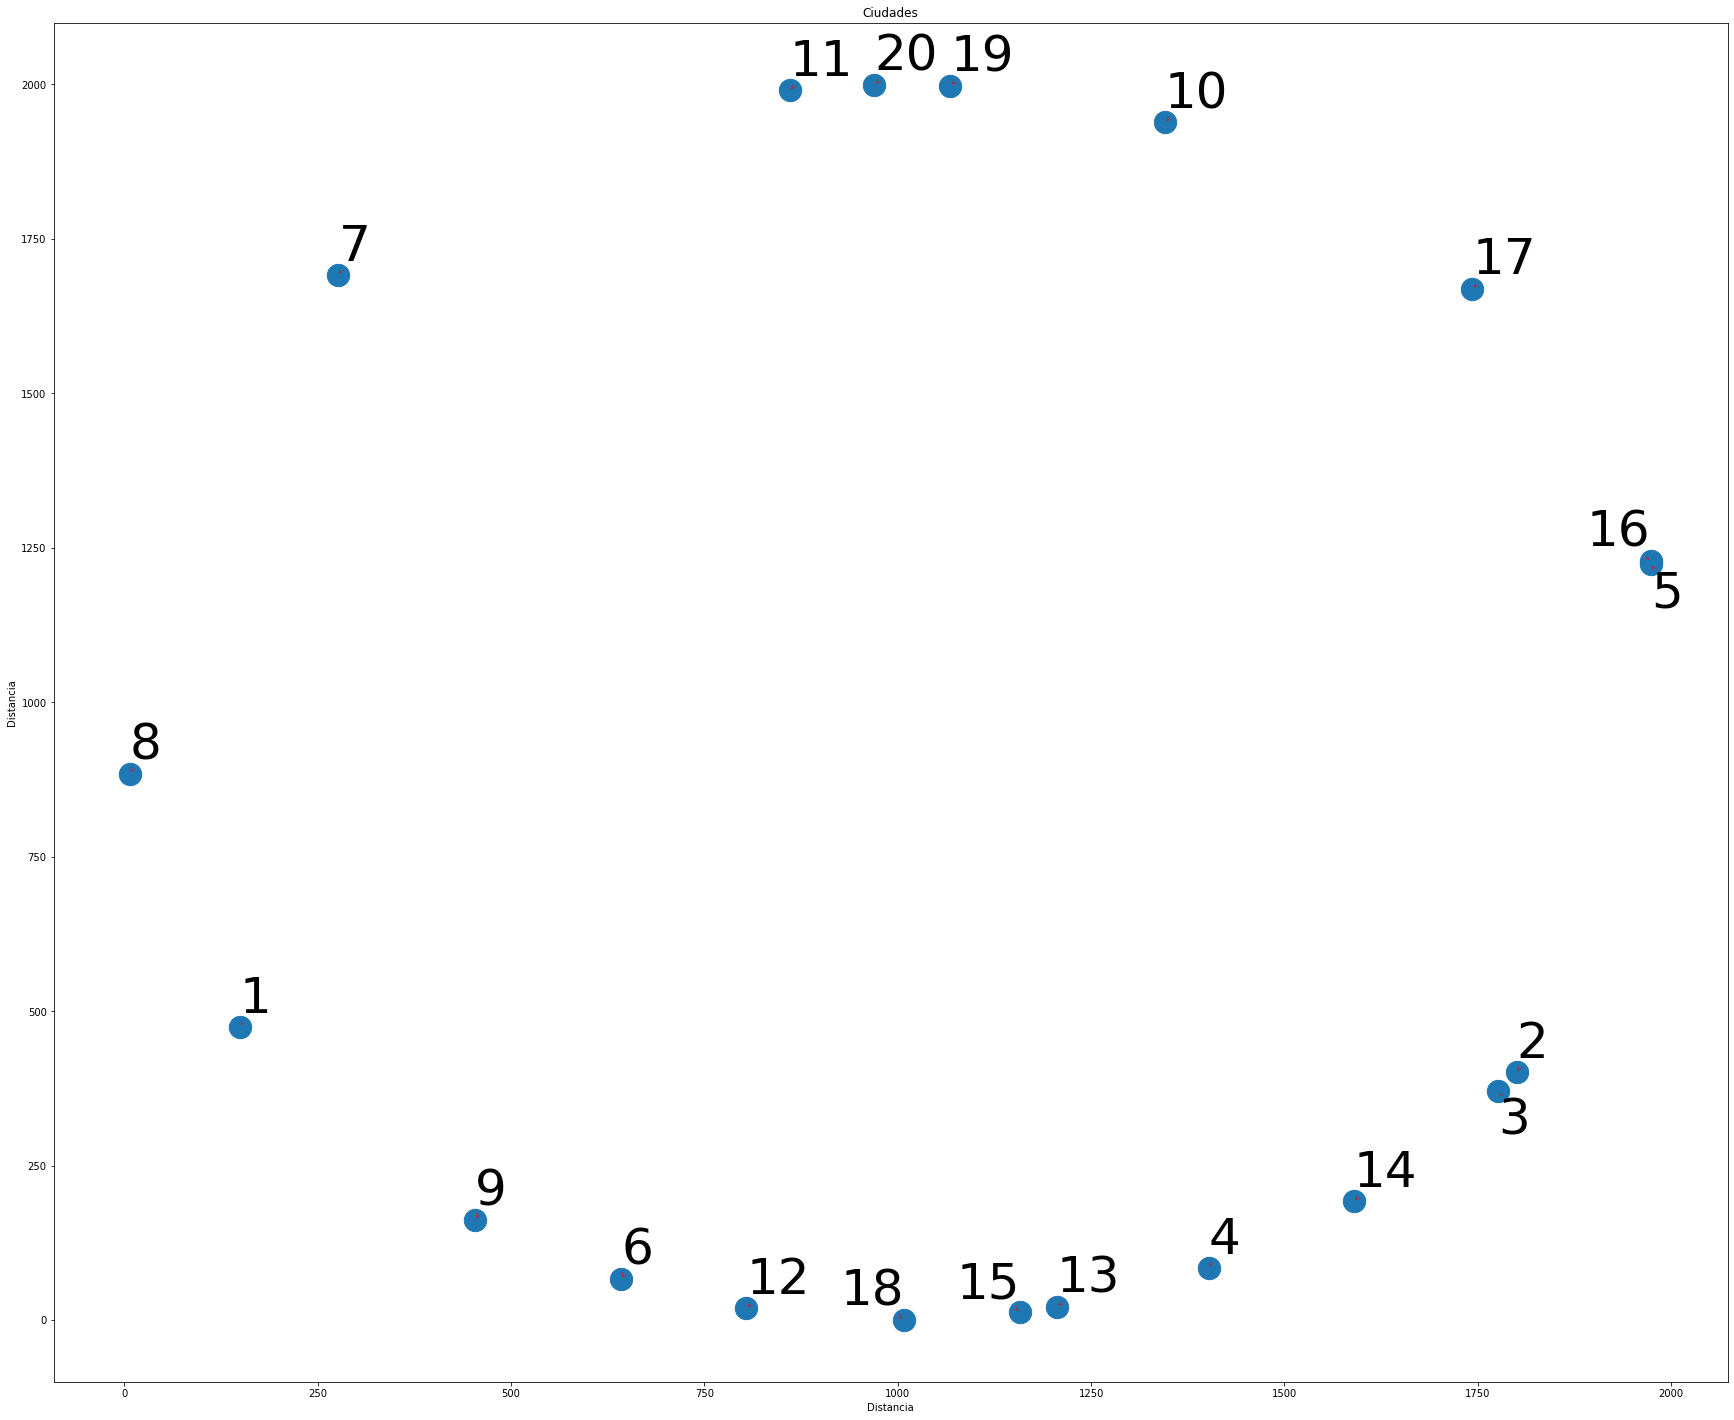

In [108]:
## crear ciudades, separadas de forma aleatoria, dentro de una circunferencia
import numpy as np
import matplotlib.pyplot as plt
import math
import io
from adjustText import adjust_text
from scipy import interpolate

#print(math.sin(math.pi))

#ciudades_a_armar= [5,10,15,20,30,50,80,100,150,200,500,750,1000,1500,2000]

#ciudades_a_armar= [250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500]
ciudades_a_armar=[20]
RADIO_CIRC = 1000

primera_ciudad = True
for a in ciudades_a_armar:
    cant_ciudades = a
    fi = 0

    np.random.seed(a)
    fi = np.random.uniform(0,2*np.pi, cant_ciudades)
    radio = np.array([RADIO_CIRC for a in range(cant_ciudades)])

    ciudades_x = RADIO_CIRC + radio * np.cos(fi)
    ciudades_y = RADIO_CIRC + radio * np.sin(fi)
    ciudades = np.array([c+1 for c in range(a)])

    """with open("ALL_TSP/euc2d/iia{}.tsp".format(a), 'w') as f:
        f.write("NAME : iia{}\n".format(a))
        f.write("COMMENT : {} ciudades en circunferencia radio {}\n".format(a, RADIO_CIRC))
        f.write("TYPE : TSP\n")
        f.write("DIMENSION: {}\n".format(a))
        f.write("EDGE_WEIGHT_TYPE : EUC_2D\n")
        f.write("NODE_COORD_SECTION\n")
        ciudad = 1
        for x,y in zip(ciudades_x,ciudades_y):
            f.write("{} {} {}\n".format(ciudad,x,y))
            ciudad += 1
        f.write("EOF\n")
        f.close()"""

    plt.figure(figsize=(30,25))
    plt.scatter(ciudades_x,ciudades_y, s=500)

    texts = []
    for x, y, s in zip(ciudades_x, ciudades_y, ciudades):
        texts.append(plt.text(x, y, s, size=50))

    plt.xlabel("Distancia")
    plt.ylabel("Distancia")
    plt.title("Ciudades")
    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    if (primera_ciudad):
        plt.show()
        #pass

    #plt.savefig("ALL_TSP/euc2d/iia{}_2.png".format(a))
    #plt.close()


        
    #b=0
    #for xy in zip(ciudades_x, ciudades_y):
    #    b += 1
    #    plt.annotate("{}".format(b), xy=xy, fontsize=10)

    #p1 = plt.plot(ciudades_x,ciudades_y,color="black", alpha=0.5)
        

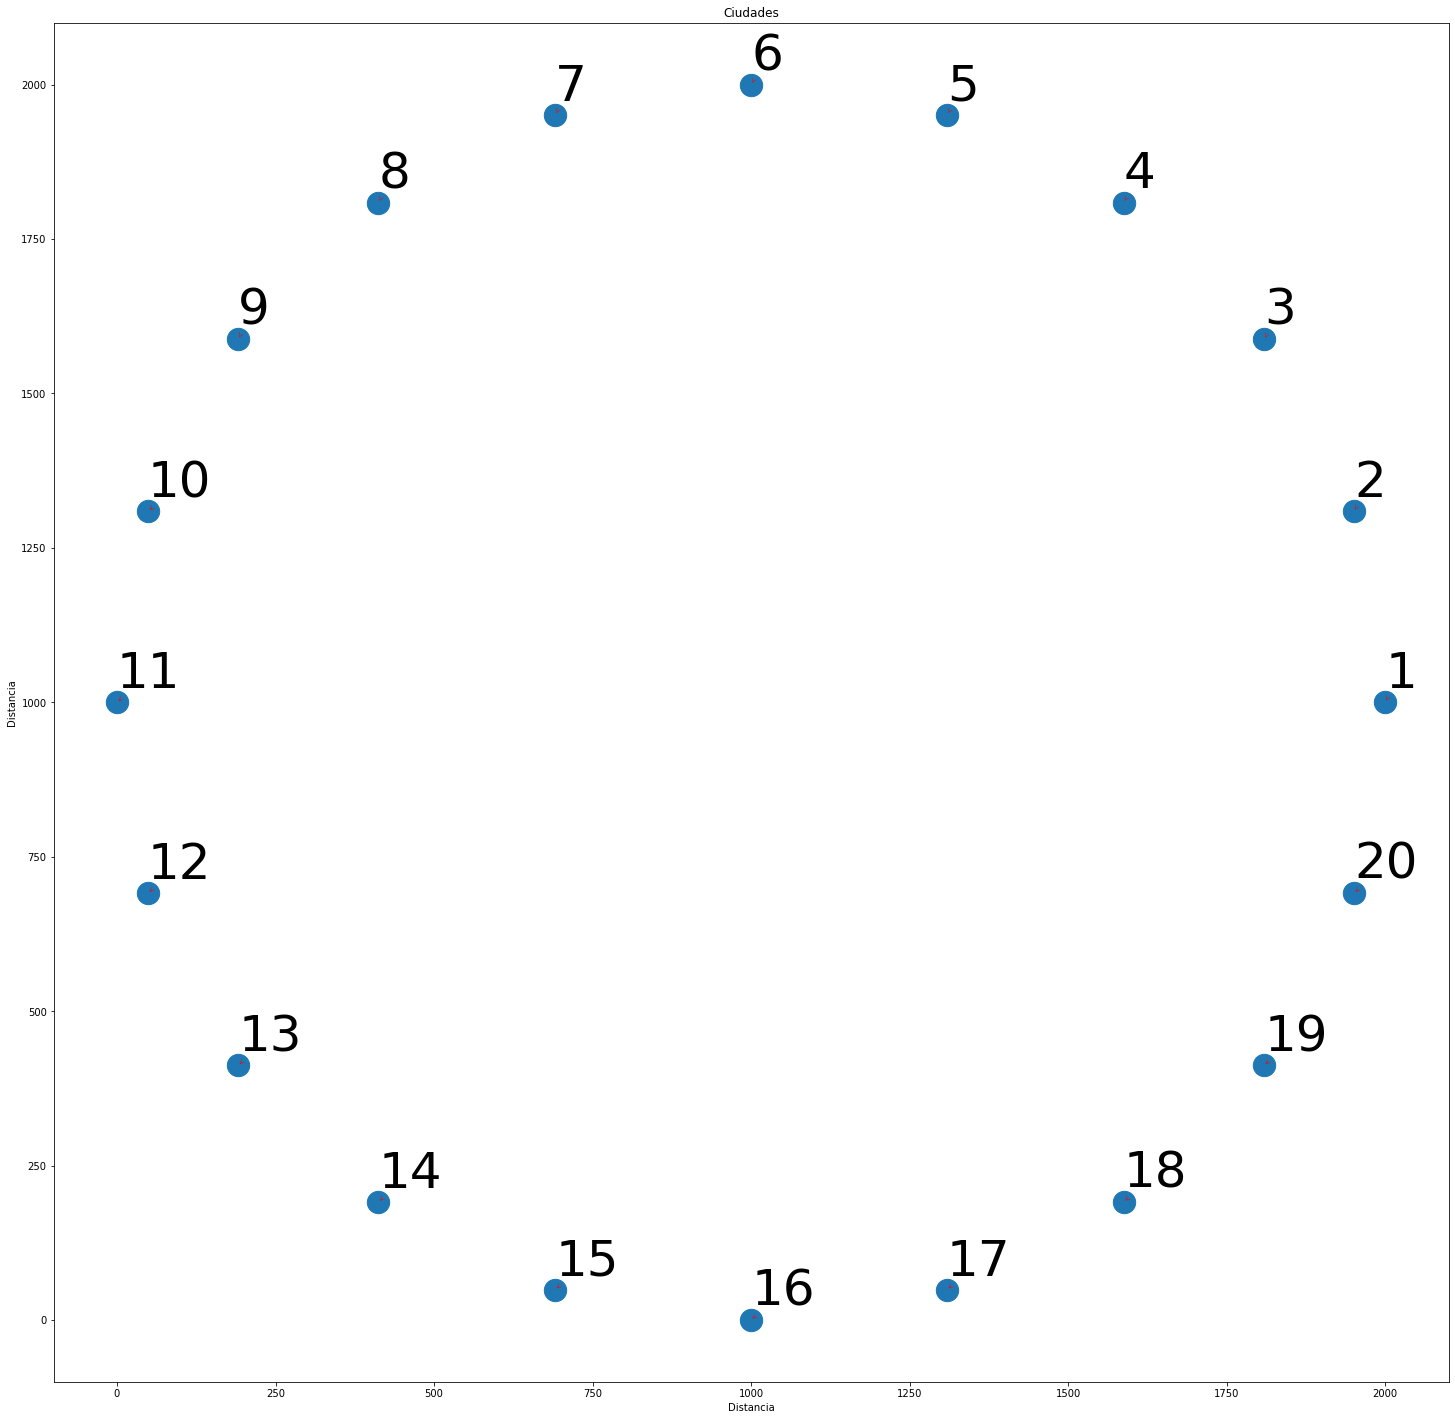

In [47]:
## crear ciudades equidistantes dentro de una circunferencia
import numpy as np
import matplotlib.pyplot as plt
import math
import io
from adjustText import adjust_text
from scipy import interpolate

#print(math.sin(math.pi))

#ciudades_a_armar= [5,10,15,20,30,50,80,100,150,200,500,750,1000,1500,2000]

##ciudades_a_armar= [250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500]
ciudades_a_armar=[20]
RADIO_CIRC = 1000
LETRAS_GRANDES = True

primera_ciudad = True
for a in ciudades_a_armar:
    cant_ciudades = a
    fi = np.array([(2*np.pi/cant_ciudades)*b for b in range(cant_ciudades)])

    #np.random.seed(a)
    #fi = np.random.uniform(0,2*np.pi, cant_ciudades)
    radio = np.array([RADIO_CIRC for a in range(cant_ciudades)])

    ciudades_x = RADIO_CIRC + radio * np.cos(fi)
    ciudades_y = RADIO_CIRC + radio * np.sin(fi)
    ciudades = np.array([c+1 for c in range(a)])

    """with open("ALL_TSP/euc2d/iia_fijo{}.tsp".format(a), 'w') as f:
        f.write("NAME : iia{}\n".format(a))
        f.write("COMMENT : {} ciudades en circunferencia radio {}\n".format(a, RADIO_CIRC))
        f.write("TYPE : TSP\n")
        f.write("DIMENSION: {}\n".format(a))
        f.write("EDGE_WEIGHT_TYPE : EUC_2D\n")
        f.write("NODE_COORD_SECTION\n")
        ciudad = 1
        for x,y in zip(ciudades_x,ciudades_y):
            f.write("{} {} {}\n".format(ciudad,x,y))
            ciudad += 1
        f.write("EOF\n")
        f.close()"""

    plt.figure(figsize=(25,25))
    
    if LETRAS_GRANDES == True:
        plt.scatter(ciudades_x,ciudades_y, s=500)
        texts = []
        for x, y, s in zip(ciudades_x, ciudades_y, ciudades):
            texts.append(plt.text(x, y, s, size=50))
        adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    else:
        plt.scatter(ciudades_x,ciudades_y, s=50)
        b=0
        for xy in zip(ciudades_x, ciudades_y):
            b += 1
            plt.annotate("{}".format(b), xy=xy, fontsize=10)

    plt.xlabel("Distancia")
    plt.ylabel("Distancia")
    plt.title("Ciudades")

    if (primera_ciudad):
        plt.show()
        #pass

    #plt.savefig("ALL_TSP/euc2d/iia_fijo{}.png".format(a))
    #plt.close()

    #p1 = plt.plot(ciudades_x,ciudades_y,color="black", alpha=0.5)
        